In [47]:
import sys, os
import json, pickle
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import time as pytime
import statsmodels.tsa.stattools as tsa
import ruptures as rpt
import InsanallyLabEphysTools as ilep
import OldDecodingTools as odt
from scipy.stats import gaussian_kde, sem, ttest_ind, ttest_rel, norm, mannwhitneyu, linregress, wilcoxon
from tqdm import tqdm
from types import SimpleNamespace
from sklearn import linear_model
from itertools import product
from datetime import datetime
import h5py
#import tables as tb
from copy import deepcopy
import colorsys

from sklearn.model_selection import GridSearchCV, StratifiedKFold, LeaveOneOut
from sklearn.neighbors import KernelDensity

plt.rcParams['legend.fontsize'] = 'small'
plt.rcParams['axes.labelsize'] = 'medium'
plt.rcParams['axes.formatter.limits'] = [-2,3]
plt.rcParams['axes.formatter.use_mathtext'] = True
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['figure.dpi'] = '150'

#Set global font parameters
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
#Set font type to TrueType for compatibility
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

CR_COLOR = '#808080'
NCR_COLOR = '#FF767C'
CNO_COLOR = '#00BFFF'
GOOD_GREY = '#969696'
SWITCH_COLOR = '#B07A3B'
NCR_CR_cmap = mpl.colors.LinearSegmentedColormap.from_list('NCR-CR color map', [NCR_COLOR, CR_COLOR], N=1000)

act_directory = 'D:\\Analysis_Cache'
beh_directory = 'P:\\Behavioor'

%run animal_info
ANIMAL = 'AC_12102016'

animalstouse = ['BS_40','BS_41','BS_42','BS_49','BS_50','BS_51','BS_56','BS_59','BS_61','BS_67','BS_70','BS_72','BS_87','BS_108','DS_15','DS_19']

def nonan(X):
    X = np.array(X)
    return X[np.isfinite(X)]

In [2]:
TRIAL_DURATION = 10
PRE_TRIAL_DURATION = 2.5

def extract_spikes(hd5_file, neuron_num=0):
    """Extracts the spiking data from the hdf5 file. Returns an array of
    spike times.

    Keyword arguments:
    neuron_num -- the index of the neuron you would like to access.
    """
    with h5py.File(hd5_file, "r+") as f:
        neuron_list = f['NF']['value']['neurons']['value']
        if len(neuron_list) <= 10:
            neuron_str = "_" + str(neuron_num)
        else:
            neuron_str = "_" + "0" * (2 - len(str(neuron_num))) + str(neuron_num)
        timestamps = numpy.array(neuron_list[neuron_str]['value']['timestamps']['value'][0])
    return(timestamps)


def extract_events(hd5_file):
    """Extracts the timestamps of the events stored in the hdf5 file."""
    events = {}
    with h5py.File(hd5_file, "r+") as f:
        event_list = f['NF']['value']['events']['value']
        for key in event_list.keys():
            if key == 'dims':
                continue
            name = event_list[key]['value']['name']['value']
            # The hdf5 that results file contains the names not as strings
            # but as an array of integers which code for the string in
            # ASCII format.
            #name_str = ''.join(map(chr, name))
            name_str = ''.join([chr(c[0]) for c in numpy.array(name)])
            try:
                timestamps = numpy.array(event_list[key]['value']['timestamps']['value'][0])
            except:
                timestamps = numpy.array([], dtype='float64')
            events[name_str] = timestamps
    return(events)


def load_events_spikes_script(neuron_num=0, base_dir='C:\\Users\\insan\\Desktop\\elife\\code', spike_files=None, event_files=None, exception=None, variables=None, **kwargs):
    """Extracts spikes and events
    """
    event_set = [extract_events(os.path.join(base_dir, f)) for f in event_files]
    if type(neuron_num) is int:
        if exception is not None:
            spike_set = [event_set[i][exception[neuron_num]] for i in range(len(event_set))]
        else:
            spike_set = [extract_spikes(os.path.join(base_dir, f), neuron_num) for f in spike_files]
    elif (type(neuron_num) is list) or (type(neuron_num) is tuple):
        spike_set = []
        for num in neuron_num:
            if exception is not None:
                spike_set_temp = [event_set[i][exception[num]] for i in range(len(event_set))]
            else:
                spike_set_temp = [extract_spikes(os.path.join(base_dir, f), num) for f in spike_files]
            spike_set.append(spike_set_temp)
    return(event_set, spike_set)


######################
# Basic Calculations #
######################


def create_complete_table(event_set, spike_set, variable_maps, pre_trial_duration=PRE_TRIAL_DURATION, trial_duration=TRIAL_DURATION, stim_variables=['T', 'F'], action_variables=['NPT', 'NPF']):
    assert len(action_variables) == len(stim_variables)
    stimuli = []
    stimuli_time = []
    actions = []
    correctness = []
    nose_pokes = []
    num_neurons = len(spike_set)
    responses = [[] for i in range(num_neurons)]
    all_trial_times = []
    for events, spikes_list, variable_map in zip(event_set, zip(*spike_set), variable_maps):
        for stim_variable, action_variable in zip(stim_variables, action_variables):
            trial_times = events[variable_map[stim_variable]]
            try:
                nose_poke_times = numpy.array(events[variable_map[action_variable]])
            except:
                nose_poke_times = None
            try:
                correct_times = events[variable_map[stim_variable + '+']]
            except:
                correct_times = None

            all_trial_times.extend(trial_times)

            for i, trial_time in enumerate(trial_times):
                stimuli.append(stim_variable)
                stimuli_time.append(trial_time)

                # finding correctness of trial
                if correct_times is None:
                    correctness.append('U')
                elif trial_time in correct_times:
                    correctness.append('+')
                else:
                    correctness.append('-')

                # finding nosepoke time
                if nose_poke_times is None:
                    nose_pokes.append(numpy.nan)  # This conflates no response with unkown response.  There is probably a better system
                    actions.append('U')
                else:
                    if i == len(trial_times) - 1:
                        index = (nose_poke_times > trial_time)
                    else:
                        index = (nose_poke_times > trial_time)*(nose_poke_times < trial_times[i+1])
                    if sum(index) == 0:
                        nose_poke_time = numpy.nan
                        actions.append('W')
                    else:
                        nose_poke_time = nose_poke_times[index][0] - trial_time
                        actions.append('NP')
                    nose_pokes.append(nose_poke_time)

                for i, spikes in enumerate(spikes_list):
                    current_response = spikes[(spikes >= trial_time - pre_trial_duration)*(spikes < (trial_time + trial_duration))] - trial_time
                    responses[i].append(deepcopy(current_response))

    sort_index = numpy.argsort(all_trial_times)
    for i, response in enumerate(responses):
        responses[i] = numpy.array(response)[sort_index]

    return(numpy.array(stimuli_time)[sort_index], numpy.array(stimuli)[sort_index], numpy.array(actions)[sort_index], numpy.array(nose_pokes)[sort_index], responses)

def load_session_h5py(ANIMAL):
    animal_info = ANIMALS[ANIMAL]
    neuron = 0
    trial_duration = animal_info['trial_duration']
    last_trial = animal_info['last_trial']

    event_set, spike_set = load_events_spikes_script(neuron_num=neuron, **animal_info)
    st0, s0, a0, np0, r0 = create_complete_table(event_set, spike_set, animal_info['variables'], 
                                                        trial_duration = trial_duration, 
                                                        pre_trial_duration = trial_duration)

    #Meta
    sessionfile = SimpleNamespace()
    sessionfile.meta = SimpleNamespace()
    sessionfile.meta.fs = 30000
    sessionfile.meta.length_in_trials = len(s0)
    sessionfile.meta.task = 'nonreversal'#

    #Trials
    sessionfile.trials = SimpleNamespace()
    sessionfile.trials.target = s0 == 'T'
    sessionfile.trials.go = a0 == 'NP'
    sessionfile.trials.starts = st0
    sessionfile.trials.ends = sessionfile.trials.starts + trial_duration
    sessionfile.trials.starts *= sessionfile.meta.fs
    sessionfile.trials.ends *= sessionfile.meta.fs

    #Clusters
    sessionfile.clusters = SimpleNamespace()
    sessionfile.clusters.good = animal_info['all_neurons']

    #Spikes
    sessionfile.spikes = SimpleNamespace()
    sessionfile.spikes.times = []
    sessionfile.spikes.clusters = []
    for clust in sessionfile.clusters.good:
        _, spike_set_clust = load_events_spikes_script(neuron_num=[clust], **animal_info)
        spikes = spike_set_clust[0][0]
        spikes *= sessionfile.meta.fs
        clusters = np.full_like(spikes,clust)    
        sessionfile.spikes.times = np.concatenate((sessionfile.spikes.times,spikes))
        sessionfile.spikes.clusters = np.concatenate((sessionfile.spikes.clusters,clusters))

    #Trim
    sessionfile.trim = dict()
    for clust in sessionfile.clusters.good:
        sessionfile.trim[clust] = SimpleNamespace()
        sessionfile.trim[clust].trimmed_trials = list(range(len(s0)))
        
    return sessionfile

In [3]:
def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

# Rat BWs

In [8]:
ANIMALS_LIST = [key for key in ANIMALS]
#number_of_cells = 1

sessionIDs = []
clusters = []
bws = []

def getBWs_elife2019():
    return np.linspace(.005, 0.305, 11)

EnumANIMAL = []
EnumClust = []
for ANIMAL in ANIMALS_LIST:
    #if len(EnumClust) >= number_of_cells:
    #    break
        
    try:
        sessionfile = load_session_h5py(ANIMAL)
        for clust in sessionfile.clusters.good:
            EnumANIMAL.append(ANIMAL)
            EnumClust.append(clust)
    except Exception as e:
        pass
    
for idx in tqdm(range(16,len(EnumClust))):
    
    ANIMALID = EnumANIMAL[idx]
    clust = EnumClust[idx]
    
    if ANIMAL != ANIMALID:
        ANIMAL = ANIMALID
        sessionfile = load_session_h5py(ANIMAL)

    ##############################################################
    try:
        
        bws = []
        accs = []
        accs_sem = []

        for bw in getBWs_elife2019():

            acc,acc_std,acc_sem,_,_,_,_,_,_,_ = ilep.CalculateClusterAccuracy(sessionfile,clust,reps = 10,categories='stimulus',bw=bw)

            bws.append(bw)
            accs.append(acc)
            accs_sem.append(acc_sem)

        fig,ax = plt.subplots(figsize=(5,3))

        mindiff = np.min(np.diff(np.sort(np.unique(bws))))
        ax.bar(bws,accs,width=mindiff,color='grey')
        ax.errorbar(bws,accs,accs_sem,lw=0,elinewidth=2,color='black',zorder=10)
        #ax.errorbar(bws+0.05,accs,accs_std,lw=0,elinewidth=2,color='black',zorder=10)
        fig.savefig(os.path.join('D:\\Figures\\Decoding Schematics\\BW Performances\\'+ANIMAL+' cluster '+str(clust)+' BW Performance.png'))
        
    except Exception as e:
        print(e)
    
#     try:
#         temp = ilep.sklearn_grid_search_bw(sessionfile,clust,folds=100)
#         bws.append(temp)
#         sessionIDs.append(ANIMAL)
#         clusters.append(clust)
#     except:
#         bws.append(np.nan)
#         sessionIDs.append(ANIMAL)
#         clusters.append(clust)

  0%|          | 1/274 [00:00<01:33,  2.93it/s]

division by zero


  1%|          | 2/274 [00:01<02:23,  1.89it/s]

division by zero


  1%|▏         | 4/274 [01:00<1:18:25, 17.43s/it]

division by zero


  4%|▍         | 11/274 [46:41<18:36:32, 254.72s/it]


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x00000284017D81F0> (for post_execute):


KeyboardInterrupt: 

# Mouse BWs

In [17]:
sessionIDs = []
clusters = []
bws = []

EnumSession = []
EnumClust = []
for session in sessions:
    sessionfile = ilep.loadSessionCached(directory,session)
    for clust in sessionfile.clusters.good:
        EnumSession.append(session)
        EnumClust.append(clust)
    
for idx in tqdm(range(50)):
    sessionID = EnumSession[idx]
    clust = EnumClust[idx]
    
    if session != sessionID:
        session = sessionID
        sessionfile = ilep.loadSessionCached(directory,session)
        print('loaded '+ilep.generateDateString(sessionfile))
        
    print('cluster '+str(clust))
    ##############################################################
    bws.append(ilep.sklearn_grid_search_bw(sessionfile,clust,folds=10))
    sessionIDs.append(session)
    clusters.append(clust)

  0%|          | 0/50 [00:00<?, ?it/s]

loaded BS_108_1_AC_3-22-2022
cluster 2


  2%|▏         | 1/50 [00:00<00:15,  3.19it/s]

cluster 8


  4%|▍         | 2/50 [00:31<14:48, 18.52s/it]

cluster 9


  6%|▌         | 3/50 [00:52<15:21, 19.61s/it]

cluster 14


  8%|▊         | 4/50 [00:53<09:17, 12.12s/it]

cluster 34


 10%|█         | 5/50 [00:55<06:21,  8.48s/it]

cluster 35


 12%|█▏        | 6/50 [00:56<04:24,  6.01s/it]

loaded BS_108_1_M2_3-22-2022
cluster 19


 14%|█▍        | 7/50 [00:58<03:23,  4.74s/it]

cluster 29


 16%|█▌        | 8/50 [01:00<02:46,  3.97s/it]

cluster 45


 18%|█▊        | 9/50 [01:08<03:36,  5.29s/it]

cluster 61


 20%|██        | 10/50 [01:26<06:00,  9.00s/it]

cluster 64


 22%|██▏       | 11/50 [01:57<10:20, 15.91s/it]

cluster 68


 24%|██▍       | 12/50 [02:06<08:44, 13.80s/it]

cluster 69


 26%|██▌       | 13/50 [02:08<06:17, 10.20s/it]

cluster 70


 28%|██▊       | 14/50 [02:23<06:52, 11.47s/it]

cluster 71


 30%|███       | 15/50 [02:24<04:54,  8.42s/it]

cluster 92


 32%|███▏      | 16/50 [02:25<03:26,  6.06s/it]

cluster 95


 34%|███▍      | 17/50 [02:46<05:48, 10.57s/it]

cluster 96


 36%|███▌      | 18/50 [02:48<04:20,  8.13s/it]

cluster 120


 38%|███▊      | 19/50 [02:52<03:34,  6.91s/it]

cluster 123


 40%|████      | 20/50 [02:55<02:53,  5.77s/it]

cluster 128


 42%|████▏     | 21/50 [02:56<02:00,  4.14s/it]

cluster 141


 44%|████▍     | 22/50 [03:08<03:01,  6.48s/it]

cluster 142


 46%|████▌     | 23/50 [03:09<02:14,  4.99s/it]

cluster 148


 48%|████▊     | 24/50 [03:25<03:34,  8.27s/it]

cluster 169


 52%|█████▏    | 26/50 [03:28<01:54,  4.79s/it]

cluster 175
cluster 177


 54%|█████▍    | 27/50 [03:29<01:20,  3.51s/it]

cluster 183


 56%|█████▌    | 28/50 [05:12<12:10, 33.21s/it]

cluster 185


 58%|█████▊    | 29/50 [06:13<14:37, 41.77s/it]

cluster 186


 60%|██████    | 30/50 [06:14<09:50, 29.54s/it]

cluster 190


 62%|██████▏   | 31/50 [06:30<08:02, 25.37s/it]

loaded BS_108_2_AC_3-23-2022
cluster 2


 64%|██████▍   | 32/50 [06:34<05:43, 19.08s/it]

cluster 6
cluster 7


 70%|███████   | 35/50 [06:35<01:57,  7.84s/it]

cluster 26
loaded BS_108_2_M2_3-23-2022
cluster 7


 72%|███████▏  | 36/50 [06:42<01:46,  7.60s/it]

cluster 11


 74%|███████▍  | 37/50 [06:42<01:13,  5.66s/it]

cluster 18


 76%|███████▌  | 38/50 [07:03<01:57,  9.81s/it]

cluster 45


 78%|███████▊  | 39/50 [07:07<01:31,  8.28s/it]

cluster 57


 80%|████████  | 40/50 [07:08<01:01,  6.17s/it]

cluster 62


 82%|████████▏ | 41/50 [07:24<01:22,  9.11s/it]

cluster 69


 84%|████████▍ | 42/50 [07:29<01:02,  7.80s/it]

cluster 77


 86%|████████▌ | 43/50 [07:43<01:07,  9.63s/it]

cluster 104


 88%|████████▊ | 44/50 [07:45<00:44,  7.47s/it]

cluster 108


 90%|█████████ | 45/50 [07:47<00:28,  5.61s/it]

cluster 121


 92%|█████████▏| 46/50 [08:07<00:40, 10.14s/it]

cluster 123


 94%|█████████▍| 47/50 [08:13<00:26,  8.86s/it]

cluster 125


 96%|█████████▌| 48/50 [08:20<00:16,  8.07s/it]

cluster 136


 98%|█████████▊| 49/50 [08:21<00:05,  5.99s/it]

cluster 138


100%|██████████| 50/50 [08:30<00:00, 10.21s/it]


In [10]:
# data = np.column_stack([sessionIDs,clusters,bws])
# labels = ['sessions','clusters','bws']
# df = pd.DataFrame(data=data, columns=labels)
# df.to_csv('D:\\RatDataBandwidths100fCached.csv')

data = np.column_stack([bws])
labels = ['bws']
df = pd.DataFrame(data=data, columns=labels)
df.to_csv('D:\\RatDataBandwidthsSizeMatchedCached.csv')

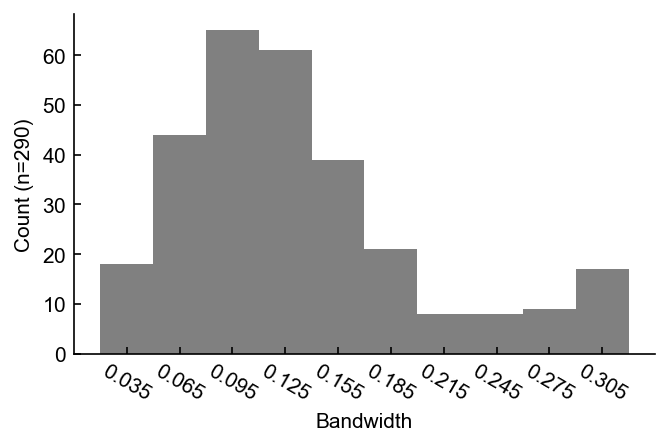

In [9]:
bws = new_bws

fig,ax = plt.subplots(figsize=(5,3))

X = bws

#Remove nans
nonans = np.isfinite(bws)
bws = np.array(bws)
bws = bws[nonans]

unq = np.sort(np.unique(X))
mindiff = np.min(np.diff(unq))
for u in unq:
    ax.bar([u],[np.sum(np.equal(X,u))],width=mindiff,color='grey')
ax.set_xticks(unq)
ax.set_xticklabels(np.round(1000*unq)/1000,rotation=-30)
ax.set_xlabel('Bandwidth')
ax.set_ylabel('Count (n='+str(len(bws))+')')
fig.savefig(os.path.join('C:\\Users\\insan\\Desktop\\RatDecodingBWsSizeMatched.png'))
pass

# Load Results from Rat Data

In [27]:
empirical_filename = 'D:\\RatDataDecodingCached.csv'
rat_df = pd.read_csv (empirical_filename)

sessionIDs = rat_df['sessions']
clusters = rat_df['clusters']
accuracies = rat_df['accuracies']
accuracies_std = rat_df['accuracies_std']
accuracies_sem = rat_df['accuracies_sem']
waccuracies = rat_df['waccuracies']
waccuracies_std = rat_df['waccuracies_std']
waccuracies_sem = rat_df['waccuracies_sem']
caccuracies = rat_df['caccuracies']
#caccuracies_std = rat_df['caccuracies_std']
caccuracies_sem = rat_df['caccuracies_sem']
pvals = rat_df['pvals']

# Load Empirical Results from eLife 2019

In [38]:
empirical_filename = 'C:\\Users\\insan\\Desktop\\eLife_decoding_summary.csv'
elife_df = pd.read_csv(empirical_filename)
elife_df = elife_df.set_index(['rec','cell'])

empirical_waccuracy = []
for idx in tqdm(range(len(rat_df['waccuracies']))):
    try:
        value = elife_df.loc[rat_df['sessions'][idx],rat_df['clusters'][idx]].stim_mean
        empirical_waccuracy.append(value)
    except Exception as e:
        empirical_waccuracy.append(np.nan)

100%|██████████| 277/277 [00:00<00:00, 7630.62it/s]


# Load Results from Mouse Stimulus Data

In [4]:
#filename = 'D:\\MouseDataStimulusDecodingCached.csv'
#filename = 'D:\\MouseDatastimulusDecodingCached4858units2022-09-23.csv'
#filename = 'D:\\MouseDatastimulusDecodingCached5632units2022-10-05.csv'
#filename = 'D:\\MouseDatastimulusDecodingCached5801units2022-10-18FromCache.csv'
filename = 'D:\\MouseDatastimulusDecodingCached5801units2022-10-20FromCache.csv'

#filename = 'D:\\MouseDatastimulusDecodingCached5759units2022-10-07.csv'#eLife Criterion

mouse_df = pd.read_csv (filename)

sessionIDs = mouse_df['sessions']
clusters = mouse_df['clusters']
accuracies = mouse_df['accuracies']
accuracies_std = mouse_df['accuracies_std']
accuracies_sem = mouse_df['accuracies_sem']
waccuracies = mouse_df['waccuracies']
waccuracies_std = mouse_df['waccuracies_std']
waccuracies_sem = mouse_df['waccuracies_sem']
caccuracies = mouse_df['caccuracies']
#caccuracies_std = mouse_df['caccuracies_std']
caccuracies_sem = mouse_df['caccuracies_sem']
pvals = mouse_df['pvals']

categories = 'stimulus'

In [5]:
accuracies

0       0.535836
1       0.683861
2       0.610038
3       0.555767
4       0.643253
          ...   
5796    0.758587
5797    0.625458
5798    0.635430
5799    0.663829
5800    0.699509
Name: accuracies, Length: 5801, dtype: float64

In [4]:
sessionIDs

0       BS_108_1_AC.pickle
1       BS_108_1_AC.pickle
2       BS_108_1_AC.pickle
3       BS_108_1_AC.pickle
4       BS_108_1_AC.pickle
               ...        
5796    DS_22_21_AC.pickle
5797    DS_22_21_AC.pickle
5798    DS_22_21_AC.pickle
5799    DS_22_21_AC.pickle
5800    DS_22_21_AC.pickle
Name: sessions, Length: 5801, dtype: object

In [270]:
clusters

0        2
1        8
2        9
3       14
4       34
        ..
5796    68
5797    70
5798    77
5799    79
5800    81
Name: clusters, Length: 5801, dtype: int64

# Generate Regions

In [6]:
regions = ['NA']*len(sessionIDs)
for idx,sessionID in tqdm(enumerate(sessionIDs)):
    sessionfile = ilep.loadSessionCached(act_directory,sessionID)
    regions[idx] = sessionfile.meta.region

5801it [00:23, 251.91it/s]


# Generate FRmods

In [7]:
FRmods = np.full(len(sessionIDs),np.nan)
for idx,(sessionID,clust) in tqdm(enumerate(zip(sessionIDs,clusters))):
    sessionfile = ilep.loadSessionCached(act_directory,sessionID)
    FRmods[idx] = sessionfile.responsiveness[clust]['all_trials'].FRmodulation
    
colors = NCR_CR_cmap(FRmods/4)

5801it [00:22, 252.58it/s]


# Calculate Task Encoder Cutoff

In [8]:
low_decoders = np.less(accuracies,0.5)
low_accuracies = accuracies[low_decoders]
low_magnitudes = np.absolute(low_accuracies-0.5)

low_magnitudes = np.sort(low_magnitudes)
task_encoder_threshold = 0.5+low_magnitudes[int(0.95 * len(low_magnitudes))]
print('Task encoder threshold: '+str(task_encoder_threshold))

Task encoder threshold: 0.5643597560975608


In [9]:
task_encoders = np.greater(accuracies,task_encoder_threshold)
task_encoders = np.logical_and(task_encoders,np.less_equal(pvals,0.05))
task_encoders = np.logical_and(task_encoders,np.isfinite(pvals))

In [10]:
animals_in_cache = []
for session in tqdm(os.listdir(act_directory)):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    animals_in_cache.append(sessionfile.meta.animal)
animals_in_cache = np.unique(animals_in_cache)

training_days_recorded = dict()
for animal in animals_in_cache:
    training_days_recorded[animal] = []
    
for session in tqdm(os.listdir(act_directory)):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    if sessionfile.meta.region != 'AC':
        continue
    training_days_recorded[sessionfile.meta.animal].append(sessionfile.meta.day_of_training)
    
print(training_days_recorded['BS_59'])

100%|██████████| 398/398 [00:01<00:00, 304.21it/s]

[]


# Generate Learning Phases (from curves)

In [12]:
#dualnames = ['BS_108','BS_113','BS_40','BS_41','BS_42','BS_49','BS_50','BS_51','BS_56','BS_59','BS_70','BS_72','BS_83','BS_85','BS_87','BS_95']
#animalnames = dualnames

#Animals missing:
#113,50,83,95
#Animals added:
#61,67,15,16,17,19,22

animalnames = ['BS_40','BS_41','BS_42','BS_49','BS_50','BS_51','BS_56','BS_59','BS_67','BS_70','BS_72','BS_87','BS_108','DS_15','DS_19']

animals = dict()
for animal in animalnames:
    animals[animal] = SimpleNamespace()
    animals[animal].name = animal
    
#animals['BS_33'].reversal = 20
animals['BS_67'].reversal = 7
#animals['BS_73'].reversal = np.nan
#animals['BS_78'].reversal = np.nan
animals['BS_108'].reversal = 7
#animals['BS_113'].reversal = 13
animals['BS_40'].reversal = 18
animals['BS_41'].reversal = 6
animals['BS_42'].reversal = 7
animals['BS_49'].reversal = 13
animals['BS_50'].reversal = 12
animals['BS_51'].reversal = 8
#animals['BS_52'].reversal = 15
animals['BS_56'].reversal = 8
animals['BS_59'].reversal = 7
#animals['BS_61'].reversal = 9    ###
animals['BS_70'].reversal = 8
animals['BS_72'].reversal = 6
#animals['BS_83'].reversal = 20
#animals['BS_85'].reversal = 10
animals['BS_87'].reversal = 6
#animals['DS_16'].reversal = 11
#animals['BS_95'].reversal = 8
animals['DS_15'].reversal = 12
animals['DS_19'].reversal = 12

BS_40
BS_41
BS_42
BS_49
BS_50
BS_51
BS_56
BS_59
BS_67
BS_70
BS_72
BS_87
BS_108
DS_15
DS_19


AttributeError: 'NoneType' object has no attribute 'dpi_scale_trans'

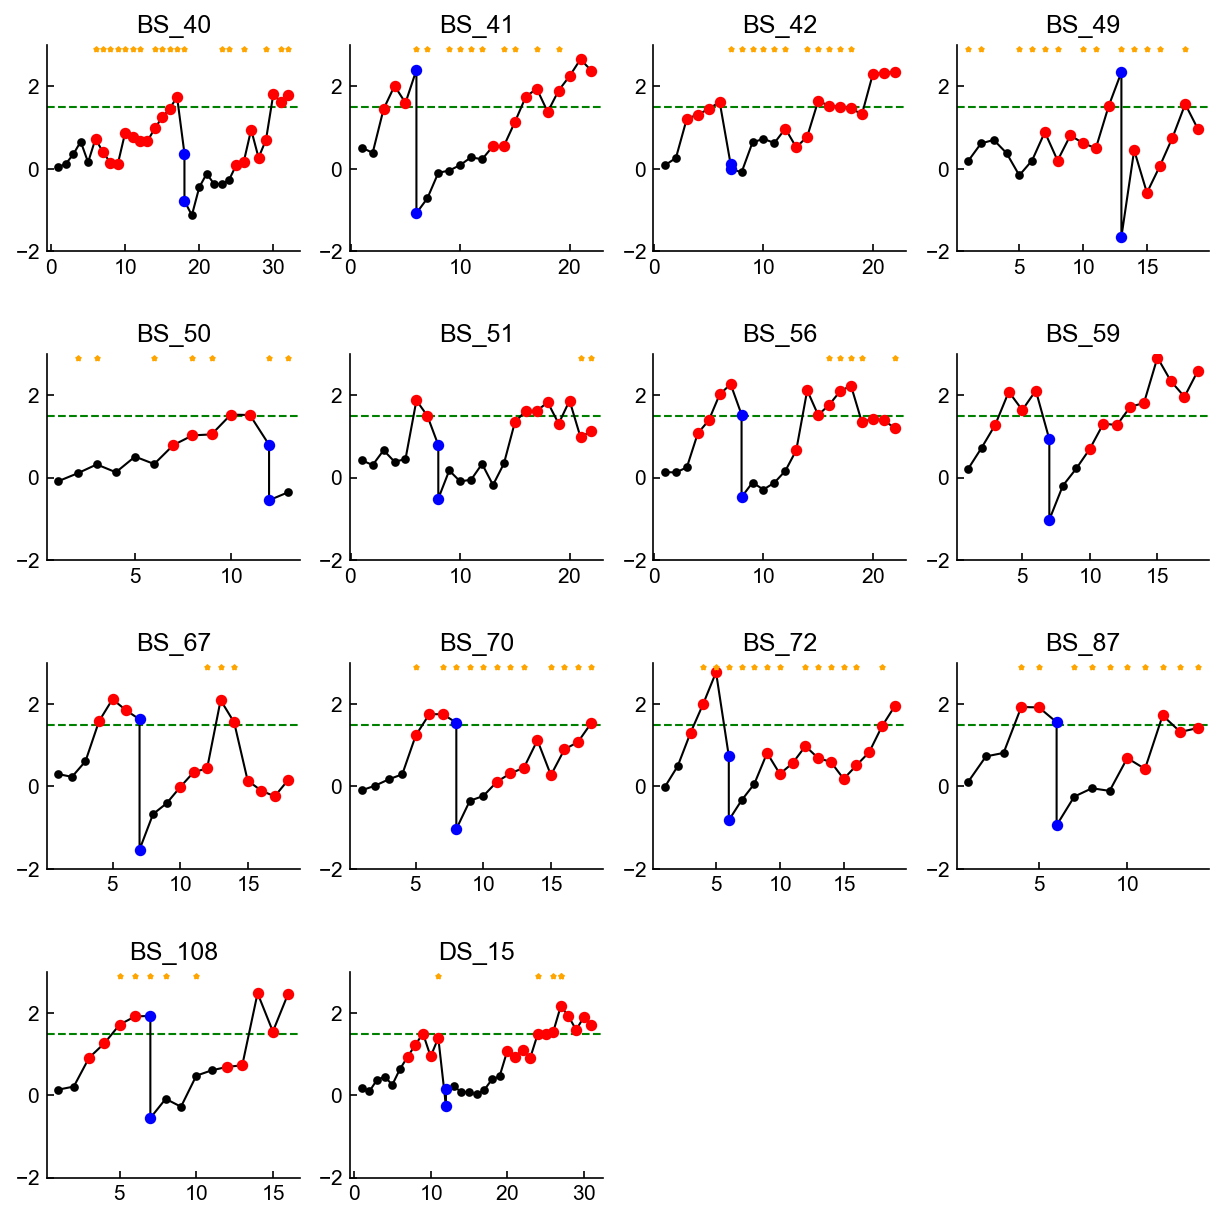

In [13]:
filename = os.path.join('C:\\\\Users','insan','Desktop','DataForJMT.csv')
#filename = os.path.join('C:\\\\Users','4thgr','Desktop','DataForJMT.csv')
csv = pd.read_csv(filename)

postthresholds = dict()

plot=True
if plot:
    fig = plt.figure(figsize=(10,10))
    gs = fig.add_gridspec(4,4,hspace=0.5)
    axs = [plt.subplot(gs[i,j]) for i,j in product(range(4),range(4))]
    plt.delaxes(axs[14])
    plt.delaxes(axs[15])

premiddlecutoffs = dict()
postmiddlecutoffs = dict()
PERphases = dict()

for animalidx,animal in enumerate(animals):
    print(animal)
    PERphases[animal] = dict()
    
    condname = 'd\' ' + animal
    pc_condname = 'Percent correct ' + animal
    days = np.array(list(csv['Day']))
    cond = csv[condname]
    cond_pc = csv[pc_condname]
    
    #Correct for double reversal days
    for idx,day in enumerate(days):
        if day > animals[animal].reversal:
            days[idx] = day-1
            
        if day > animals[animal].reversal+1: #  +1 because the csv stores the switch day as two entries
            #Calculate PERphase
            PC = cond_pc[idx]
            if PC <= 47.5:
                PERphases[animal][day-1] = 'perseveration'
            elif PC >= 52.5:
                PERphases[animal][day-1] = 'refinement'
            else:
                PERphases[animal][day-1] = 'exploration'
            
    #days = days - animals[animal].reversal
    
    prereversaldays = []
    prereversaldps = []
    maxreversaldp = -np.Inf
    minreversaldp = np.Inf
    postreversaldays = []
    postreversaldps = []
    for idx,day in enumerate(days):
        if day < animals[animal].reversal:
            prereversaldays.append(day)
            prereversaldps.append(cond[idx])
        if day == animals[animal].reversal:
            maxreversaldp = max(cond[idx],maxreversaldp)
            minreversaldp = min(cond[idx],minreversaldp)
        if day > animals[animal].reversal and not np.isnan(cond[idx]):
            postreversaldays.append(day)
            postreversaldps.append(cond[idx])
            
    #Prereversal threshold
    maxperf = np.nanmax(np.concatenate((prereversaldps,[maxreversaldp])))
    minperf = np.nanmin(prereversaldps)
    prethreshold = minperf + 0.4*(maxperf-minperf)
    #Postreversal threshold
    maxperf = np.nanmax(postreversaldps)
    minperf = np.nanmin(np.concatenate((postreversaldps,[minreversaldp])))
    postthreshold = minperf + 0.4*(maxperf-minperf)
    
    postthresholds[animal] = postthreshold
    
    prereversaldays = np.array(prereversaldays)
    prereversaldps = np.array(prereversaldps)
    postreversaldays = np.array(postreversaldays)
    postreversaldps = np.array(postreversaldps)
    
    premiddlebool = np.greater_equal(prereversaldps,prethreshold)
    for idx,day in enumerate(prereversaldays):
        if premiddlebool[idx]:
            premiddlebool[idx:(len(premiddlebool)-1)].fill(True)
        #if not premiddlebool[idx]:
        #    premiddlebool[0:idx].fill(False)
    if np.any(premiddlebool):
        premiddlefirstday = np.min(prereversaldays[premiddlebool])
    else:
        premiddlefirstday = np.Inf
                     
    postmiddlebool = np.greater_equal(postreversaldps,postthreshold)
    for idx,day in enumerate(postreversaldays):
        if postmiddlebool[idx]:
            postmiddlebool[idx:(len(postmiddlebool)-1)].fill(True)
        #if not postmiddlebool[idx]:
        #    postmiddlebool[0:idx].fill(False)
    if np.any(postmiddlebool):
        postmiddlefirstday = np.min(postreversaldays[postmiddlebool])
    else:
        postmiddlefirstday = np.Inf
    
    if animal == 'BS_95':
        premiddlefirstday = 4
    if animal in ['BS_83','BS_50']:
        postmiddlefirstday = np.Inf
    
    premiddlecutoffs[animal] = premiddlefirstday
    postmiddlecutoffs[animal] = postmiddlefirstday
    
    if plot:
        ax = axs[animalidx]    
        #All Days no color
        ax.plot(days,cond,color='k',lw=1)
        ax.scatter(days,cond,color='k',s=10,zorder=9)
        #Pre Middle
        premiddle = np.logical_and( np.greater_equal(days,premiddlefirstday),np.less(days,animals[animal].reversal) )
        ax.scatter(days[premiddle],cond[premiddle],color='r',s=20,zorder=10)
        #Post Middle
        postmiddle = np.greater_equal(days,postmiddlefirstday)
        ax.scatter(days[postmiddle],cond[postmiddle],color='r',s=20,zorder=10)
        #Switch
        switch = np.equal(days,animals[animal].reversal)
        ax.scatter(days[switch],cond[switch],color='b',s=20,zorder=10)

        xlims = ax.get_xlim()
        ax.plot(xlims,[1.5,1.5],c='g',linestyle='--',lw=1,zorder=-10)
        ax.set_xlim(xlims)
        ax.set_ylim([-2,3])
        
        days_recorded = training_days_recorded[animal]
        ax.scatter(days_recorded,np.ones_like(days_recorded)*2.9,s=5,marker='*',color='orange',zorder=11)

        ax.set_title(animal)
        
fig.text(0.075, 0.5, 'Behavioral performance (d\')', ha='center', va='center', rotation='vertical',fontsize=20)
fig.text(0.5,0.075, 'Day of training', ha='center', va='center', rotation='horizontal',fontsize=20)

if plot:
    plt.savefig(os.path.join('D:\\\\TempFigures','EIL Learning Phases.pdf'),transparent=False,facecolor="white")
    pass

In [14]:
EILphases = ['ERROR']*len(sessionIDs)
for idx,(sessionID,clust) in tqdm(enumerate(zip(sessionIDs,clusters))):
    sessionfile = ilep.loadSessionCached(act_directory,sessionID)
    
    EILphase = 'ERROR'
    try:
        if sessionfile.meta.condition == 'prereversal naive' and sessionfile.meta.day_of_training < premiddlecutoffs[sessionfile.meta.animal]:
            EILphase = 'pre early'
        elif sessionfile.meta.condition == 'prereversal naive' and sessionfile.meta.day_of_training >= premiddlecutoffs[sessionfile.meta.animal]:
            EILphase = 'pre int'
        elif sessionfile.meta.condition == 'prereversal expert':
            EILphase = 'pre late'
        elif sessionfile.meta.condition == 'postreversal naive' and sessionfile.meta.day_of_training < postmiddlecutoffs[sessionfile.meta.animal]:
            EILphase = 'post early'
        elif sessionfile.meta.condition == 'postreversal naive' and sessionfile.meta.day_of_training >= postmiddlecutoffs[sessionfile.meta.animal]:
            EILphase = 'post int'
        elif sessionfile.meta.condition == 'postreversal expert':
            EILphase = 'post late'
        elif sessionfile.meta.condition == 'reversal':
            EILphase = 'switch'
    except:
        EILphase = 'ERROR'
    
    EILphases[idx] = EILphase

5801it [00:22, 254.68it/s]


# Generate Three Day Slope Learning Phases (from curves)

BS_40
BS_41
BS_42
BS_49
BS_50
BS_51
BS_56
BS_59
BS_67
BS_70
BS_72
BS_87
BS_108
DS_15
DS_19


AttributeError: 'NoneType' object has no attribute 'dpi_scale_trans'

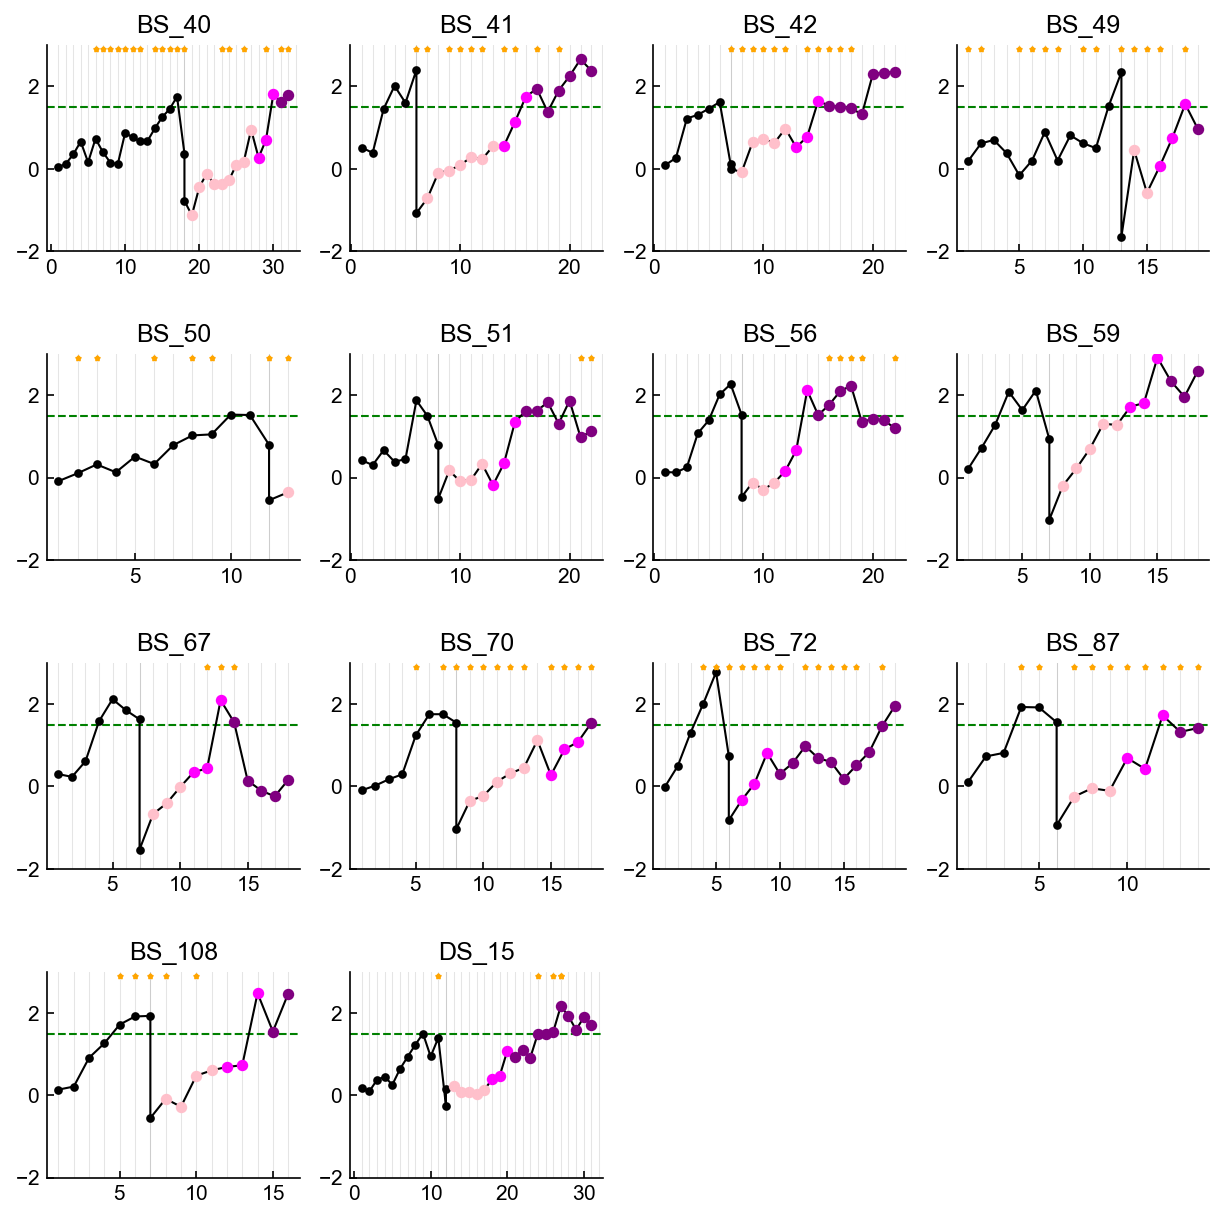

In [19]:
filename = os.path.join('C:\\\\Users','insan','Desktop','DataForJMT.csv')
#filename = os.path.join('C:\\\\Users','4thgr','Desktop','DataForJMT.csv')
csv = pd.read_csv(filename)

plot=True
if plot:
    fig = plt.figure(figsize=(10,10))
    gs = fig.add_gridspec(4,4,hspace=0.5)
    axs = [plt.subplot(gs[i,j]) for i,j in product(range(4),range(4))]
    plt.delaxes(axs[14])
    plt.delaxes(axs[15])

threeDayPhases = dict()

for animalidx,animal in enumerate(animals):
    threeDayPhases[animal] = SimpleNamespace()
    print(animal)
    
    condname = 'd\' ' + animal
    pc_condname = 'Percent correct ' + animal
    days = np.array(list(csv['Day']))
    cond = csv[condname]
    cond_pc = csv[pc_condname]
    
    #Correct for double reversal days
    for idx,day in enumerate(days):
        if day > animals[animal].reversal:
            days[idx] = day-1
    days = np.array(days,dtype=int)
    
    if animal in ['BS_50']:
        threeDayPhases[animal].maxSlope = []
        threeDayPhases[animal].postSlope = []
        threeDayPhases[animal].preSlope = days[animals[animal].reversal+1 : len(days)-1]
    else:

        #Make relative to reversal
        #days = days - animals[animal].reversal

        max_three_day_slope = -np.Inf
        max_slope_idx = np.nan
        for idx,day in enumerate(days):
            #Skip prereversal and switch days
            if day <= animals[animal].reversal:
                continue
            #Cut off before running over the end
            if idx+2 >= len(days):
                break

            slope = cond[idx+2] - cond[idx]

            if slope >= max_three_day_slope:
                max_three_day_slope = slope
                max_slope_idx = idx

        #Save out results
        days_involved = days[max_slope_idx:(max_slope_idx+3)]

        threeDayPhases[animal].maxSlope = days_involved
        threeDayPhases[animal].preSlope = days[animals[animal].reversal : days_involved[0]]#days_involved - 3
        threeDayPhases[animal].postSlope = days[days_involved[2]+1 : len(days)-1]#days_involved + 3

        threeDayPhases[animal].preSlope = threeDayPhases[animal].preSlope[    np.greater(threeDayPhases[animal].preSlope    ,    animals[animal].reversal)    ]
        maxDay = np.max(days)
        threeDayPhases[animal].postSlope = threeDayPhases[animal].postSlope[    np.less_equal(threeDayPhases[animal].postSlope    ,    maxDay)    ]
    
    
    if plot:
        ax = axs[animalidx]    
        #All Days no color
        ax.plot(days,cond,color='k',lw=1)
        ax.scatter(days,cond,color='k',s=10,zorder=9)
        
        days_involved = days[max_slope_idx:(max_slope_idx+3)]
        conds_involved = cond[max_slope_idx:(max_slope_idx+3)]
        
        ax.scatter(days[threeDayPhases[animal].maxSlope],cond[threeDayPhases[animal].maxSlope],color='magenta',s=20,zorder=10)
        ax.scatter(days[threeDayPhases[animal].preSlope],cond[threeDayPhases[animal].preSlope],color='pink',s=20,zorder=10)
        ax.scatter(days[threeDayPhases[animal].postSlope],cond[threeDayPhases[animal].postSlope],color='purple',s=20,zorder=10)
        
        #switch = np.equal(days,animals[animal].reversal)
        #ax.scatter(days[switch],cond[switch],color='b',s=20,zorder=10)

        xlims = ax.get_xlim()
        ax.plot(xlims,[1.5,1.5],c='g',linestyle='--',lw=1,zorder=-10)
        ax.set_xlim(xlims)
        ax.set_ylim([-2,3])
        
        days_recorded = training_days_recorded[animal]
        ax.scatter(days_recorded,np.ones_like(days_recorded)*2.9,s=5,marker='*',color='orange',zorder=11)

        ax.set_title(animal)
        
        for day in days:
            ax.axvline(day,color='k',alpha=0.1,zorder=-11,lw=0.5)

fig.text(0.075, 0.5, 'Behavioral performance (d\')', ha='center', va='center', rotation='vertical',fontsize=20)
fig.text(0.5,0.075, 'Day of training', ha='center', va='center', rotation='horizontal',fontsize=20)

if plot:
    plt.savefig(os.path.join('D:\\\\TempFigures','Three days max slope.pdf'),transparent=False,facecolor="white")
    pass

In [629]:
data_for_badr = np.array([list(sessionIDs),list(clusters),regions,accuracies,FRmods,EILphases,task_encoders],dtype='object').T
labels_for_badr = ['Session IDs','Cell IDs','Regions','Decoding accuracies','FR modulations','Learning phases','Task encoders']

df_for_badr = pd.DataFrame(data=data_for_badr,columns=labels_for_badr)
df_for_badr.to_csv('C:\\Users\\insan\\Desktop\\DataForBadr.csv')
print(df_for_badr)

             Session IDs Cell IDs Regions Decoding accuracies FR modulations  \
0     BS_108_1_AC.pickle        2      AC            0.535836       8.036952   
1     BS_108_1_AC.pickle        8      AC            0.683861      17.689631   
2     BS_108_1_AC.pickle        9      AC            0.610038      12.874043   
3     BS_108_1_AC.pickle       14      AC            0.555767       8.340807   
4     BS_108_1_AC.pickle       34      AC            0.643253      11.496173   
...                  ...      ...     ...                 ...            ...   
5796  DS_22_21_AC.pickle       68      AC            0.758587       6.844444   
5797  DS_22_21_AC.pickle       70      AC            0.625458       1.763085   
5798  DS_22_21_AC.pickle       77      AC             0.63543       1.866667   
5799  DS_22_21_AC.pickle       79      AC            0.663829        1.24031   
5800  DS_22_21_AC.pickle       81      AC            0.699509       1.879433   

     Learning phases Task encoders  
0 

# Rat Weighted Accuracy vs Empirical 2019

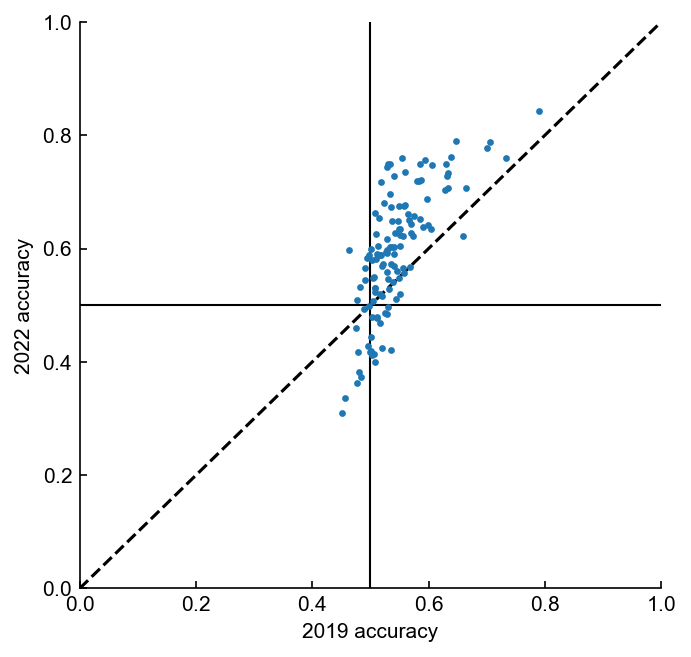

In [58]:
sig = np.less_equal(pvals,0.05/len(pvals))
fig,ax = plt.subplots(figsize=(5,5))
ax.scatter(np.array(empirical_waccuracy)[sig],np.array(waccuracies)[sig],s=5)
ax.set_ylabel('2022 accuracy')
ax.set_xlabel('2019 accuracy')
ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.plot([0,1],[0,1],c='k',linestyle='--',zorder=-10)
ax.plot([0.5,0.5],[0,1],linestyle='-',zorder=-11,c='k',lw=1)
ax.plot([0,1],[0.5,0.5],linestyle='-',zorder=-11,c='k',lw=1)

#n = 119
fig.savefig(os.path.join('C:\\Users\\insan\\Desktop\\weighted 2019 to 2022.png'))

# Rat Accuracy vs Empirical 2019

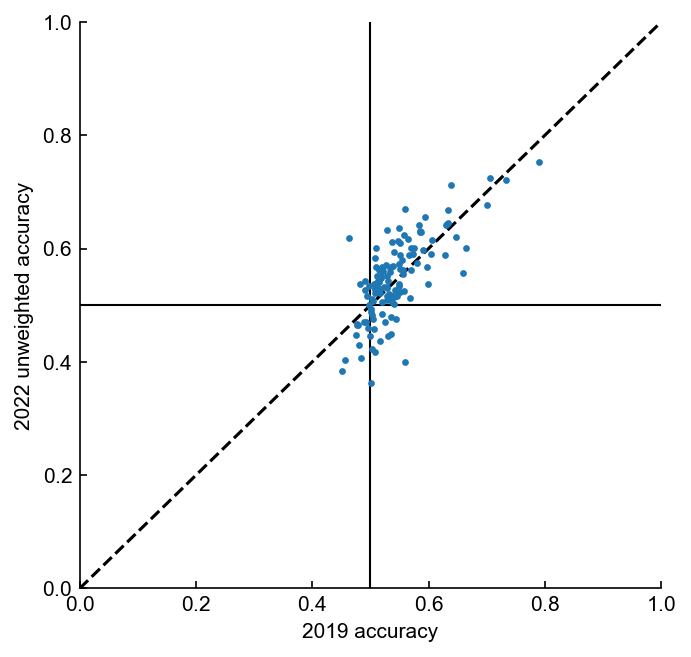

In [59]:
sig = np.less_equal(pvals,0.05/len(pvals))
fig,ax = plt.subplots(figsize=(5,5))
ax.scatter(np.array(empirical_waccuracy)[sig],np.array(accuracies)[sig],s=5)
ax.set_ylabel('2022 unweighted accuracy')
ax.set_xlabel('2019 accuracy')
ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.plot([0,1],[0,1],c='k',linestyle='--',zorder=-10)
ax.plot([0.5,0.5],[0,1],linestyle='-',zorder=-11,c='k',lw=1)
ax.plot([0,1],[0.5,0.5],linestyle='-',zorder=-11,c='k',lw=1)

#n = 119
fig.savefig(os.path.join('C:\\Users\\insan\\Desktop\\unweighted 2019 to 2022.png'))

# Rat Weighted vs Unweighted Accuracy

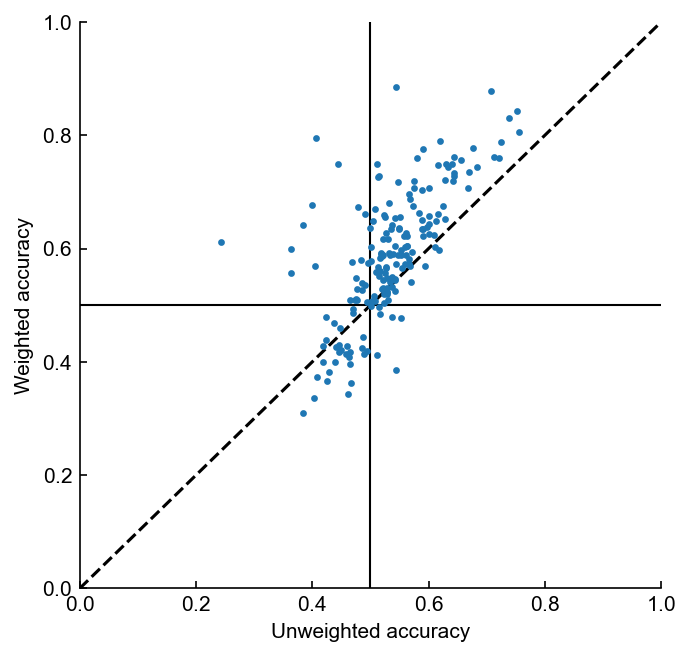

In [60]:
sig = np.less_equal(pvals,0.05/len(pvals))
#sig = [True] * len(pvals)
fig,ax = plt.subplots(figsize=(5,5))
ax.scatter(np.array(accuracies)[sig],np.array(waccuracies)[sig],s=5)
ax.set_ylabel('Weighted accuracy')
ax.set_xlabel('Unweighted accuracy')
ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.plot([0,1],[0,1],c='k',linestyle='--',zorder=-10)
ax.plot([0.5,0.5],[0,1],linestyle='-',zorder=-11,c='k',lw=1)
ax.plot([0,1],[0.5,0.5],linestyle='-',zorder=-11,c='k',lw=1)

#n = 285
fig.savefig(os.path.join('C:\\Users\\insan\\Desktop\\unweighted to weighted.png'))

(0.0, 0.1)

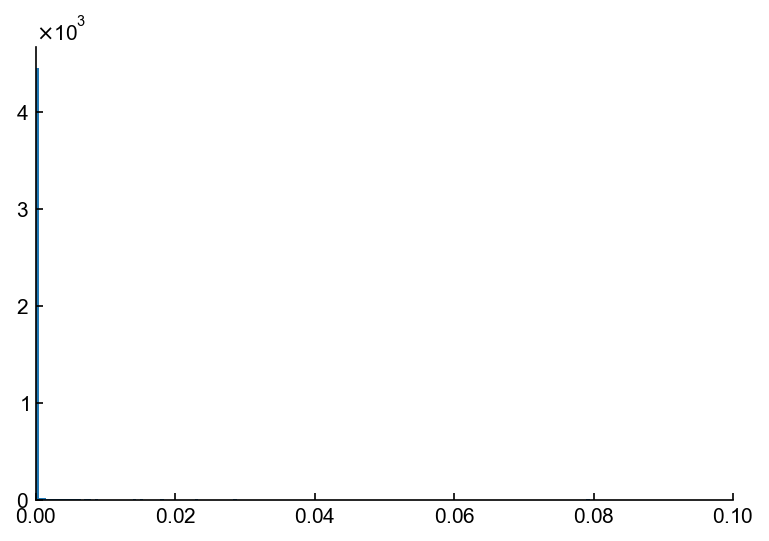

In [21]:
plt.hist(pvals,bins=1000)
plt.xlim([0,0.1])

# Run Calculations on Mouse Data

In [120]:
categories = 'stimulus'

In [139]:
directory = 'D:\\Analysis_Cache'

sessionIDs = []
clusters = []
accuracies = []
accuracies_std = []
accuracies_sem = []
waccuracies = []
waccuracies_std = []
waccuracies_sem = []
caccuracies = []
caccuracies_std = []
caccuracies_sem = []
pvals = []
repetitions = []

reps = 1000

sessions = os.listdir(directory)
for session in tqdm(sessions):
    sessionfile = ilep.loadSessionCached(directory,session)
    try:
        for clust in sessionfile.clusters.good:
            a,astd,asem,wa,wastd,wasem,ca,castd,casem,pval = ilep.CalculateClusterAccuracy(sessionfile,clust,reps=reps,categories='stimulus')
            accuracies.append(a)
            accuracies_std.append(astd)
            accuracies_sem.append(asem)
            
            waccuracies.append(wa)
            waccuracies_std.append(wastd)
            waccuracies_sem.append(wasem)
            
            caccuracies.append(ca)
            caccuracies_std.append(castd)
            caccuracies_sem.append(casem)
            pvals.append(pval)
            
            sessionIDs.append(session)
            clusters.append(clust)
            repetitions.append(reps)
    except Exception as e:
        print('failure loading '+ilep.generateDateString(sessionfile))
        #raise e
pass

################################ SAVE DATA TO DISK ############################################
        
data = np.column_stack([sessionIDs,clusters,accuracies,accuracies_std,accuracies_sem,waccuracies,waccuracies_std,waccuracies_sem,caccuracies,caccuracies_std,caccuracies_sem,pvals])
labels = ['sessions','clusters','accuracies','accuracies_std','accuracies_sem','waccuracies','waccuracies_std','waccuracies_sem','caccuracies','caccuracies_std','caccuracies_sem','pvals']
df = pd.DataFrame(data=data, columns=labels)
print(df)
df.to_csv('D:\\MouseData'+categories+'DecodingCached '+str(datetime.now())+'.csv')

  4%|▍         | 15/344 [1:38:31<35:43:27, 390.90s/it]

failure loading BS_113_1_AC_4-6-2022


  5%|▍         | 16/344 [2:07:59<62:14:57, 683.22s/it]

failure loading BS_113_1_M2_4-6-2022


  6%|▋         | 22/344 [2:50:36<39:21:41, 440.07s/it]

failure loading BS_113_4_M2_4-12-2022


  8%|▊         | 28/344 [3:29:22<33:21:32, 380.04s/it]

failure loading BS_113_7_M2_4-15-2022


 13%|█▎        | 45/344 [5:06:50<18:30:46, 222.90s/it]

failure loading BS_33_1_AC_7-28-2021


 16%|█▌        | 55/344 [6:31:52<34:35:35, 430.92s/it]

failure loading BS_33_6_AC_8-4-2021


 20%|██        | 69/344 [9:56:26<36:57:47, 483.88s/it]  

failure loading BS_40_14_AC_8-23-2021


 23%|██▎       | 79/344 [11:08:19<22:45:41, 309.21s/it]

failure loading BS_40_2_AC_8-5-2021


 24%|██▎       | 81/344 [11:27:12<29:38:54, 405.83s/it]

failure loading BS_40_3_AC_8-6-2021


 24%|██▍       | 82/344 [11:31:26<26:13:39, 360.38s/it]

failure loading BS_40_3_M2_8-6-2021


 25%|██▌       | 87/344 [12:26:59<61:19:38, 859.06s/it]

failure loading BS_40_6_M2_8-11-2021


 28%|██▊       | 96/344 [13:09:09<26:59:41, 391.86s/it]

failure loading BS_41_1_AC_8-5-2021


 33%|███▎      | 113/344 [16:40:47<21:33:54, 336.08s/it] 

failure loading BS_42_11_AC_8-23-2021


 33%|███▎      | 114/344 [16:42:28<16:57:42, 265.49s/it]

failure loading BS_42_11_M2_8-23-2021


 34%|███▎      | 116/344 [16:53:32<20:13:44, 319.41s/it]

failure loading BS_42_1_M2_8-6-2021


 34%|███▍      | 117/344 [17:05:46<27:58:55, 443.77s/it]

failure loading BS_42_2_AC_8-9-2021


 35%|███▍      | 119/344 [17:42:44<42:50:34, 685.49s/it]

failure loading BS_42_3_AC_8-10-2021


 38%|███▊      | 130/344 [20:00:41<31:01:02, 521.79s/it] 

failure loading BS_42_8_M2_8-18-2021


 41%|████▏     | 142/344 [21:16:22<40:49:06, 727.46s/it]

failure loading BS_49_1_AC_8-31-2021


 43%|████▎     | 148/344 [21:45:51<13:37:34, 250.28s/it]

failure loading BS_49_5_AC_9-8-2021


 49%|████▉     | 168/344 [22:59:15<14:35:19, 298.41s/it]

failure loading BS_50_7_M2_9-20-2021


 58%|█████▊    | 200/344 [25:21:24<7:07:37, 178.18s/it] 

failure loading BS_70_13_AC_12-9-2021


 66%|██████▋   | 228/344 [28:11:21<7:39:27, 237.65s/it] 

failure loading BS_72_1_M2_11-23-2021


 68%|██████▊   | 235/344 [29:07:33<13:59:39, 462.20s/it]

failure loading BS_72_5_AC_11-30-2021


 69%|██████▉   | 237/344 [29:09:23<7:27:41, 251.04s/it] 

failure loading BS_72_6_AC_12-1-2021


 76%|███████▌  | 260/344 [30:38:55<2:35:56, 111.38s/it] 

failure loading BS_78_1_M2_12-9-2021


 80%|███████▉  | 274/344 [31:16:44<3:01:29, 155.56s/it]

failure loading BS_83_2_M2_1-26-2022


 82%|████████▏ | 281/344 [32:03:53<9:51:34, 563.40s/it] 

failure loading BS_83_6_AC_2-2-2022


 83%|████████▎ | 285/344 [32:24:48<6:06:25, 372.63s/it]

failure loading BS_83_8_AC_2-9-2022


 84%|████████▎ | 288/344 [33:31:32<14:11:49, 912.67s/it] 

failure loading BS_83_9_M2_2-10-2022


 86%|████████▌ | 295/344 [34:22:21<5:47:13, 425.18s/it] 

failure loading BS_85_13_AC_2-8-2022


 87%|████████▋ | 300/344 [34:59:11<4:25:16, 361.73s/it]

failure loading BS_85_2_AC_1-24-2022


 88%|████████▊ | 301/344 [35:02:55<3:49:29, 320.21s/it]

failure loading BS_85_2_M2_1-24-2022


 90%|████████▉ | 308/344 [35:16:16<1:33:57, 156.60s/it]

failure loading BS_85_6_M2_1-28-2022


 94%|█████████▍| 323/344 [37:14:23<1:42:36, 293.17s/it]

failure loading BS_87_3_M2_1-28-2022


 94%|█████████▍| 324/344 [37:29:59<2:42:00, 486.01s/it]

failure loading BS_87_4_AC_1-31-2022


 96%|█████████▌| 329/344 [38:05:20<1:32:08, 368.57s/it]

failure loading BS_87_6_M2_2-2-2022
failure loading BS_87_7_AC_2-3-2022


100%|██████████| 344/344 [39:57:42<00:00, 418.21s/it]  


# Accuracy vs Control

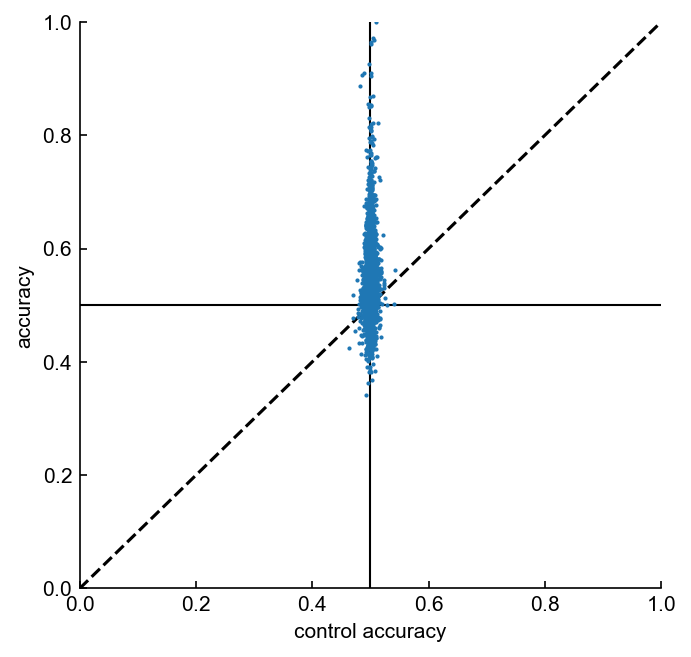

In [11]:
criterion = np.full(len(sessionIDs),True)
fig,ax = plt.subplots(figsize=(5,5))
ax.scatter(np.array(caccuracies)[criterion],np.array(accuracies)[criterion],s=1)
ax.set_ylabel('accuracy')
ax.set_xlabel('control accuracy')
ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.plot([0,1],[0,1],c='k',linestyle='--',zorder=-10)
ax.plot([0.5,0.5],[0,1],linestyle='-',zorder=-11,c='k',lw=1)
ax.plot([0,1],[0.5,0.5],linestyle='-',zorder=-11,c='k',lw=1)
plt.savefig(os.path.join('D:\\Figures','Decoding Figures',categories,'mouse control_accuracy.png'))

# Accuracy vs Chance

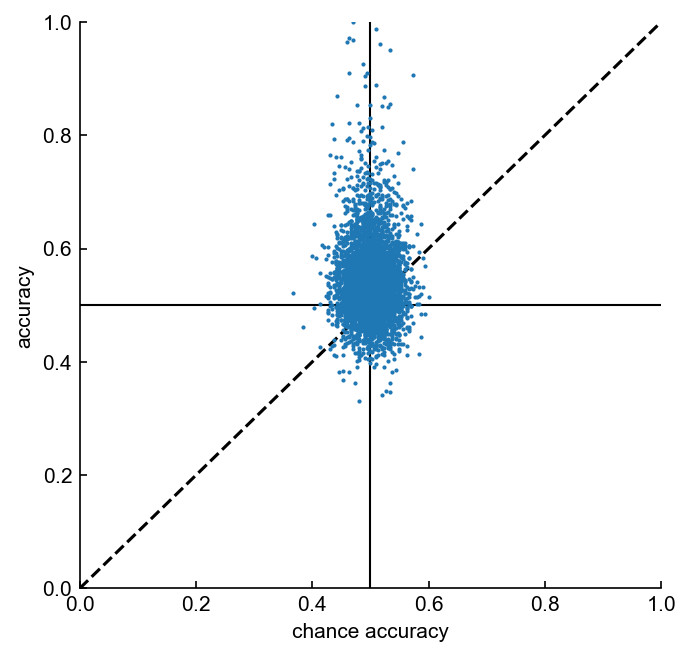

In [9]:
criterion = np.full(len(sessionIDs),True)
fig,ax = plt.subplots(figsize=(5,5))
ax.scatter(np.array(chanceresults)[criterion],np.array(accuracies)[criterion],s=1)
ax.set_ylabel('accuracy')
ax.set_xlabel('chance accuracy')
ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.plot([0,1],[0,1],c='k',linestyle='--',zorder=-10)
ax.plot([0.5,0.5],[0,1],linestyle='-',zorder=-11,c='k',lw=1)
ax.plot([0,1],[0.5,0.5],linestyle='-',zorder=-11,c='k',lw=1)
plt.savefig(os.path.join('D:\\Figures','Decoding Figures',categories,'mouse chance_accuracy.png'))

# Significant Accuracy vs Control

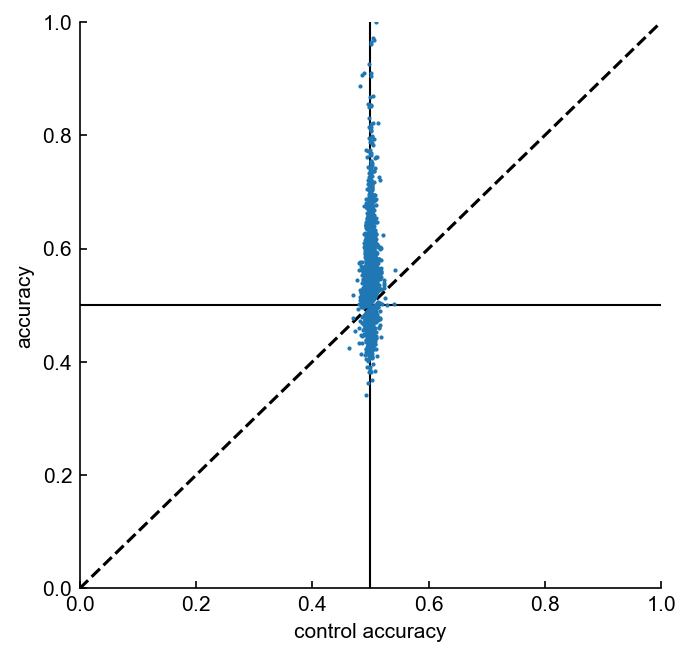

In [10]:
sig = np.less_equal(pvals,0.05/len(pvals))
criterion = sig
fig,ax = plt.subplots(figsize=(5,5))
ax.scatter(np.array(caccuracies)[criterion],np.array(accuracies)[criterion],s=1)
ax.set_ylabel('accuracy')
ax.set_xlabel('control accuracy')
ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.plot([0,1],[0,1],c='k',linestyle='--',zorder=-10)
ax.plot([0.5,0.5],[0,1],linestyle='-',zorder=-11,c='k',lw=1)
ax.plot([0,1],[0.5,0.5],linestyle='-',zorder=-11,c='k',lw=1)
plt.savefig(os.path.join('D:\\Figures','Decoding Figures',categories,'mouse significant control_accuracy.png'))

# Accuracy vs Control by region

4858


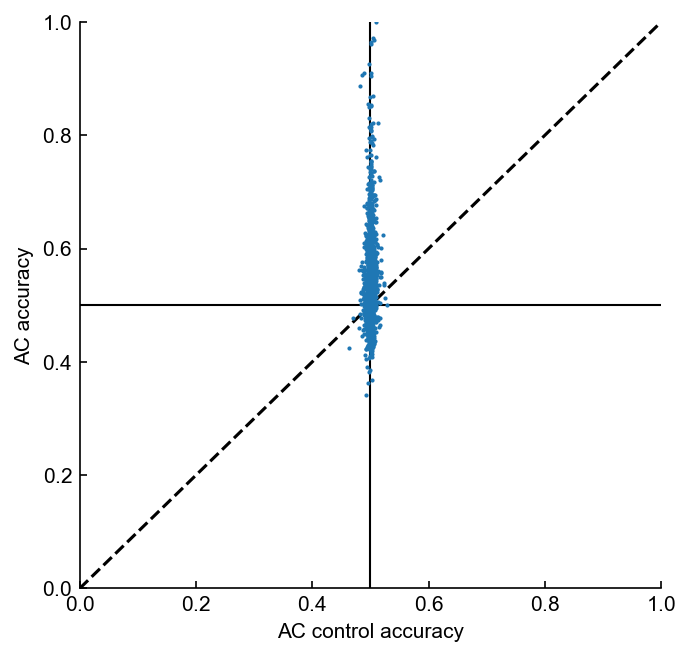

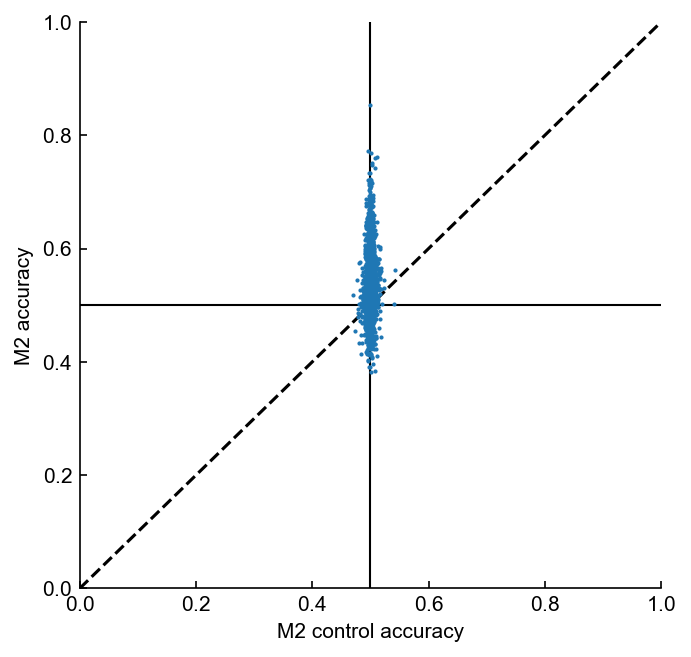

In [11]:
reg = np.char.equal(regions,'AC')
criterion = reg
print(len(regions))
fig,ax = plt.subplots(figsize=(5,5))
ax.scatter(np.array(caccuracies)[criterion],np.array(accuracies)[criterion],s=1)
ax.set_ylabel('AC accuracy')
ax.set_xlabel('AC control accuracy')
ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.plot([0,1],[0,1],c='k',linestyle='--',zorder=-10)
ax.plot([0.5,0.5],[0,1],linestyle='-',zorder=-11,c='k',lw=1)
ax.plot([0,1],[0.5,0.5],linestyle='-',zorder=-11,c='k',lw=1)
plt.savefig(os.path.join('D:\\Figures','Decoding Figures',categories,'AC mouse control_accuracy.png'))

reg = np.char.equal(regions,'M2')
criterion = reg
fig,ax = plt.subplots(figsize=(5,5))
ax.scatter(np.array(caccuracies)[criterion],np.array(accuracies)[criterion],s=1)
ax.set_ylabel('M2 accuracy')
ax.set_xlabel('M2 control accuracy')
ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.plot([0,1],[0,1],c='k',linestyle='--',zorder=-10)
ax.plot([0.5,0.5],[0,1],linestyle='-',zorder=-11,c='k',lw=1)
ax.plot([0,1],[0.5,0.5],linestyle='-',zorder=-11,c='k',lw=1)
plt.savefig(os.path.join('D:\\Figures','Decoding Figures',categories,'M2 mouse control_accuracy.png'))

# Significant Accuracy vs Control by region

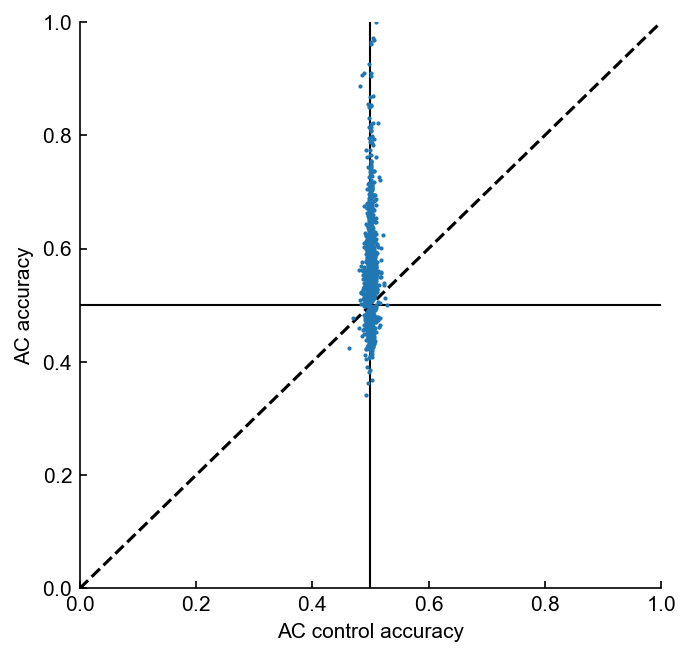

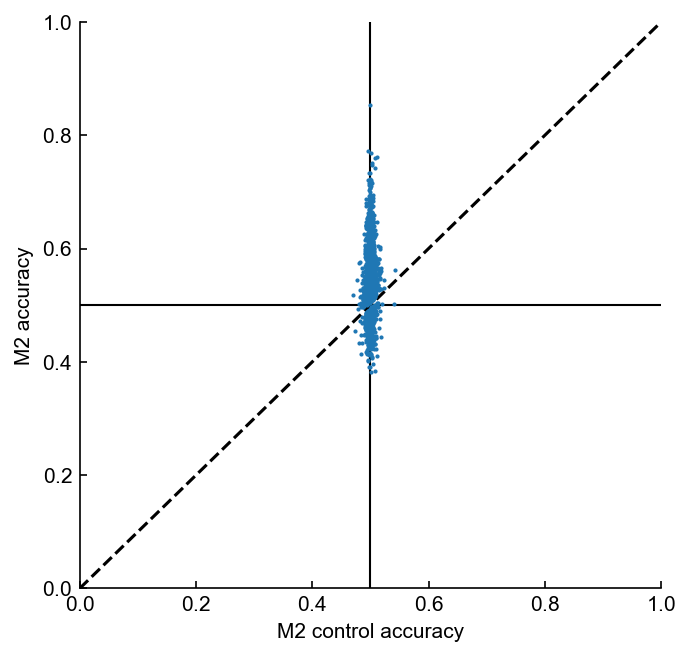

In [12]:
sig = np.less_equal(pvals,0.05/len(pvals))
reg = np.char.equal(regions,'AC')
criterion = np.logical_and(sig,reg)
fig,ax = plt.subplots(figsize=(5,5))
ax.scatter(np.array(caccuracies)[criterion],np.array(accuracies)[criterion],s=1)
ax.set_ylabel('AC accuracy')
ax.set_xlabel('AC control accuracy')
ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.plot([0,1],[0,1],c='k',linestyle='--',zorder=-10)
ax.plot([0.5,0.5],[0,1],linestyle='-',zorder=-11,c='k',lw=1)
ax.plot([0,1],[0.5,0.5],linestyle='-',zorder=-11,c='k',lw=1)
plt.savefig(os.path.join('D:\\Figures','Decoding Figures',categories,'AC mouse significant control_accuracy.png'))

sig = np.less_equal(pvals,0.05/len(pvals))
reg = np.char.equal(regions,'M2')
criterion = np.logical_and(sig,reg)
fig,ax = plt.subplots(figsize=(5,5))
ax.scatter(np.array(caccuracies)[criterion],np.array(accuracies)[criterion],s=1)
ax.set_ylabel('M2 accuracy')
ax.set_xlabel('M2 control accuracy')
ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.plot([0,1],[0,1],c='k',linestyle='--',zorder=-10)
ax.plot([0.5,0.5],[0,1],linestyle='-',zorder=-11,c='k',lw=1)
ax.plot([0,1],[0.5,0.5],linestyle='-',zorder=-11,c='k',lw=1)
plt.savefig(os.path.join('D:\\Figures','Decoding Figures',categories,'M2 mouse significant control_accuracy.png'))

# Accuracy vs FR Modulation

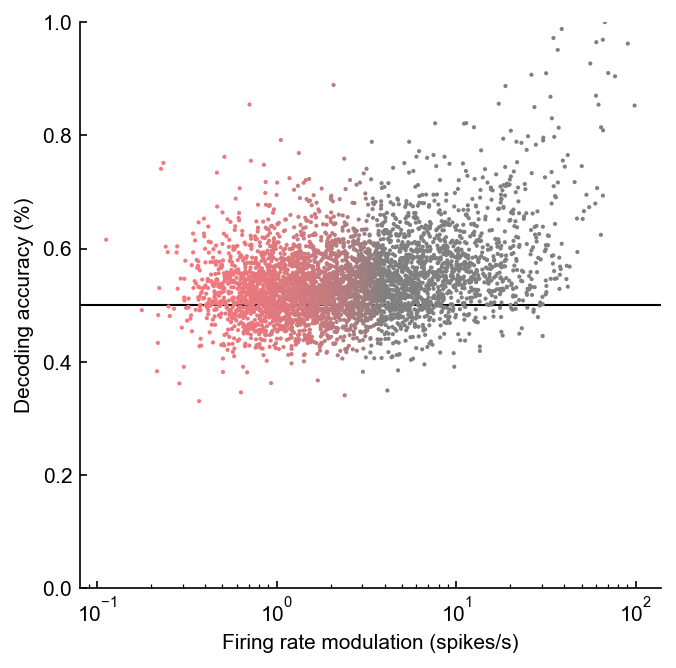

In [7]:
criterion = np.full(len(sessionIDs),True)
fig,ax = plt.subplots(figsize=(5,5))
ax.scatter(np.array(FRmods)[criterion],np.array(accuracies)[criterion],s=1,c=colors[criterion])
ax.set_xscale('log',base=10)
ax.set_xlabel('Firing rate modulation (spikes/s)')
ax.set_ylabel('Decoding accuracy (%)')
ax.set_ylim([0,1])
xlims = ax.get_xlim()
ax.plot(xlims,[0.5,0.5],linestyle='-',zorder=-11,c='k',lw=1)
ax.set_xlim(xlims)
plt.savefig(os.path.join('D:\\Figures','Decoding Figures',categories,'mouse FRmod_accuracy.png'))

# Significant Accuracy vs FR Modulation

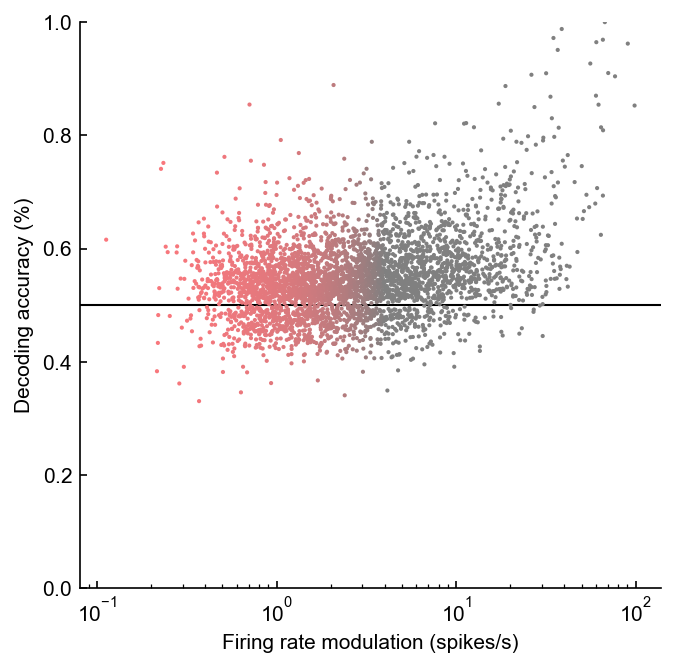

In [15]:
sig = np.less_equal(pvals,0.05/len(pvals))
criterion = sig
fig,ax = plt.subplots(figsize=(5,5))
ax.scatter(np.array(FRmods)[criterion],np.array(accuracies)[criterion],s=1,c=colors[criterion])
ax.set_xscale('log',base=10)
ax.set_xlabel('Firing rate modulation (spikes/s)')
ax.set_ylabel('Decoding accuracy (%)')
ax.set_ylim([0,1])
xlims = ax.get_xlim()
ax.plot(xlims,[0.5,0.5],linestyle='-',zorder=-11,c='k',lw=1)
ax.set_xlim(xlims)
plt.savefig(os.path.join('D:\\Figures','Decoding Figures',categories,'mouse significant FRmod_accuracy.png'))

# Accuracy vs FR Modulation by region

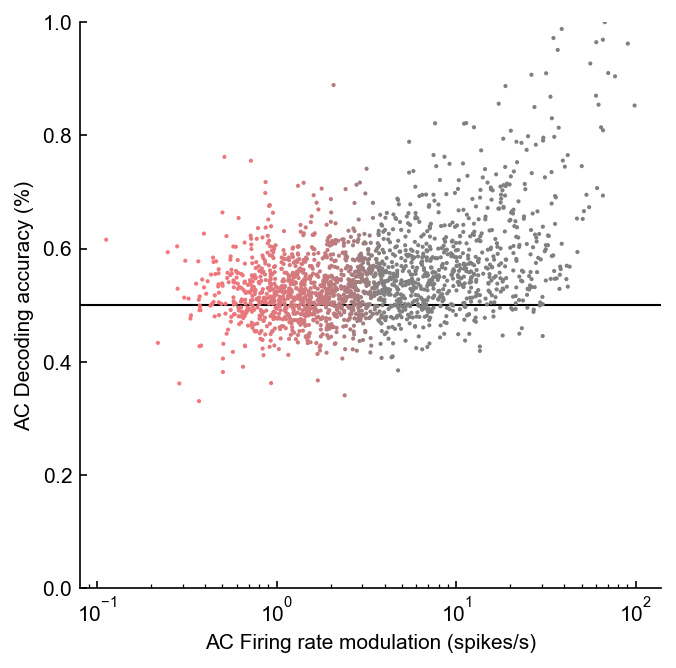

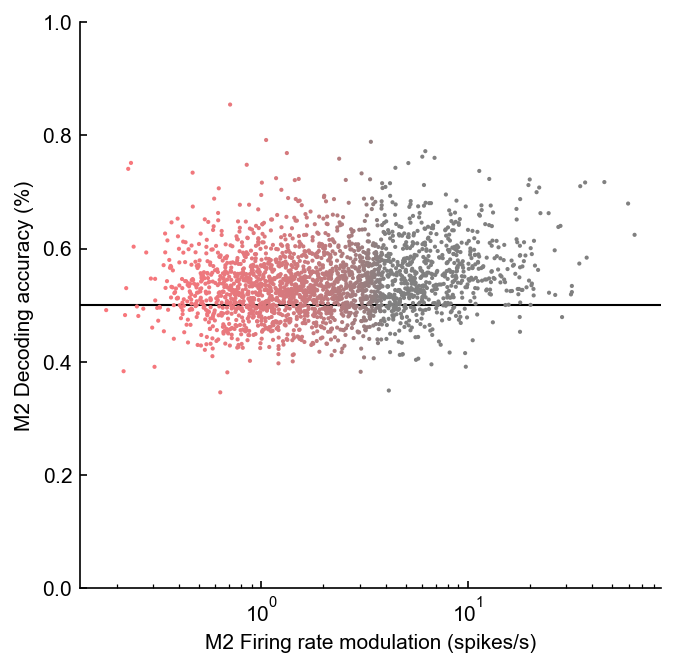

In [16]:
reg = np.char.equal(regions,'AC')
criterion = reg
fig,ax = plt.subplots(figsize=(5,5))
ax.scatter(np.array(FRmods)[criterion],np.array(accuracies)[criterion],s=1,c=colors[criterion])
ax.set_xscale('log',base=10)
ax.set_xlabel('AC Firing rate modulation (spikes/s)')
ax.set_ylabel('AC Decoding accuracy (%)')
ax.set_ylim([0,1])
xlims = ax.get_xlim()
ax.plot(xlims,[0.5,0.5],linestyle='-',zorder=-11,c='k',lw=1)
ax.set_xlim(xlims)
plt.savefig(os.path.join('D:\\Figures','Decoding Figures',categories,'AC mouse FRmod_accuracy.png'))

reg = np.char.equal(regions,'M2')
criterion = reg
fig,ax = plt.subplots(figsize=(5,5))
ax.scatter(np.array(FRmods)[criterion],np.array(accuracies)[criterion],s=1,c=colors[criterion])
ax.set_xscale('log',base=10)
ax.set_xlabel('M2 Firing rate modulation (spikes/s)')
ax.set_ylabel('M2 Decoding accuracy (%)')
ax.set_ylim([0,1])
xlims = ax.get_xlim()
ax.plot(xlims,[0.5,0.5],linestyle='-',zorder=-11,c='k',lw=1)
ax.set_xlim(xlims)
plt.savefig(os.path.join('D:\\Figures','Decoding Figures',categories,'M2 mouse FRmod_accuracy.png'))

# Accuracy vs Significant FR Modulation by region

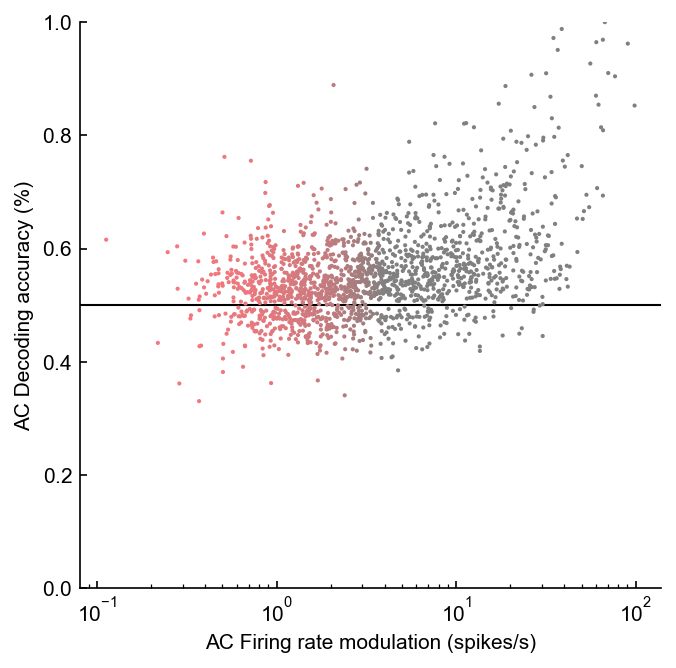

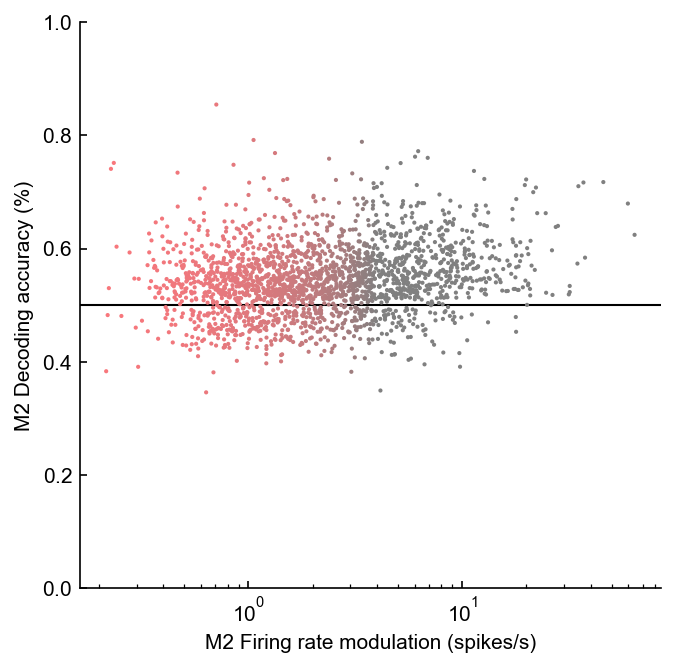

In [17]:
sig = np.less_equal(pvals,0.05/len(pvals))
reg = np.char.equal(regions,'AC')
criterion = np.logical_and(sig,reg)
fig,ax = plt.subplots(figsize=(5,5))
ax.scatter(np.array(FRmods)[criterion],np.array(accuracies)[criterion],s=1,c=colors[criterion])
ax.set_xscale('log',base=10)
ax.set_xlabel('AC Firing rate modulation (spikes/s)')
ax.set_ylabel('AC Decoding accuracy (%)')
ax.set_ylim([0,1])
xlims = ax.get_xlim()
ax.plot(xlims,[0.5,0.5],linestyle='-',zorder=-11,c='k',lw=1)
ax.set_xlim(xlims)
plt.savefig(os.path.join('D:\\Figures','Decoding Figures',categories,'AC mouse significant FRmod_accuracy.png'))

sig = np.less_equal(pvals,0.05/len(pvals))
reg = np.char.equal(regions,'M2')
criterion = np.logical_and(sig,reg)
fig,ax = plt.subplots(figsize=(5,5))
ax.scatter(np.array(FRmods)[criterion],np.array(accuracies)[criterion],s=1,c=colors[criterion])
ax.set_xscale('log',base=10)
ax.set_xlabel('M2 Firing rate modulation (spikes/s)')
ax.set_ylabel('M2 Decoding accuracy (%)')
ax.set_ylim([0,1])
xlims = ax.get_xlim()
ax.plot(xlims,[0.5,0.5],linestyle='-',zorder=-11,c='k',lw=1)
ax.set_xlim(xlims)
plt.savefig(os.path.join('D:\\Figures','Decoding Figures',categories,'M2 mouse significant FRmod_accuracy.png'))

In [48]:
post_early = []
post_int = []
post_late = []
post_early_c = []
post_int_c = []
post_late_c = []
post_early_an = []
post_int_an = []
post_late_an = []
misc = []

N_cells = 0
animalsincluded = []

for idx in tqdm(range(len(clusters))):
    if not regions[idx] == 'AC':
        continue
        
    session = sessionIDs[idx]
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    if not sessionfile.meta.animal in animalstouse:
        continue
        
    if sessionfile.meta.animal == 'BS_67' and sessionfile.meta.day_of_training >= 15:
        continue
    
    if not sessionfile.meta.task in ['reversal']:
        continue
    
    if EILphases[idx] == 'post early':
        post_early.append(accuracies[idx])
        post_early_c.append(FRmods[idx])
        post_early_an.append(sessionfile.meta.animal)
    elif EILphases[idx] == 'post int':
        post_int.append(accuracies[idx])
        post_int_c.append(FRmods[idx])
        post_int_an.append(sessionfile.meta.animal)
    elif EILphases[idx] == 'post late':
        post_late.append(accuracies[idx])
        post_late_c.append(FRmods[idx])
        post_late_an.append(sessionfile.meta.animal)
    else:
        misc.append(accuracies[idx])
        
animalsincluded = np.unique(animalsincluded)
print(np.sum(np.isfinite(post_early)))
print(np.sum(np.isfinite(post_int)))
print(np.sum(np.isfinite(post_late)))

100%|██████████| 5801/5801 [00:11<00:00, 495.80it/s] 

365
236
251


# EIL Accuracy

Early vs Intermediate: 0.2521516654705953
Intermediate vs Late : 0.08865013274966427
Early vs Late        : 0.0035760993703627397


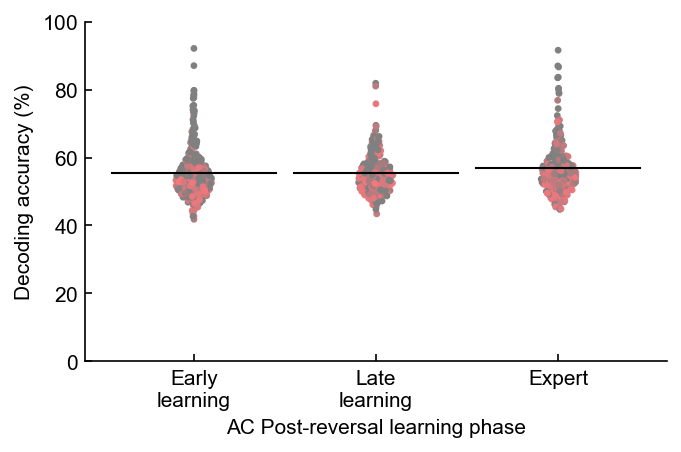

In [49]:
X = np.concatenate(([np.ones(len(post_early)),np.ones(len(post_int))*2,np.ones(len(post_late))*3]))
Y = np.concatenate((post_early,post_int,post_late))

colors = NCR_CR_cmap(np.concatenate((post_early_c,post_int_c,post_late_c))/4)

X,Y = ilep.violin(X,Y,width=0.25)

fig,ax = plt.subplots(figsize=(5,3))
ax.scatter(X,Y*100,color=colors,s=5)
ax.plot([.55,1.45],[np.nanmean(post_early)*100]*2,lw=1,color='k')
ax.plot([1.55,2.45],[np.nanmean(post_int)*100]*2,lw=1,color='k')
ax.plot([2.55,3.45],[np.nanmean(post_late)*100]*2,lw=1,color='k')

ax.set_ylim([0,100])

ax.set_xticks([1,2,3])
ax.set_xticklabels(['Early\nlearning','Late\nlearning','Expert'])
ax.set_xlabel('AC Post-reversal learning phase')
ax.set_ylabel('Decoding accuracy (%)')

print('Early vs Intermediate: '+str(mannwhitneyu(nonan(post_early),nonan(post_int)).pvalue))
print('Intermediate vs Late : '+str(mannwhitneyu(nonan(post_int),nonan(post_late)).pvalue))
print('Early vs Late        : '+str(mannwhitneyu(nonan(post_early),nonan(post_late)).pvalue))

plt.savefig(os.path.join('D:\\\\Figures','Decoding Figures','Summaries','EIL Learning Phases Accuracy.png'),transparent=False,facecolor="white")

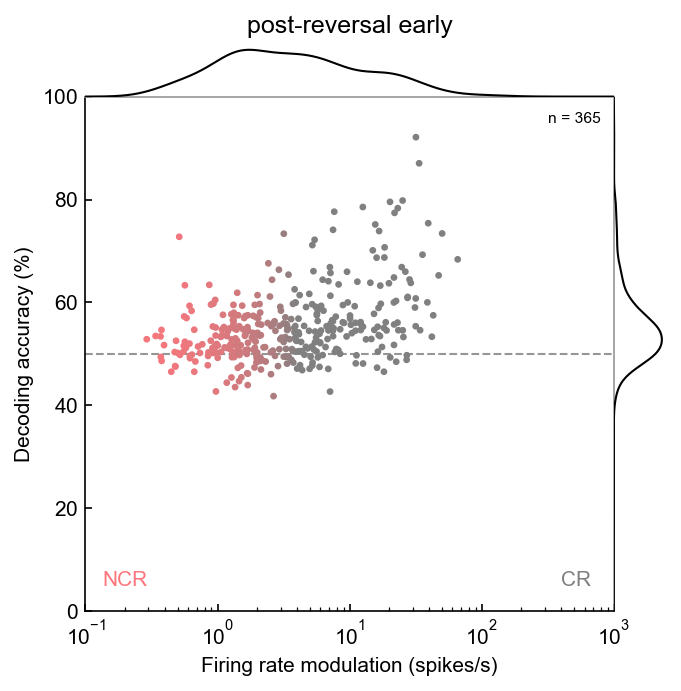

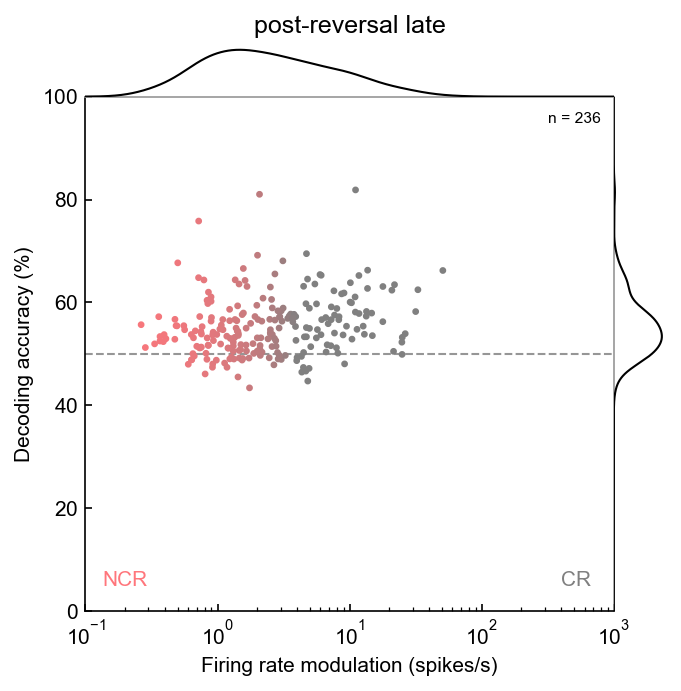

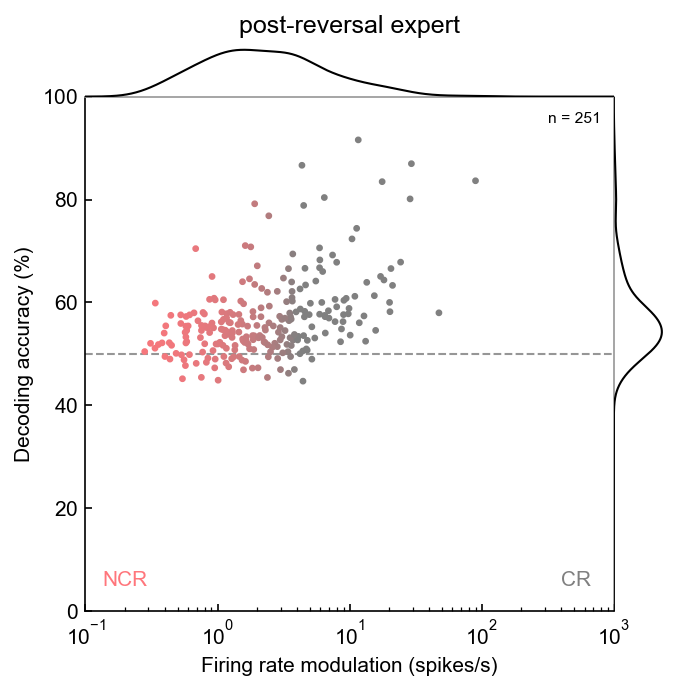

In [46]:
size = 5
#xlims = [-1,3]
xlims = [0.1,1000]
ylims = [0,100]

def plotFRDecodingDist(data,FRdata,label):
    #logFRdata = np.log10(FRdata)
    colors = NCR_CR_cmap(np.array(FRdata)/4)
    
    fig,ax = plt.subplots(figsize=(5,5))
    gs = fig.add_gridspec(2,2,height_ratios=[1,10],width_ratios=[10,1],hspace=0,wspace=0)
    ax = plt.subplot(gs[1,0])#Raster
    axv = plt.subplot(gs[1,1])#PSTH
    axh = plt.subplot(gs[0,0])#PSTH
    
    ax.scatter(FRdata,data,c=colors,s=size)
    
    #Horizontal
    ax.set_xscale('log')
    ax.set_xlabel('Firing rate modulation (spikes/s)')
    ax.set_xlim(xlims)
    ax.plot(xlims,[50,50],color=GOOD_GREY,linestyle='--',lw=1,zorder=-10)
    ax.text(10**(-0.875),5,'NCR',color=NCR_COLOR)
    ax.text(10**(2.6),5,'CR',color=CR_COLOR)
    ax.text(10**(2.5),95,'n = '+str(np.sum(np.isfinite(data))),color='k',fontsize=7.5)
    
    #Vertical
    ax.set_ylabel('Decoding accuracy (%)')
    ax.set_ylim(ylims)
    
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)
    ax.spines['top'].set_color(GOOD_GREY)
    ax.spines['right'].set_color(GOOD_GREY)
    
    #FR Modulation
    #NOTE that this is done as a linear KDE over pre-logged
    #data points. This is because the KDE needs to be done on
    #data that is already logged so that the kernel is not stretched
    #when the KDE is evaluated
    noNansFR = np.log10(FRdata[np.isfinite(FRdata)])
    KDEh = gaussian_kde(noNansFR, bw_method='scott')
    xrange = np.linspace(np.log10(xlims[0]),np.log10(xlims[1]),1000)
    yvals = KDEh.evaluate(xrange)
    
    axh.plot(xrange,yvals,color='k',lw=1)
    
    #axh.set_xscale('log')
    axh.set_xticks([])
    axh.set_xlim(np.log10(xlims))
    
    axh.set_yticks([])
    axh.set_ylim([np.min(yvals),np.max(yvals)*1.1])
    
    axh.axis('off')
    
    #Decoding Accuracy
    noNans = data[np.isfinite(data)]
    KDEv = gaussian_kde(noNans, bw_method='scott')
    yrange = np.linspace(ylims[0],ylims[1],1000)
    xvals = KDEv.evaluate(yrange)
    
    axv.plot(xvals,yrange,color='k',lw=1)
    
    axv.set_xticks([])
    axv.set_xlim([np.nanmin(xvals),np.nanmax(xvals)*1.1])
    
    axv.set_yticks([])
    axv.set_ylim(ylims)
    
    axv.axis('off')
    #axv.plot([0,0],ylims,color=GOOD_GREY,lw=2,zorder=-10)
    #
    axh.set_title(label)
    fig.savefig(os.path.join('D:\\\\Figures','Decoding Figures','FRDecoding Distributions',label+' .png'),transparent=False,facecolor="white")

labelstring = 'post-reversal early'
data = np.array(post_early)*100
FRdata = np.array(post_early_c)
plotFRDecodingDist(data,FRdata,labelstring)

labelstring = 'post-reversal late'
data = np.array(post_int)*100
FRdata = np.array(post_int_c)
plotFRDecodingDist(data,FRdata,labelstring)

labelstring = 'post-reversal expert'
data = np.array(post_late)*100
FRdata = np.array(post_late_c)
plotFRDecodingDist(data,FRdata,labelstring)

Early vs Intermediate: nan
Intermediate vs Late : nan
Early vs Late        : nan


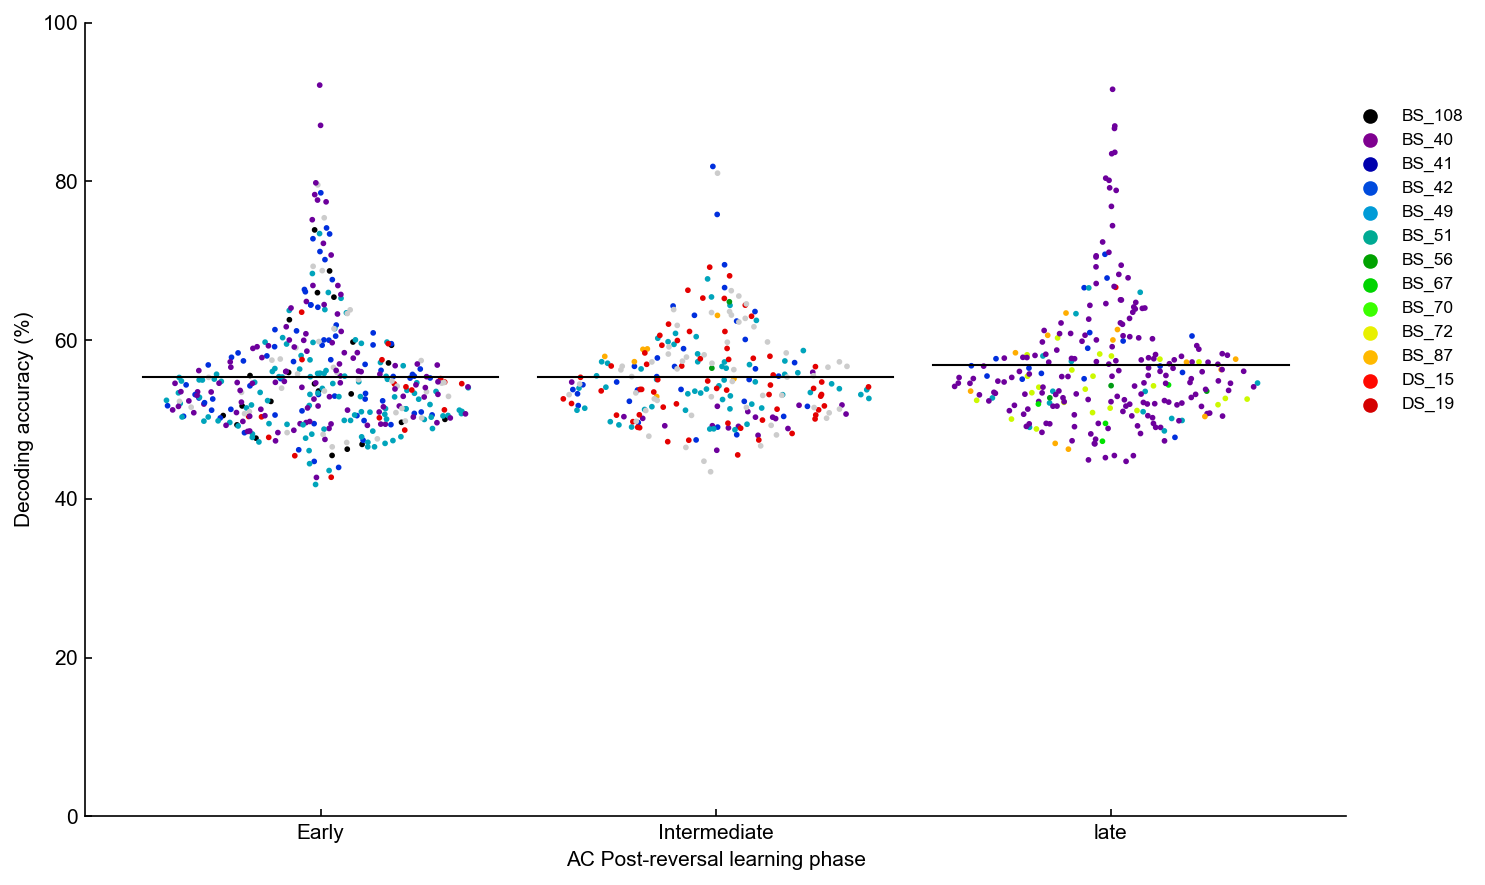

In [24]:
X = np.concatenate(([np.ones(len(post_early)),np.ones(len(post_int))*2,np.ones(len(post_late))*3]))
Y = np.concatenate((post_early,post_int,post_late))
ans = np.concatenate((post_early_an,post_int_an,post_late_an))

num_an = len(np.unique(ans))

colors = np.array([an for an in ans])
for idx,an in enumerate(np.unique(ans)):
    idxs = np.where(np.char.equal(ans,an))[0]
    colors[idxs] = np.ones(len(idxs))*idx
colors = np.array([int(c[0]) for c in colors])
colors = colors / num_an

X,Y = ilep.violin(X,Y)

fig,ax = plt.subplots(figsize=(10,6))
ax.scatter(X,Y*100,c=colors,s=3,cmap='nipy_spectral')
ax.plot([.55,1.45],[np.nanmean(post_early)*100]*2,lw=1,color='k')
ax.plot([1.55,2.45],[np.nanmean(post_int)*100]*2,lw=1,color='k')
ax.plot([2.55,3.45],[np.nanmean(post_late)*100]*2,lw=1,color='k')

for idx,an in enumerate(np.unique(ans)):
    cmap = mpl.cm.get_cmap('nipy_spectral')
    rgba = cmap(idx/num_an)
    ax.scatter([np.nan],[np.nan],color=rgba,label=an)
ax.legend(loc=[1,0.5],frameon=False)

ax.set_ylim([0,100])

ax.set_xticks([1,2,3])
ax.set_xticklabels(['Early','Intermediate','late'])
ax.set_xlabel('AC Post-reversal learning phase')
ax.set_ylabel('Decoding accuracy (%)')

print('Early vs Intermediate: '+str(mannwhitneyu(post_early,post_int).pvalue))
print('Intermediate vs Late : '+str(mannwhitneyu(post_int,post_late).pvalue))
print('Early vs Late        : '+str(mannwhitneyu(post_early,post_late).pvalue))

plt.tight_layout()
plt.savefig(os.path.join('D:\\\\Figures','Decoding Figures','Summaries','EIL Learning Phases AnimalIDs only DS.png'),transparent=False,facecolor="white")

In [50]:
preN = []
preNc = []
preE = []
preEc = []
postN = []
postNc = []
postE = []
postEc = []
misc = []

for idx in tqdm(range(len(clusters))):
    session = sessionIDs[idx]
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    if not sessionfile.meta.animal in animalstouse:
        continue
        
    if not sessionfile.meta.region in ['AC']:
        continue
        
    if sessionfile.meta.condition == 'prereversal naive':
        preN.append(accuracies[idx])
        preNc.append(FRmods[idx])
    elif sessionfile.meta.condition == 'prereversal expert':
        preE.append(accuracies[idx])
        preEc.append(FRmods[idx])
    elif sessionfile.meta.condition == 'postreversal naive':
        postN.append(accuracies[idx])
        postNc.append(FRmods[idx])
    elif sessionfile.meta.condition == 'postreversal expert':
        postE.append(accuracies[idx])
        postEc.append(FRmods[idx])
    else:
        misc.append(accuracies[idx])
        
print(np.sum(np.isfinite(preN)))
print(np.sum(np.isfinite(preE)))
print(np.sum(np.isfinite(postN)))
print(np.sum(np.isfinite(postE)))

100%|██████████| 5801/5801 [00:23<00:00, 249.70it/s]

324
125
601
251


Pre-N vs Pre-E  : 2.664512473673364e-07
Pre-N vs Post-N : 0.00020574649242175594
Pre-N vs Post-E : 3.59693379552478e-08
pre-E vs Post-N : 0.005601361897547359
pre-E vs post-E : 0.5211299032258794
post-N vs post-E: 0.006180542429476251


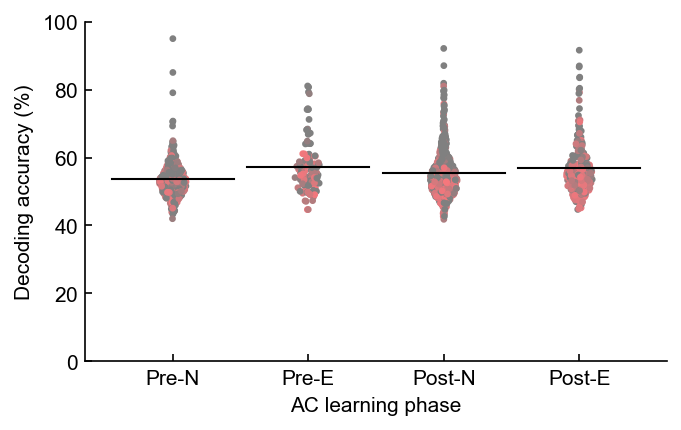

In [51]:
X = np.concatenate(([np.ones(len(preN)),np.ones(len(preE))*2,np.ones(len(postN))*3,np.ones(len(postE))*4]))
Y = np.concatenate((preN,preE,postN,postE))

colors = NCR_CR_cmap(np.concatenate((preNc,preEc,postNc,postEc))/4)

X,Y = ilep.violin(X,Y,width=0.25)

fig,ax = plt.subplots(figsize=(5,3))
ax.scatter(X,Y*100,c=colors,s=5)
ax.plot([.55,1.45],[np.nanmean(preN)*100]*2,lw=1,color='k')
ax.plot([1.55,2.45],[np.nanmean(preE)*100]*2,lw=1,color='k')
ax.plot([2.55,3.45],[np.nanmean(postN)*100]*2,lw=1,color='k')
ax.plot([3.55,4.45],[np.nanmean(postE)*100]*2,lw=1,color='k')

ax.set_ylim([0,100])

ax.set_xticks([1,2,3,4])
ax.set_xticklabels(['Pre-N','Pre-E','Post-N','Post-E'])
ax.set_xlabel('AC learning phase')
ax.set_ylabel('Decoding accuracy (%)')

print('Pre-N vs Pre-E  : '+str(mannwhitneyu(nonan(preN),nonan(preE)).pvalue))
print('Pre-N vs Post-N : '+str(mannwhitneyu(nonan(preN),nonan(postN)).pvalue))
print('Pre-N vs Post-E : '+str(mannwhitneyu(nonan(preN),nonan(postE)).pvalue))
print('pre-E vs Post-N : '+str(mannwhitneyu(nonan(preE),nonan(postN)).pvalue))
print('pre-E vs post-E : '+str(mannwhitneyu(nonan(preE),nonan(postE)).pvalue))
print('post-N vs post-E: '+str(mannwhitneyu(nonan(postN),nonan(postE)).pvalue))

plt.savefig(os.path.join('D:\\\\Figures','Decoding Figures','Summaries','PrePostNE Learning Phases Accuracy.png'),transparent=False,facecolor="white")

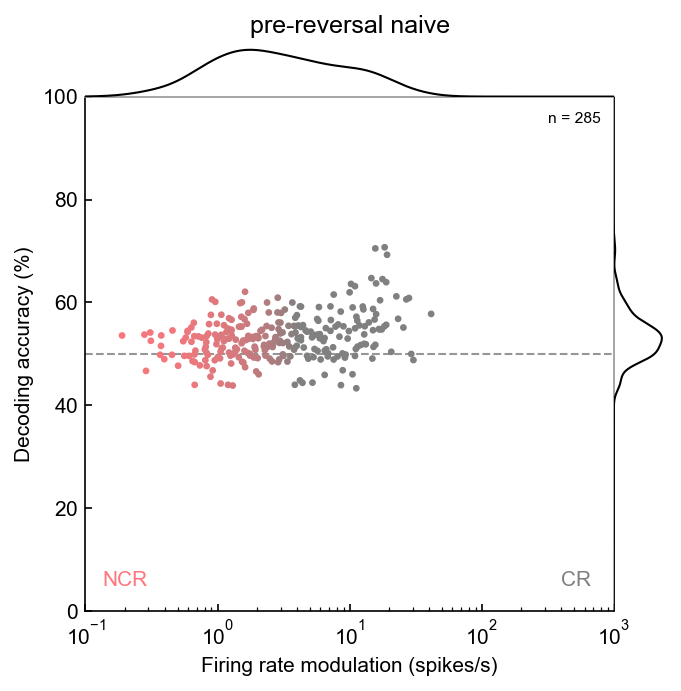

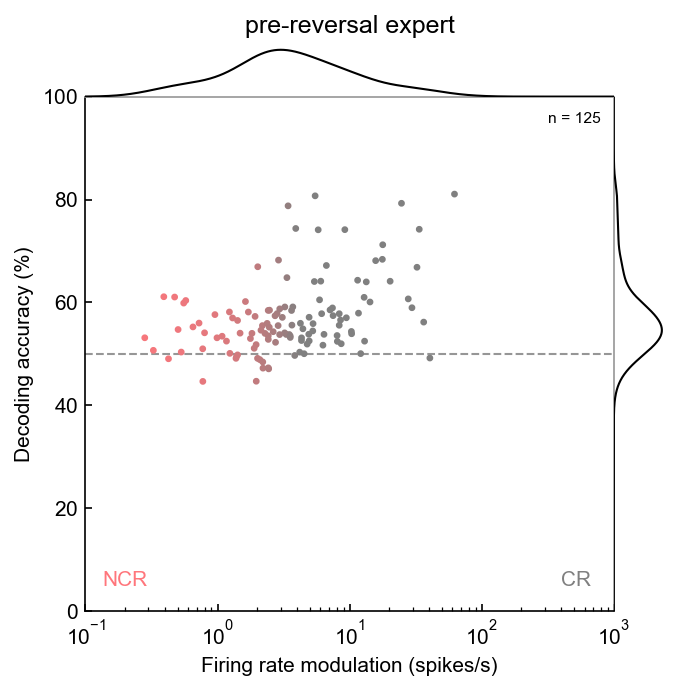

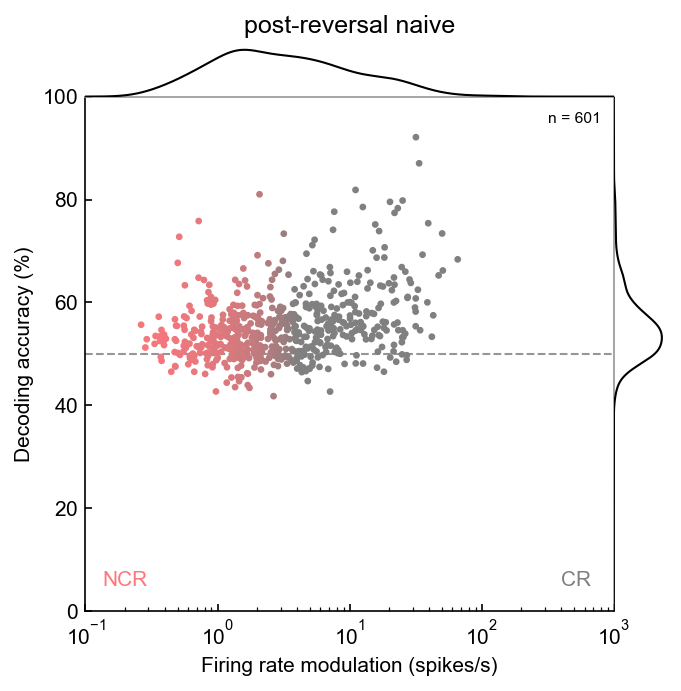

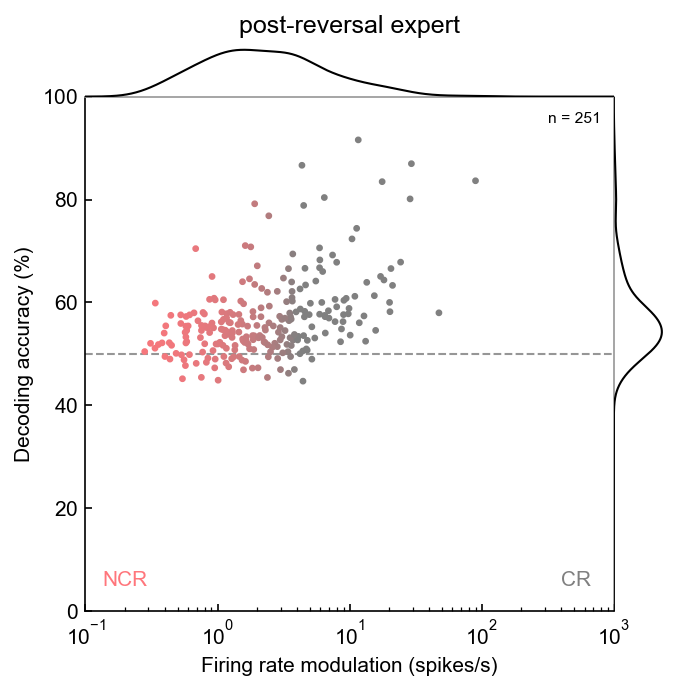

In [27]:
labelstring = 'pre-reversal naive'
data = np.array(preN)*100
FRdata = np.array(preNc)
plotFRDecodingDist(data,FRdata,labelstring)

labelstring = 'pre-reversal expert'
data = np.array(preE)*100
FRdata = np.array(preEc)
plotFRDecodingDist(data,FRdata,labelstring)

labelstring = 'post-reversal naive'
data = np.array(postN)*100
FRdata = np.array(postNc)
plotFRDecodingDist(data,FRdata,labelstring)

labelstring = 'post-reversal expert'
data = np.array(postE)*100
FRdata = np.array(postEc)
plotFRDecodingDist(data,FRdata,labelstring)

In [28]:
PERphases['BS_70']

{9: 'perseveration',
 10: 'perseveration',
 11: 'exploration',
 12: 'exploration',
 13: 'refinement',
 14: 'refinement',
 15: 'refinement',
 16: 'refinement',
 17: 'refinement',
 18: 'refinement',
 19: 'exploration',
 20: 'exploration',
 21: 'exploration',
 22: 'exploration',
 23: 'exploration',
 24: 'exploration',
 25: 'exploration',
 26: 'exploration',
 27: 'exploration',
 28: 'exploration',
 29: 'exploration',
 30: 'exploration',
 31: 'exploration',
 32: 'exploration',
 33: 'exploration',
 34: 'exploration',
 35: 'exploration',
 36: 'exploration',
 37: 'exploration',
 38: 'exploration',
 39: 'exploration',
 40: 'exploration',
 41: 'exploration',
 42: 'exploration',
 43: 'exploration',
 44: 'exploration',
 45: 'exploration',
 46: 'exploration',
 47: 'exploration',
 48: 'exploration',
 49: 'exploration'}

In [52]:
pers = []
expl = []
refi = []
misc = []
persc = []
explc = []
refic = []

for idx in tqdm(range(len(clusters))):
    session = sessionIDs[idx]
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    if not sessionfile.meta.animal in animalstouse:
        continue
        
    if not sessionfile.meta.region in ['AC']:
        continue
    
    if not sessionfile.meta.condition in ['postreversal naive','postreversal expert']:
        continue
    
    animal = sessionfile.meta.animal
    day = sessionfile.meta.day_of_training
        
    try:
        if animal in ['DS_15','DS_19']:
            refi.append(accuracies[idx])
            refic.append(FRmods[idx])
        elif PERphases[animal][day] == 'perseveration':
            pers.append(accuracies[idx])
            persc.append(FRmods[idx])
        elif PERphases[animal][day] == 'exploration':
            expl.append(accuracies[idx])
            explc.append(FRmods[idx])
        elif PERphases[animal][day] == 'refinement':
            refi.append(accuracies[idx])
            refic.append(FRmods[idx])
    except:
        print(animal)
        print(day)

print(np.sum(np.isfinite(pers)))
print(np.sum(np.isfinite(expl)))
print(np.sum(np.isfinite(refi)))

100%|██████████| 5801/5801 [00:23<00:00, 247.70it/s]

105
166
581


Perseveration vs Exploration: 0.1928495928497782
Exploration vs Refinement   : 0.9128003454647053
Perseveration vs Refinement : 0.1261908970231169


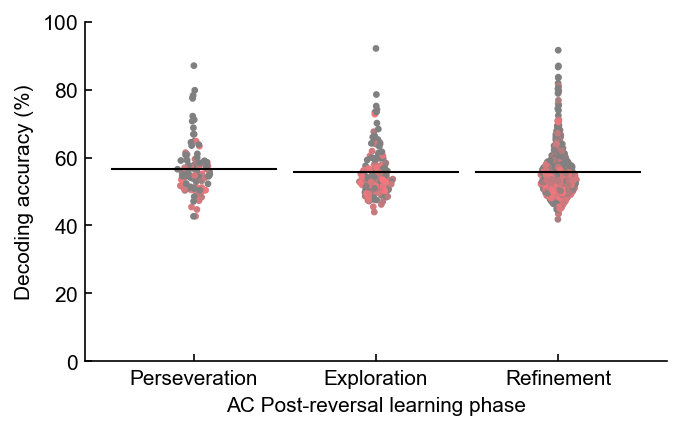

In [53]:
X = np.concatenate(([np.ones(len(pers)),np.ones(len(expl))*2,np.ones(len(refi))*3]))
Y = np.concatenate((pers,expl,refi))

colors = NCR_CR_cmap(np.concatenate((persc,explc,refic))/4)

X,Y = ilep.violin(X,Y,width=0.25)

fig,ax = plt.subplots(figsize=(5,3))
ax.scatter(X,Y*100,color=colors,s=5)
ax.plot([.55,1.45],[np.nanmean(pers)*100]*2,lw=1,color='k')
ax.plot([1.55,2.45],[np.nanmean(expl)*100]*2,lw=1,color='k')
ax.plot([2.55,3.45],[np.nanmean(refi)*100]*2,lw=1,color='k')

ax.set_ylim([0,100])

ax.set_xticks([1,2,3])
ax.set_xticklabels(['Perseveration','Exploration','Refinement'])
ax.set_xlabel('AC Post-reversal learning phase')
ax.set_ylabel('Decoding accuracy (%)')

print('Perseveration vs Exploration: '+str(mannwhitneyu(nonan(pers),nonan(expl)).pvalue))
print('Exploration vs Refinement   : '+str(mannwhitneyu(nonan(expl),nonan(refi)).pvalue))
print('Perseveration vs Refinement : '+str(mannwhitneyu(nonan(pers),nonan(refi)).pvalue))

plt.savefig(os.path.join('D:\\\\Figures','Decoding Figures','Summaries','PER Learning Phases Accuracy.png'),transparent=False,facecolor="white")

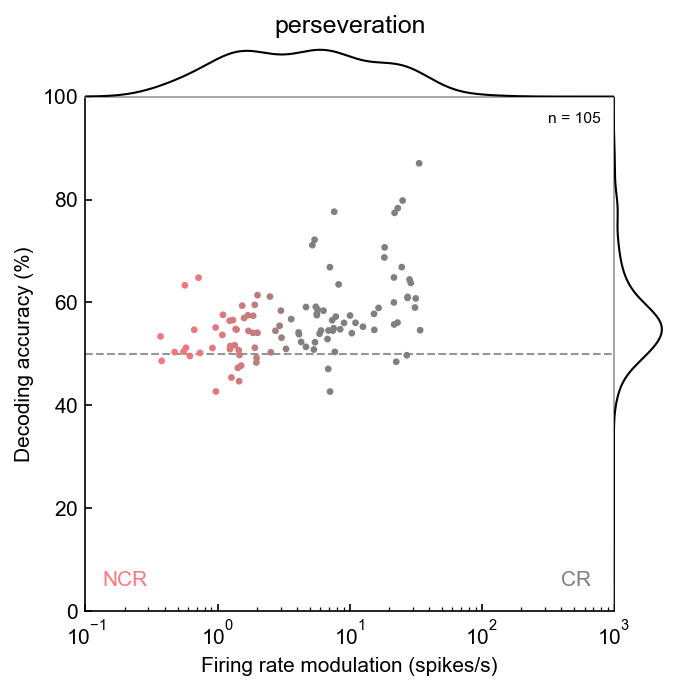

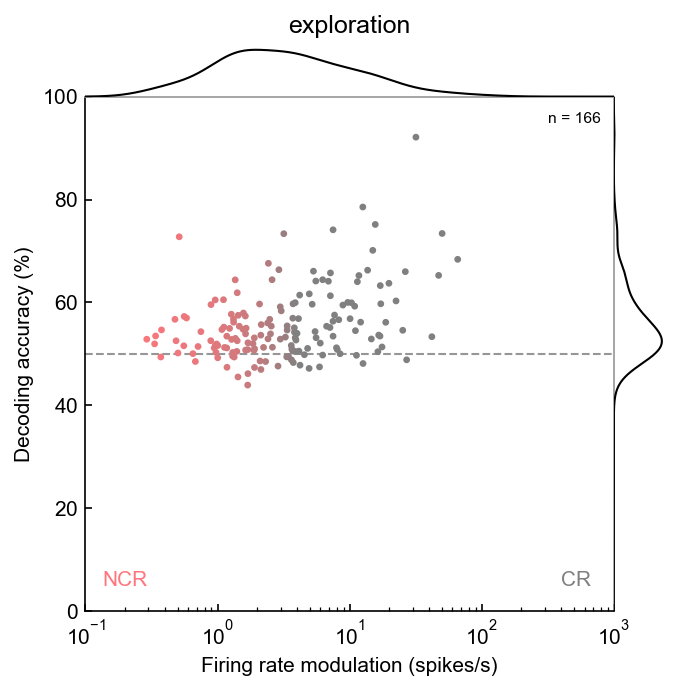

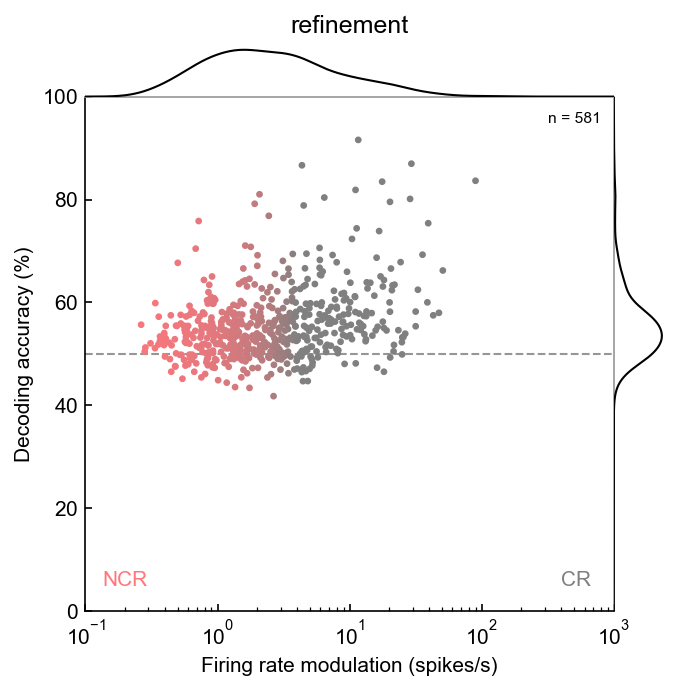

In [31]:
labelstring = 'perseveration'
data = np.array(pers)*100
FRdata = np.array(persc)
plotFRDecodingDist(data,FRdata,labelstring)

labelstring = 'exploration'
data = np.array(expl)*100
FRdata = np.array(explc)
plotFRDecodingDist(data,FRdata,labelstring)

labelstring = 'refinement'
data = np.array(refi)*100
FRdata = np.array(refic)
plotFRDecodingDist(data,FRdata,labelstring)

In [32]:
decoding_acc = []
num_trials_with_two = []

for idx in tqdm(range(len(clusters))):
    session = sessionIDs[idx]
    clust = clusters[idx]
    acc = accuracies[idx]
    
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    trials = sessionfile.trim[clust].trimmed_trials
    num_trials_two = 0
    for trial in trials:
        spikes = ilep.getTrialSpikes(sessionfile,trial,clust=clust)
        if len(spikes) >= 2:
            num_trials_two += 1
    
    decoding_acc.append(acc)
    num_trials_with_two.append(num_trials_two)

 16%|█▌        | 904/5801 [02:08<11:36,  7.03it/s]


KeyboardInterrupt: 

In [ ]:
fig,ax = plt.subplots(figsize=(5,3))
ax.scatter(num_trials_with_two,np.array(decoding_acc)*100,color=GOOD_GREY,s=3)
ax.set_xlabel('Number of trials with at least two spikes')
ax.set_ylabel('Decoding accuracy (%)')
fig.savefig(os.path.join('D:\\\\TempFigures','Decoding vs NumTrialsTwoSpikesV2.png'),transparent=False,facecolor="white")

In [57]:
forBadr = SimpleNamespace()
forBadr.FRmod_preearly = FRmod_preearly
forBadr.FRmod_preint = FRmod_preint
forBadr.FRmod_prelate = FRmod_prelate
forBadr.FRmod_postearly = FRmod_postearly
forBadr.FRmod_postint = FRmod_postint
forBadr.FRmod_postlate = FRmod_postlate

with open('D:\\ForBadr.pickle', 'wb') as f:
    pickle.dump(forBadr, f, protocol=pickle.HIGHEST_PROTOCOL)

In [143]:
445/1401

0.3176302640970735

In [140]:
print(N)

445


In [142]:
print(N)

1401


In [54]:
FRmod_preearly = []
Dec_preearly = []
FRmod_preint = []
Dec_preint = []
FRmod_prelate = []
Dec_prelate = []
FRmod_postearly = []
Dec_postearly = []
FRmod_postint = []
Dec_postint = []
FRmod_postlate = []
Dec_postlate = []

N = 0

animalstouse = ['BS_40','BS_41','BS_42','BS_49','BS_50','BS_51','BS_56','BS_59','BS_61','BS_67','BS_70','BS_72','BS_87','BS_108','DS_15','DS_19']

cellstouse = 'all cells'
#cellstouse = 'task encoders'

for idx,clust in tqdm(enumerate(clusters)):
    if not regions[idx] == 'AC':
        continue
    
    if cellstouse == 'task encoders':
        if not np.isfinite(accuracies[idx]) or pvals[idx] > 0.05 or accuracies[idx] < task_encoder_threshold:
            continue
        
    session = sessionIDs[idx]
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    if not sessionfile.meta.animal in animalstouse:
        continue
        
    if sessionfile.meta.animal == 'BS_67' and sessionfile.meta.day_of_training >= 15:
        continue
        
    N+=1
        
    if EILphases[idx] == 'pre early':
        FRmod_preearly.append(FRmods[idx])
        Dec_preearly.append(accuracies[idx])
    elif EILphases[idx] == 'pre int':
        FRmod_preint.append(FRmods[idx])
        Dec_preint.append(accuracies[idx])
    elif EILphases[idx] == 'pre late':
        FRmod_prelate.append(FRmods[idx])
        Dec_prelate.append(accuracies[idx])
    elif EILphases[idx] == 'post early':
        FRmod_postearly.append(FRmods[idx])
        Dec_postearly.append(accuracies[idx])
    elif EILphases[idx] == 'post int':
        FRmod_postint.append(FRmods[idx])
        Dec_postint.append(accuracies[idx])
    elif EILphases[idx] == 'post late':
        FRmod_postlate.append(FRmods[idx])
        Dec_postlate.append(accuracies[idx])
        
FRmod_preearly = np.array(FRmod_preearly)
FRmod_preint = np.array(FRmod_preint)
FRmod_prelate = np.array(FRmod_prelate)
FRmod_postearly = np.array(FRmod_postearly)
FRmod_postint = np.array(FRmod_postint)
FRmod_postlate = np.array(FRmod_postlate)

Dec_preearly = np.array(Dec_preearly)
Dec_preint = np.array(Dec_preint)
Dec_prelate = np.array(Dec_prelate)
Dec_postearly = np.array(Dec_postearly)
Dec_postint = np.array(Dec_postint)
Dec_postlate = np.array(Dec_postlate)

AC_FRmod_baseline_median = []
for idx,clust in tqdm(enumerate(clusters)):
    if not regions[idx] == 'AC':
        continue
        
    session = sessionIDs[idx]
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    if not sessionfile.meta.animal in animalstouse:
        continue
        
    if sessionfile.meta.animal == 'BS_67' and sessionfile.meta.day_of_training >= 15:
        continue
        
    if EILphases[idx] == 'pre early':
        AC_FRmod_baseline_median.append(FRmods[idx])
AC_FRmod_baseline_median = np.nanmedian(AC_FRmod_baseline_median)

TE_FRmod_baseline_median = []
for idx,clust in tqdm(enumerate(clusters)):
    if not regions[idx] == 'AC':
        continue
        
    session = sessionIDs[idx]
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    if not sessionfile.meta.animal in animalstouse:
        continue
        
    if not np.isfinite(accuracies[idx]) or pvals[idx] > 0.05 or accuracies[idx] < task_encoder_threshold:
            continue
        
    if sessionfile.meta.animal == 'BS_67' and sessionfile.meta.day_of_training >= 15:
        continue
        
    if EILphases[idx] == 'pre early':
        TE_FRmod_baseline_median.append(FRmods[idx])
TE_FRmod_baseline_median = np.nanmedian(TE_FRmod_baseline_median)

5801it [00:11, 497.88it/s] 
5801it [00:11, 490.08it/s] 
5801it [00:11, 493.48it/s] 


In [55]:
FRmod_baseline_median = AC_FRmod_baseline_median
print('baseline: '+str(FRmod_baseline_median))

#These numbers are essentially %CR
FRmod_preearly_pc = np.nanmean(np.greater(FRmod_preearly,FRmod_baseline_median))
FRmod_preint_pc = np.nanmean(np.greater(FRmod_preint,FRmod_baseline_median))
FRmod_prelate_pc = np.nanmean(np.greater(FRmod_prelate,FRmod_baseline_median))
FRmod_postearly_pc = np.nanmean(np.greater(FRmod_postearly,FRmod_baseline_median))
FRmod_postint_pc = np.nanmean(np.greater(FRmod_postint,FRmod_baseline_median))
FRmod_postlate_pc = np.nanmean(np.greater(FRmod_postlate,FRmod_baseline_median))
print(FRmod_preearly_pc)
print(FRmod_preint_pc)
print(FRmod_prelate_pc)
print(FRmod_postearly_pc)
print(FRmod_postint_pc)
print(FRmod_postlate_pc)

print('\nNs = ')
print(len(FRmod_preearly))
print(len(FRmod_preint))
print(len(FRmod_prelate))
print(len(FRmod_postearly))
print(len(FRmod_postint))
print(len(FRmod_postlate))

print('\nsignificance at: ' + str(0.05 / 5)+' '+str(0.01 / 5)+' '+str(0.001 / 5)+' '+str(0.0001 / 5))

print('pre-early,pre-int    :'+str(mannwhitneyu(FRmod_preearly,FRmod_preint).pvalue))
print('pre-early,pre-late   :'+str(mannwhitneyu(FRmod_preearly,FRmod_prelate).pvalue))
print('pre-early,post-early :'+str(mannwhitneyu(FRmod_preearly,FRmod_postearly).pvalue))
print('pre-early,post-int   :'+str(mannwhitneyu(FRmod_preearly,FRmod_postint).pvalue))
print('pre-early,post-late  :'+str(mannwhitneyu(FRmod_preearly,FRmod_postlate).pvalue))

# print('pre-int,pre-late     :'+str(mannwhitneyu(FRmod_preint,FRmod_prelate).pvalue))
# print('pre-int,post-early   :'+str(mannwhitneyu(FRmod_preint,FRmod_postearly).pvalue))
# print('pre-int,post-int     :'+str(mannwhitneyu(FRmod_preint,FRmod_postint).pvalue))
# print('pre-int,post-late    :'+str(mannwhitneyu(FRmod_preint,FRmod_postlate).pvalue))

# print('pre-late,post-early  :'+str(mannwhitneyu(FRmod_prelate,FRmod_postearly).pvalue))
# print('pre-late,post-int    :'+str(mannwhitneyu(FRmod_prelate,FRmod_postint).pvalue))
# print('pre-late,post-late   :'+str(mannwhitneyu(FRmod_prelate,FRmod_postlate).pvalue))

# print('post-early,post-int  :'+str(mannwhitneyu(FRmod_postearly,FRmod_postint).pvalue))
# print('post-early,post-late :'+str(mannwhitneyu(FRmod_postearly,FRmod_postlate).pvalue))

# print('post-early,post-late :'+str(mannwhitneyu(FRmod_postint,FRmod_postlate).pvalue))

baseline: 3.5938903863432152
0.5
0.37222222222222223
0.464
0.48247978436657685
0.35443037974683544
0.32941176470588235

Ns = 
148
180
125
371
237
255

significance at: 0.01 0.002 0.0002 2e-05
pre-early,pre-int    :0.0008446574882440393
pre-early,pre-late   :0.5728209866218739
pre-early,post-early :0.4610561709151445
pre-early,post-int   :0.00010081931298092958
pre-early,post-late  :4.572986648788633e-06


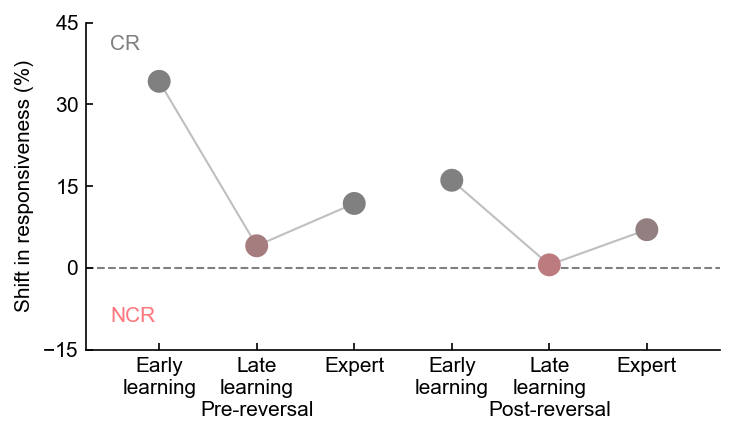

In [1023]:
fig, ax = plt.subplots(figsize=(5,3))
percentCR = np.array([FRmod_preearly_pc,FRmod_preint_pc,FRmod_prelate_pc,FRmod_postearly_pc,FRmod_postint_pc,FRmod_postlate_pc])*100
labels = ['Early\nlearning','Late\nlearning\nPre-reversal','Expert','Early\nlearning','Late\nlearning\nPost-reversal','Expert']
#percentCR = np.array([FRmod_prelate_pc,FRmod_postearly_pc,FRmod_postint_pc,FRmod_postlate_pc])*100
#labels = ['Pre Late','Early','Intermediate\npost-reversal','Late']
numCon = len(labels)
ax.plot([0,1,2],(percentCR[0:3]-50),color='grey',lw=1,alpha=0.5)
ax.plot([3,4,5],(percentCR[3:6]-50),color='grey',lw=1,alpha=0.5)

color=NCR_CR_cmap((percentCR-40)/20)
ax.scatter(range(numCon),(percentCR-50),c=color,s=100,zorder=10)

xlims = [-0.75,numCon-0.25]
ax.plot(xlims,[0,0],c='grey',linestyle='--',lw=1,zorder=-10)
ax.set_xlim(xlims)
ax.set_xticks(range(numCon))
ax.set_xticklabels(labels)

# ax.set_ylabel('Shift in responsiveness (%)')
# ax.set_ylim([-35,25])
# ax.set_yticks([-30,-20,-10,0,10,20])
# ax.text(-0.5,20,'NCR',color=NCR_COLOR)
# ax.text(-0.5,-30,'CR',color=CR_COLOR)

#ax.set_ylabel('Shift in responsiveness (%)')
#ax.set_ylim([-35,65])
#ax.set_yticks([-30,-15,0,15,30,45,60])
#ax.text(-0.5,55,'NCR',color=NCR_COLOR)
#ax.text(-0.5,-30,'CR',color=CR_COLOR)

# #All cells with All Cells baseline
# ax.set_ylabel('Shift in responsiveness (%)')
# ax.set_ylim([-30,15])
# ax.set_yticks([-30,-15,0,15])
# ax.text(-0.5,10,'CR',color=CR_COLOR)
# ax.text(-0.5,-25,'NCR',color=NCR_COLOR)

#Task encoders with All Cells baseline
ax.set_ylabel('Shift in responsiveness (%)')
ax.set_ylim([-15,45])
ax.set_yticks([-15,0,15,30,45])
ax.text(-0.5,40,'CR',color=CR_COLOR)
ax.text(-0.5,-10,'NCR',color=NCR_COLOR)

##Task encoders with All Cells baseline
#ax.set_ylabel('Shift in responsiveness (%)')
#ax.set_ylim([-60,15])
#ax.set_yticks([-60,-45,-30,-15,0,15])
#ax.text(-0.5,10,'CR',color=CR_COLOR)
#ax.text(-0.5,-50,'NCR',color=NCR_COLOR)


#ax.plot([2.5,2.5],ax.get_ylim(),color='blue',lw=1,zorder=-15)

plt.tight_layout()

plt.savefig(os.path.join('D:\\\\Figures','Decoding Figures','Shift in responsiveness','AC Shift in responsiveness '+cellstouse+'.pdf'),transparent=False,facecolor="white")
#plt.savefig(os.path.join('D:\\\\Figures','Decoding Figures','Shift in responsiveness','AC Shift in responsiveness '+cellstouse+' task-encoder baseline.pdf'),transparent=False,facecolor="white")

##plt.savefig(os.path.join('D:\\\\Figures','Decoding Figures','Shift in responsiveness','AC Shift in responsiveness '+cellstouse+' pre-late baseline.pdf'),transparent=False,facecolor="white")

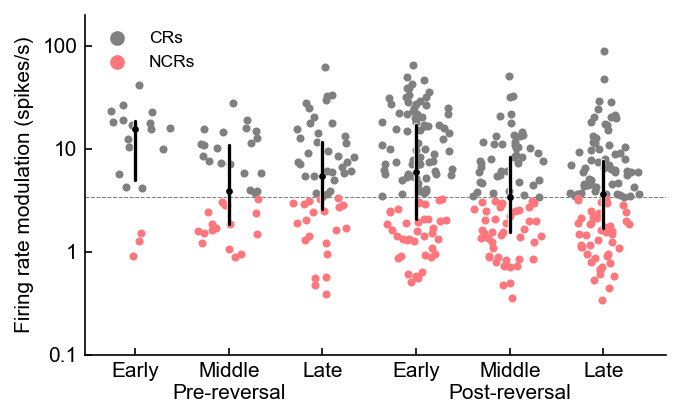

In [528]:
size=15

fig, ax = plt.subplots(figsize=(5,3))
data = [FRmod_preearly,FRmod_preint,FRmod_prelate,FRmod_postearly,FRmod_postint,FRmod_postlate]
labels = ['Early','Middle\nPre-reversal','Late','Early','Middle\nPost-reversal','Late']
X = [np.ones(len(l))*idx for idx,l in enumerate(data)]

_,Y = ilep.violin(np.concatenate(X),np.concatenate(data))
X,_ = ilep.violin(np.concatenate(X),np.log10(np.concatenate(data)))

CRidx = np.greater_equal(Y,FRmod_baseline_median)
ax.scatter(X[CRidx], Y[CRidx], s=size, c=CR_COLOR, lw=0)
NCRidx = np.logical_not(CRidx)
ax.scatter(X[NCRidx], Y[NCRidx], s=size, c=NCR_COLOR, lw=0)

#Plot summary
for idx,column in enumerate(data):
    summary_color='k'
    summary_size=10
    Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
    ax.scatter([idx], [median], c='w', s=summary_size*1.3*.5, zorder=1)
    ax.scatter([idx], [median], c=summary_color, s=summary_size*.5, zorder=2)
    ax.plot([idx, idx], [Q1, Q3], c='w', lw=np.sqrt(summary_size) * .5 * 1.3, zorder=1, solid_capstyle='round')
    ax.plot([idx, idx], [Q1, Q3], c=summary_color, lw=np.sqrt(summary_size)*.5, zorder=2, solid_capstyle='round')

xlim = ax.get_xlim()
ax.plot(xlim,[FRmod_baseline_median]*2,lw=0.5,zorder=-10,linestyle='--',color='grey')
ax.set_xlim(xlim)

ax.scatter([],[], s=50, c=CR_COLOR, zorder=0, lw=0, label='CRs')
ax.scatter([],[], s=50, c=NCR_COLOR, zorder=0, lw=0, label='NCRs')
ax.legend(frameon=False)

ax.set_yscale('log',subsy=[])
ax.set_ylim([0.1,200])
ax.set_yticks([0.1,1,10,100])
ax.set_yticklabels(['0.1','1','10','100'])
ax.set_ylabel('Firing rate modulation (spikes/s)')

ax.set_xticks(range(numCon))
ax.set_xticklabels(labels)
pass

#plt.savefig(os.path.join('D:\\\\Figures','Decoding Figures','Shift in responsiveness','AC FR modulation shifts '+cellstouse+'.pdf'),transparent=False,facecolor="white")

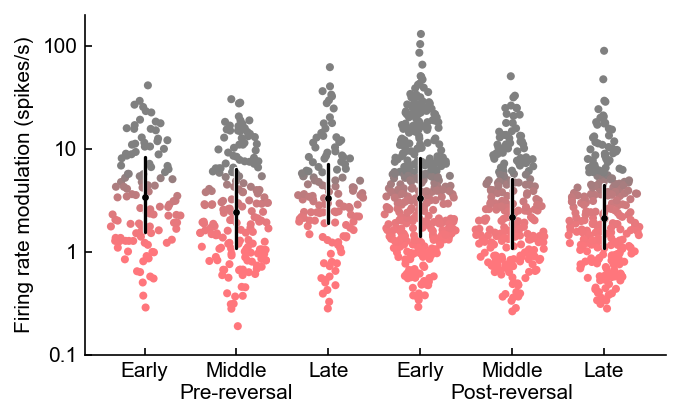

In [523]:
size=15

fig, ax = plt.subplots(figsize=(5,3))
data = [FRmod_preearly,FRmod_preint,FRmod_prelate,FRmod_postearly,FRmod_postint,FRmod_postlate]
labels = ['Early','Middle\nPre-reversal','Late','Early','Middle\nPost-reversal','Late']
numCon = len(data)
X = [np.ones(len(l))*idx for idx,l in enumerate(data)]

_,Y = ilep.violin(np.concatenate(X),np.concatenate(data))
X,_ = ilep.violin(np.concatenate(X),np.log10(np.concatenate(data)))
colors = NCR_CR_cmap((Y-1)/5)

ax.scatter(X, Y, s=size, c=colors, lw=0)

#Plot summary
for idx,column in enumerate(data):
    summary_color='k'
    summary_size=10
    Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
    ax.scatter([idx], [median], c='w', s=summary_size*1.3*.5, zorder=1)
    ax.scatter([idx], [median], c=summary_color, s=summary_size*.5, zorder=2)
    ax.plot([idx, idx], [Q1, Q3], c='w', lw=np.sqrt(summary_size) * .5 * 1.3, zorder=1, solid_capstyle='round')
    ax.plot([idx, idx], [Q1, Q3], c=summary_color, lw=np.sqrt(summary_size)*.5, zorder=2, solid_capstyle='round')

#ax.scatter([],[], s=50, c=CR_COLOR, zorder=0, lw=0, label='CRs')
#ax.scatter([],[], s=50, c=NCR_COLOR, zorder=0, lw=0, label='NCRs')
#ax.legend(frameon=False)

ax.set_yscale('log',subsy=[])
ax.set_ylim([0.1,200])
ax.set_yticks([0.1,1,10,100])
ax.set_yticklabels(['0.1','1','10','100'])
ax.set_ylabel('Firing rate modulation (spikes/s)')

ax.set_xticks(range(numCon))
ax.set_xticklabels(labels)
pass

#plt.savefig(os.path.join('D:\\\\Figures','Decoding Figures','FR modulations','AC FR modulations '+cellstouse+'.pdf'),transparent=False,facecolor="white")

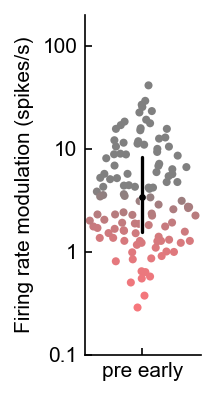

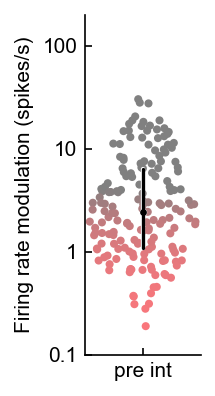

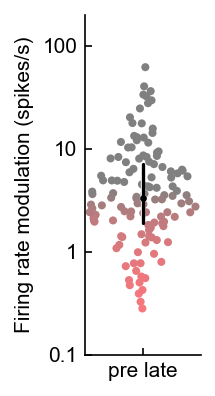

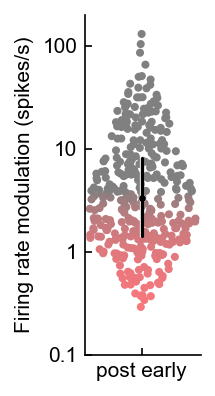

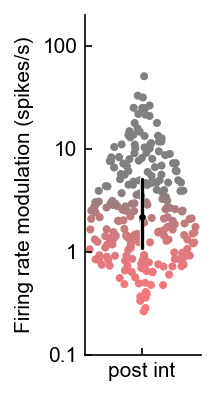

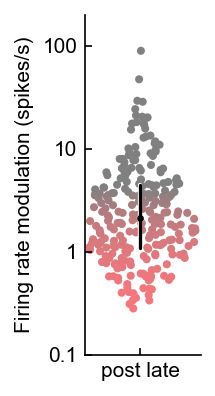

In [512]:
def plot_FRmod_cloud(FRmod_data,label):

    size=15
    fig, ax = plt.subplots(figsize=(1,3))
    data = [FRmod_data]
    labels = [label]
    numCon = len(data)
    X = [np.ones(len(l))*idx for idx,l in enumerate(data)]

    _,Y = ilep.violin(np.concatenate(X),np.concatenate(data))
    X,_ = ilep.violin(np.concatenate(X),np.log10(np.concatenate(data)))
    colors = NCR_CR_cmap(Y/4)

    ax.scatter(X, Y, s=size, c=colors, lw=0)

    #Plot summary
    for idx,column in enumerate(data):
        summary_color='k'
        summary_size=10
        Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
        ax.scatter([idx], [median], c='w', s=summary_size*1.3*.5, zorder=1)
        ax.scatter([idx], [median], c=summary_color, s=summary_size*.5, zorder=2)
        ax.plot([idx, idx], [Q1, Q3], c='w', lw=np.sqrt(summary_size) * .5 * 1.3, zorder=1, solid_capstyle='round')
        ax.plot([idx, idx], [Q1, Q3], c=summary_color, lw=np.sqrt(summary_size)*.5, zorder=2, solid_capstyle='round')

    #ax.scatter([],[], s=50, c=CR_COLOR, zorder=0, lw=0, label='CRs')
    #ax.scatter([],[], s=50, c=NCR_COLOR, zorder=0, lw=0, label='NCRs')
    #ax.legend(frameon=False)

    ax.set_yscale('log',subsy=[])
    ax.set_ylim([0.1,200])
    ax.set_yticks([0.1,1,10,100])
    ax.set_yticklabels(['0.1','1','10','100'])
    ax.set_ylabel('Firing rate modulation (spikes/s)')

    ax.set_xticks(range(numCon))
    ax.set_xticklabels(labels)
    pass

    plt.savefig(os.path.join('D:\\\\Figures','Decoding Figures','FR modulations','AC individual FR modulations '+cellstouse+' '+label+'.pdf'),transparent=False,facecolor="white")
    
data = [FRmod_preearly,FRmod_preint,FRmod_prelate,FRmod_postearly,FRmod_postint,FRmod_postlate]
labels = ['pre early','pre int','pre late','post early','post int','post late']
for d,l in zip(data,labels):
    plot_FRmod_cloud(d,l)

# V2 (Visual Style)

(0.42721800997169146, 0.1950748711447191, 0.20524172394006096)
(0.5208475272038138, 0.14369937263720367, 0.16021681006347854)
(0.4294738395165469, 0.19396724863042364, 0.2042814058955093)
(0.4290215258693789, 0.19418992087147957, 0.2044745167108036)
(0.5550239556940971, 0.12261250429530401, 0.14155023209379128)
(0.5600513383022473, 0.1194222529360498, 0.13871987711267156)


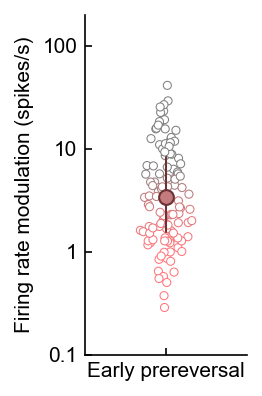

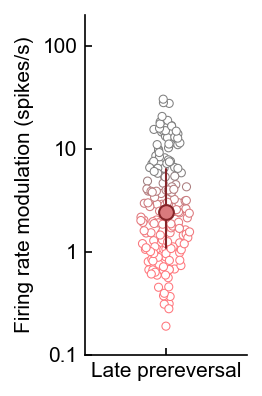

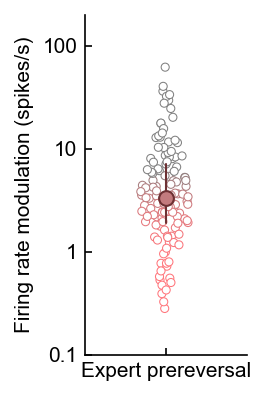

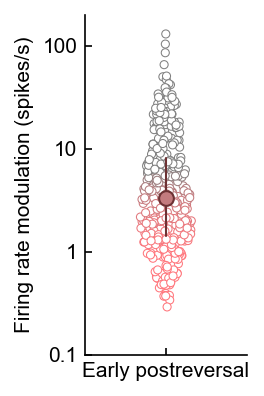

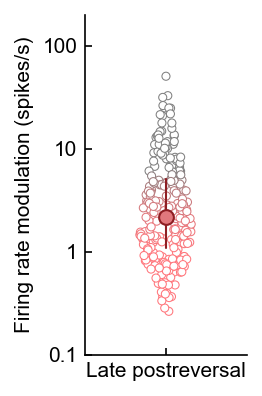

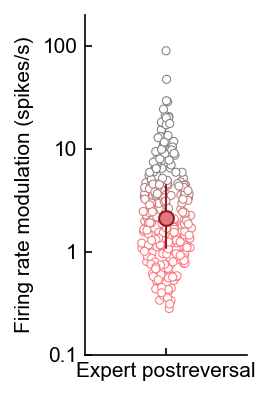

In [955]:
def plot_FRmod_cloud_V2(FRmod_data,label):

    size=15
    fig, ax = plt.subplots(figsize=(1.4,3))
    data = [FRmod_data]
    labels = [label]
    numCon = len(data)
    X = [np.ones(len(l))*idx for idx,l in enumerate(data)]

    _,Y = ilep.violin(np.concatenate(X),np.concatenate(data))
    X,_ = ilep.violin(np.concatenate(X),np.log10(np.concatenate(data)),width=0.4)
    colors = NCR_CR_cmap((Y-1)/5)

    ax.scatter(X, Y, s=size, ec=colors, fc='white', lw=0.5,zorder=-10)

    #Plot summary
    for idx,column in enumerate(data):
        eye_color = NCR_CR_cmap((np.nanmedian(FRmod_data)-1)/5)

        r,g,b = mpl.colors.to_rgb(eye_color)
        h,l,s = colorsys.rgb_to_hls(r,g,b)
        border_color=colorsys.hls_to_rgb(h,l*0.5,s)
        print(border_color)

        summary_size=50
        summary_width=1

        Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])

        ax.scatter([idx], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
        ax.plot([idx, idx], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')

    #ax.scatter([],[], s=50, c=CR_COLOR, zorder=0, lw=0, label='CRs')
    #ax.scatter([],[], s=50, c=NCR_COLOR, zorder=0, lw=0, label='NCRs')
    #ax.legend(frameon=False)

    ax.set_yscale('log',subsy=[])
    ax.set_ylim([0.1,200])
    ax.set_yticks([0.1,1,10,100])
    ax.set_yticklabels(['0.1','1','10','100'])
    ax.set_ylabel('Firing rate modulation (spikes/s)')

    ax.set_xlim([-0.5,0.5])
    ax.set_xticks(range(numCon))
    ax.set_xticklabels(labels)
    ax.set_xlim(ax.get_xlim())

    plt.savefig(os.path.join('D:\\\\Figures','Decoding Figures','FR modulations','AC individual FR modulations '+cellstouse+' '+label+'.pdf'),transparent=False,facecolor="white")
    
data = [FRmod_preearly,FRmod_preint,FRmod_prelate,FRmod_postearly,FRmod_postint,FRmod_postlate]
labels = ['Early prereversal','Late prereversal','Expert prereversal','Early postreversal','Late postreversal','Expert postreversal']
for d,l in zip(data,labels):
    plot_FRmod_cloud_V2(d,l)

# FRmodulation -- Cumulative Distribution

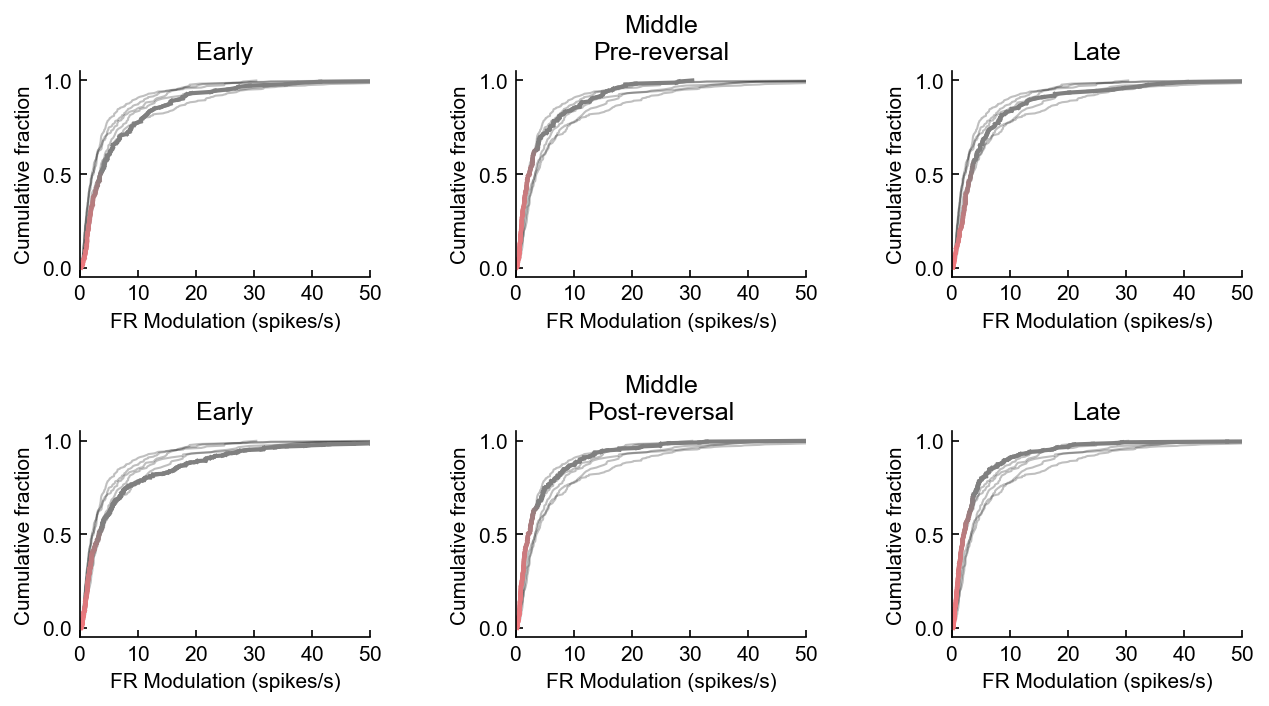

In [56]:
def add_NCR_CR_scale(ax, method='one_sided', height=0.1, hoffset=0.5, voffset=.05, fontsize=10, alength=.5, awidth=.05, aoffset=0.1):
    x_min, x_max = ax.get_xlim()    
    y_min, y_max = ax.get_ylim()
    if method == 'one_sided':
        # ax.add_patch(plt.Polygon([[x_min, y_min - height], [x_min, y_min], [x_max, y_min - height]], lw=0, facecolor=NNR_COLOR))
        # ax.add_patch(plt.Polygon([[x_min, y_min], [x_max, y_min], [x_max, y_min - height]], lw=0, facecolor=R_COLOR))
        ax.add_patch(plt.Arrow(x_min + hoffset + alength + aoffset, y_min - height + voffset, -alength, 0, facecolor=NCR_COLOR, lw=0, width=awidth))
        ax.add_patch(plt.Arrow(x_max - hoffset - alength - aoffset, y_min - height + voffset, alength, 0, facecolor=CR_COLOR, lw=0, width=awidth))
        ax.text(x_min + hoffset, y_min - height + voffset, "NCR", ha='right', va='center', c=NCR_COLOR, fontsize=fontsize)
        ax.text(x_max - hoffset, y_min - height + voffset, "CR", ha='left', va='center', c=CR_COLOR, fontsize=fontsize)
    elif method == 'two_sided':
        ax.add_patch(plt.Polygon([[0, y_min - height], [0, y_min], [x_max, y_min - height]], lw=0, facecolor=NCR_COLOR))
        ax.add_patch(plt.Polygon([[0, y_min - height], [0, y_min], [x_min, y_min - height]], lw=0, facecolor=NCR_COLOR))
        
        ax.add_patch(plt.Polygon([[0, y_min], [x_max, y_min], [x_max, y_min - height]], lw=0, facecolor=CR_COLOR))
        ax.add_patch(plt.Polygon([[0, y_min], [x_min, y_min], [x_min, y_min - height]], lw=0, facecolor=CR_COLOR))

        ax.text(x_min - hoffset, y_min - height - voffset, "-CR", ha='left', va='bottom', c=CR_COLOR, fontsize=fontsize)
        ax.text(x_max + hoffset, y_min - height - voffset, "+CR", ha='left', va='bottom', c=CR_COLOR, fontsize=fontsize)
        ax.text(0, y_min - height - 10*voffset, "NCR", ha='center', va='top', c=NCR_COLOR, fontsize=fontsize)
    ax.set_ylim([y_min-height, y_max])
    pass

dataToUse = [FRmod_preearly,FRmod_preint,FRmod_prelate,FRmod_postearly,FRmod_postint,FRmod_postlate]
labels = ['Early','Middle\nPre-reversal','Late','Early','Middle\nPost-reversal','Late']
statlabels = ['Early Pre-reversal','Middle Pre-reversal','Late Pre-reversal','Early Post-reversal','Middle Post-reversal','Late Post-reversal']

trans = 0.25

fig = plt.figure(figsize=(10,5))
gs = fig.add_gridspec(2,3,height_ratios=[1,1],hspace=0.75,wspace=0.5)
ax1 = plt.subplot(gs[0,0])#Raster
ax2 = plt.subplot(gs[0,1],sharex=ax1,sharey=ax1)
ax3 = plt.subplot(gs[0,2],sharex=ax1,sharey=ax1)
ax4 = plt.subplot(gs[1,0],sharex=ax1,sharey=ax1)
ax5 = plt.subplot(gs[1,1],sharex=ax1,sharey=ax1)
ax6 = plt.subplot(gs[1,2],sharex=ax1,sharey=ax1)
axs = [ax1,ax2,ax3,ax4,ax5,ax6]

def colored_line(ax,x,y,colormap,lw=1,alpha=1):
    for idx in range(len(x)-1):
        xs = [x[idx],x[idx+1]]
        ys = [y[idx],y[idx+1]]
        color = colormap[idx]
        ax.plot(xs,ys,lw=lw,color=color,alpha=alpha);

for idx,column in enumerate(dataToUse):
    column = column[np.logical_not(np.isnan(column))]
    column = np.sort(column)
    fraction = np.linspace(0,1,num=len(column))
    
    for idx2,column2 in enumerate(dataToUse):
        if idx2 != idx:
            column2 = column2[np.logical_not(np.isnan(column2))]
            column2 = np.sort(column2)
            fraction2 = np.linspace(0,1,num=len(column2))
            colormap=NCR_CR_cmap(column2/4)
            axs[idx].plot(column2,fraction2,color='k',lw=1,alpha=trans)
    
    colormap=NCR_CR_cmap(column/4)
    #axs[idx].plot(column,fraction,color=colormap,lw=2)
    colored_line(axs[idx],column,fraction,colormap,lw=2)
#     axs[idx].set_xticks([0,2,4,6,8,10])
#     axs[idx].set_xlim([0,10])
    axs[idx].set_xticks([0,10,20,30,40,50])
    axs[idx].set_xlim([0,50])
    axs[idx].set_title(labels[idx])
    axs[idx].set_xlabel('FR Modulation (spikes/s)')
    axs[idx].set_ylabel('Cumulative fraction')
    
    #add_NCR_CR_scale(axs[idx], method='one_sided', height=0, hoffset=2.25)
    #add_NCR_CR_scale(axs[idx], method='one_sided', height=0.0125, hoffset=10)
    
plt.savefig(os.path.join('D:\\\\Figures','Decoding Figures','Cumulative distributions','AC Cumulative FR distributions '+cellstouse+'.pdf'),transparent=False,facecolor="white")

# Decoding -- Cumulative Distribution

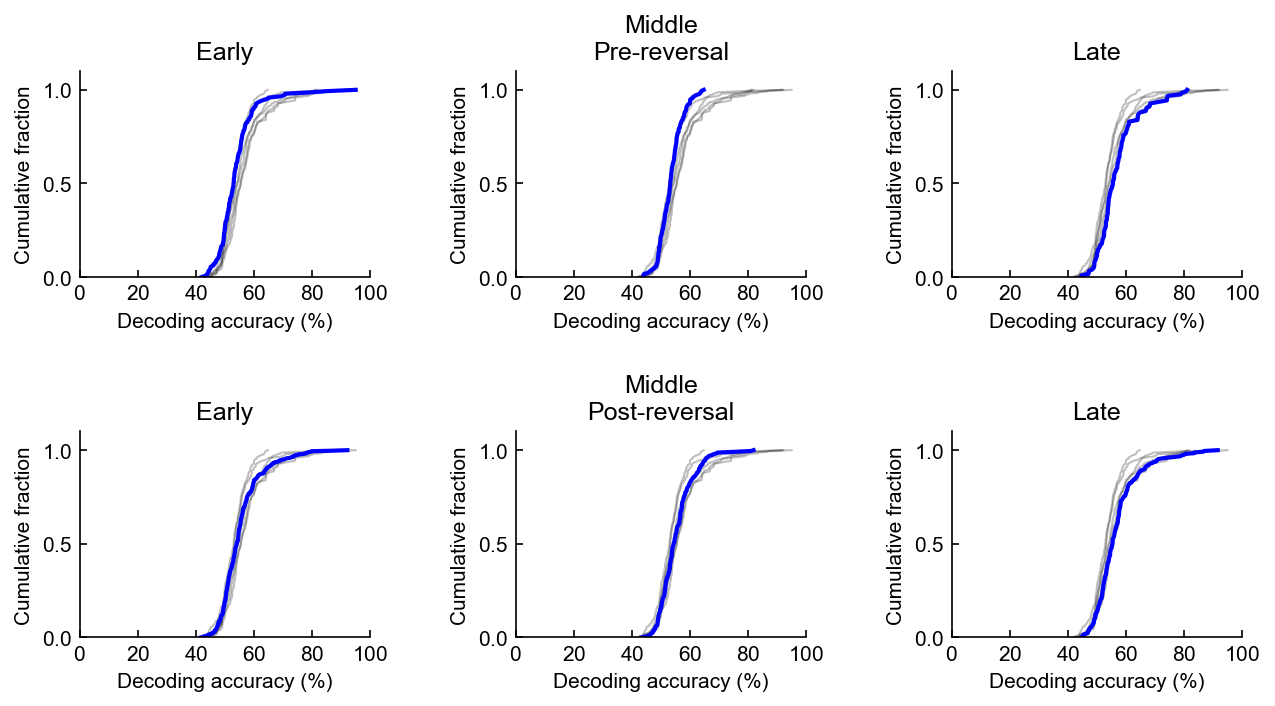

In [57]:
def add_NCR_CR_scale(ax, method='one_sided', height=0.1, hoffset=0.5, voffset=.05, fontsize=10, alength=.5, awidth=.05, aoffset=0.1):
    x_min, x_max = ax.get_xlim()    
    y_min, y_max = ax.get_ylim()
    if method == 'one_sided':
        # ax.add_patch(plt.Polygon([[x_min, y_min - height], [x_min, y_min], [x_max, y_min - height]], lw=0, facecolor=NNR_COLOR))
        # ax.add_patch(plt.Polygon([[x_min, y_min], [x_max, y_min], [x_max, y_min - height]], lw=0, facecolor=R_COLOR))
        ax.add_patch(plt.Arrow(x_min + hoffset + alength + aoffset, y_min - height + voffset, -alength, 0, facecolor=NCR_COLOR, lw=0, width=awidth))
        ax.add_patch(plt.Arrow(x_max - hoffset - alength - aoffset, y_min - height + voffset, alength, 0, facecolor=CR_COLOR, lw=0, width=awidth))
        ax.text(x_min + hoffset, y_min - height + voffset, "NCR", ha='right', va='center', c=NCR_COLOR, fontsize=fontsize)
        ax.text(x_max - hoffset, y_min - height + voffset, "CR", ha='left', va='center', c=CR_COLOR, fontsize=fontsize)
    elif method == 'two_sided':
        ax.add_patch(plt.Polygon([[0, y_min - height], [0, y_min], [x_max, y_min - height]], lw=0, facecolor=NCR_COLOR))
        ax.add_patch(plt.Polygon([[0, y_min - height], [0, y_min], [x_min, y_min - height]], lw=0, facecolor=NCR_COLOR))
        
        ax.add_patch(plt.Polygon([[0, y_min], [x_max, y_min], [x_max, y_min - height]], lw=0, facecolor=CR_COLOR))
        ax.add_patch(plt.Polygon([[0, y_min], [x_min, y_min], [x_min, y_min - height]], lw=0, facecolor=CR_COLOR))

        ax.text(x_min - hoffset, y_min - height - voffset, "-CR", ha='left', va='bottom', c=CR_COLOR, fontsize=fontsize)
        ax.text(x_max + hoffset, y_min - height - voffset, "+CR", ha='left', va='bottom', c=CR_COLOR, fontsize=fontsize)
        ax.text(0, y_min - height - 10*voffset, "NCR", ha='center', va='top', c=NCR_COLOR, fontsize=fontsize)
    ax.set_ylim([y_min-height, y_max])
    pass

dataToUse = [Dec_preearly,Dec_preint,Dec_prelate,Dec_postearly,Dec_postint,Dec_postlate]
labels = ['Early','Middle\nPre-reversal','Late','Early','Middle\nPost-reversal','Late']
statlabels = ['Early Pre-reversal','Middle Pre-reversal','Late Pre-reversal','Early Post-reversal','Middle Post-reversal','Late Post-reversal']

trans = 0.25

fig = plt.figure(figsize=(10,5))
gs = fig.add_gridspec(2,3,height_ratios=[1,1],hspace=0.75,wspace=0.5)
ax1 = plt.subplot(gs[0,0])#Raster
ax2 = plt.subplot(gs[0,1],sharex=ax1,sharey=ax1)
ax3 = plt.subplot(gs[0,2],sharex=ax1,sharey=ax1)
ax4 = plt.subplot(gs[1,0],sharex=ax1,sharey=ax1)
ax5 = plt.subplot(gs[1,1],sharex=ax1,sharey=ax1)
ax6 = plt.subplot(gs[1,2],sharex=ax1,sharey=ax1)
axs = [ax1,ax2,ax3,ax4,ax5,ax6]

def colored_line(ax,x,y,colormap,lw=1,alpha=1):
    for idx in range(len(x)-1):
        xs = [x[idx],x[idx+1]]
        ys = [y[idx],y[idx+1]]
        color = colormap[idx]
        ax.plot(xs,ys,lw=lw,color=color,alpha=alpha);

for idx,column in enumerate(dataToUse):
    column = column[np.logical_not(np.isnan(column))]*100
    column = np.sort(column)
    fraction = np.linspace(0,1,num=len(column))
    
    for idx2,column2 in enumerate(dataToUse):
        if idx2 != idx:
            column2 = column2[np.logical_not(np.isnan(column2))]*100
            column2 = np.sort(column2)
            fraction2 = np.linspace(0,1,num=len(column2))
            colormap=NCR_CR_cmap(column2/4)
            axs[idx].plot(column2,fraction2,color='k',lw=1,alpha=trans)
    
    colormap=NCR_CR_cmap(column/4)
    #axs[idx].plot(column,fraction,color=colormap,lw=2)
    axs[idx].plot(column,fraction,color='blue',lw=2,alpha=1)
    #colored_line(axs[idx],column,fraction,colormap,lw=2)
#     axs[idx].set_xticks([0,2,4,6,8,10])
#     axs[idx].set_xlim([0,10])
    axs[idx].set_xticks([0,20,40,60,80,100])
    axs[idx].set_xlim([0,100])
    axs[idx].set_ylim([0,1.1])
    axs[idx].set_title(labels[idx])
    axs[idx].set_xlabel('Decoding accuracy (%)')
    axs[idx].set_ylabel('Cumulative fraction')
    
    #add_NCR_CR_scale(axs[idx], method='one_sided', height=0, hoffset=2.25)
    #add_NCR_CR_scale(axs[idx], method='one_sided', height=0.0125, hoffset=10)
    
plt.savefig(os.path.join('D:\\\\Figures','Decoding Figures','Cumulative distributions','AC Cumulative Decoding distributions '+cellstouse+'.pdf'),transparent=False,facecolor="white")

# Three-Day Slope Learning Phase Shift in Responsiveness

In [1101]:
FRmod_preslope = []
FRmod_maxslope = []
FRmod_postslope = []
Dec_preslope = []
Dec_maxslope = []
Dec_postslope = []

N = 0

animalstouse = ['BS_40','BS_41','BS_42','BS_49','BS_51','BS_56','BS_59','BS_61','BS_67','BS_70','BS_72','BS_87','BS_108','DS_15','DS_19']

cellstouse = 'all cells'
#cellstouse = 'task encoders'

for idx,clust in tqdm(enumerate(clusters)):
    if not regions[idx] == 'AC':
        continue
    
    if cellstouse == 'task encoders':
        if not np.isfinite(accuracies[idx]) or pvals[idx] > 0.05 or accuracies[idx] < task_encoder_threshold:
            continue
        
    session = sessionIDs[idx]
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    if not sessionfile.meta.animal in animalstouse:
        continue
        
    if sessionfile.meta.animal == 'BS_67' and sessionfile.meta.day_of_training >= 15:
        continue
        
    N+=1
        
    animal = sessionfile.meta.animal
    day = sessionfile.meta.day_of_training
    if day in threeDayPhases[animal].preSlope:
        FRmod_preslope.append(FRmods[idx])
        Dec_preslope.append(accuracies[idx])
    elif day in threeDayPhases[animal].maxSlope:
        FRmod_maxslope.append(FRmods[idx])
        Dec_maxslope.append(accuracies[idx])
    elif day in threeDayPhases[animal].postSlope:
        FRmod_postslope.append(FRmods[idx])
        Dec_postslope.append(accuracies[idx])
        
FRmod_preslope = np.array(FRmod_preslope)
FRmod_maxslope = np.array(FRmod_maxslope)
FRmod_postslope = np.array(FRmod_postslope)
Dec_preslope = np.array(Dec_preslope)
Dec_maxslope = np.array(Dec_maxslope)
Dec_postslope = np.array(Dec_postslope)

FRmod_preslope = FRmod_preslope[np.logical_not(np.isnan(FRmod_preslope))]
FRmod_maxslope = FRmod_maxslope[np.logical_not(np.isnan(FRmod_maxslope))]
FRmod_postslope = FRmod_postslope[np.logical_not(np.isnan(FRmod_postslope))]

Dec_preslope = Dec_preslope[np.logical_not(np.isnan(Dec_preslope))]
Dec_maxslope = Dec_maxslope[np.logical_not(np.isnan(Dec_maxslope))]
Dec_postslope = Dec_postslope[np.logical_not(np.isnan(Dec_postslope))]

5801it [00:16, 350.90it/s] 


In [1102]:
FRmod_baseline_median = np.nanmedian(FRmod_preslope)
print('baseline: '+str(FRmod_baseline_median))

#These numbers are essentially %CR
FRmod_preslope_pc = np.nanmean(np.greater(FRmod_preslope,FRmod_baseline_median))
FRmod_maxslope_pc = np.nanmean(np.greater(FRmod_maxslope,FRmod_baseline_median))
FRmod_postslope_pc = np.nanmean(np.greater(FRmod_postslope,FRmod_baseline_median))
print(FRmod_preslope_pc)
print(FRmod_maxslope_pc)
print(FRmod_postslope_pc)

print('\nNs = ')
print(len(FRmod_preslope))
print(len(FRmod_maxslope))
print(len(FRmod_postslope))
#print(len(Dec_preslope))
#print(len(Dec_maxslope))
#print(len(Dec_postslope))

print('\nsignificance at: ' + str(0.05 / 3))

print('pre-slope,max-slope    :'+str(mannwhitneyu(FRmod_preslope,FRmod_maxslope).pvalue))
print('pre-slope,post-slope   :'+str(mannwhitneyu(FRmod_preslope,FRmod_postslope).pvalue))
print('max-slope,post-slope   :'+str(mannwhitneyu(FRmod_maxslope,FRmod_postslope).pvalue))

baseline: 2.9459513763311236
0.5
0.41150442477876104
0.44635193133047213

Ns = 
404
226
233

significance at: 0.016666666666666666
pre-slope,max-slope    :0.003498309249944846
pre-slope,post-slope   :0.014193895582751045
max-slope,post-slope   :0.2896932329963675


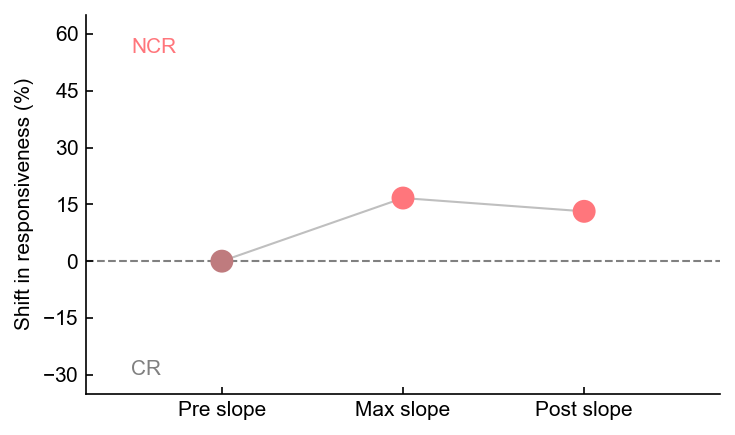

In [464]:
fig, ax = plt.subplots(figsize=(5,3))
percentCR = np.array([FRmod_preslope_pc,FRmod_maxslope_pc,FRmod_postslope_pc])*100
labels = ['Pre slope','Max slope','Post slope']
numCon = len(labels)
ax.plot(range(numCon),-(percentCR-50),color='grey',lw=1,alpha=0.5)

color=NCR_CR_cmap((percentCR-40)/20)
ax.scatter(range(numCon),-(percentCR-50),c=color,s=100,zorder=10)

xlims = [-0.75,numCon-0.25]
ax.plot(xlims,[0,0],c='grey',linestyle='--',lw=1,zorder=-10)
ax.set_xlim(xlims)
ax.set_xticks(range(numCon))
ax.set_xticklabels(labels)

#ax.set_ylabel('Shift in responsiveness (%)')
#ax.set_ylim([-35,25])
#ax.set_yticks([-30,-20,-10,0,10,20])
#ax.text(-0.5,20,'NCR',color=NCR_COLOR)
#ax.text(-0.5,-30,'CR',color=CR_COLOR)

ax.set_ylabel('Shift in responsiveness (%)')
ax.set_ylim([-35,65])
ax.set_yticks([-30,-15,0,15,30,45,60])
ax.text(-0.5,55,'NCR',color=NCR_COLOR)
ax.text(-0.5,-30,'CR',color=CR_COLOR)

#ax.plot([2.5,2.5],ax.get_ylim(),color='blue',lw=1,zorder=-15)

plt.tight_layout()
plt.savefig(os.path.join('D:\\\\Figures','Decoding Figures','Shift in responsiveness','AC Three-day-slope Shift in responsiveness '+cellstouse+'.pdf'),transparent=False,facecolor="white")


significance at: 0.016666666666666666
Pre-slope vs Max-slope  : 0.009701486289163466
Pre-slope vs Post-slope : 0.030133504078663685
Max-slope vs Post-slope : 0.41975959186372036


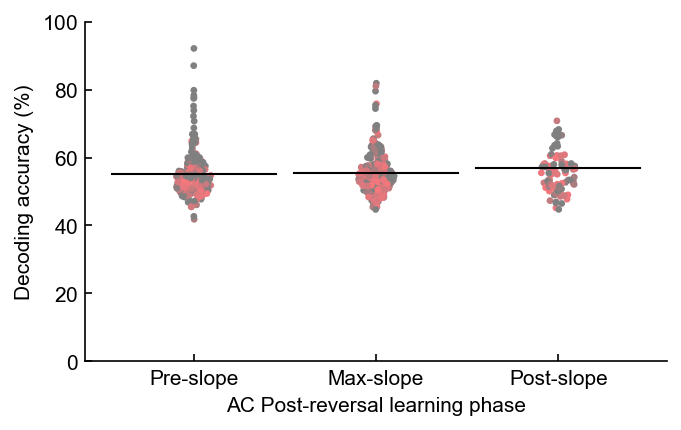

In [488]:
X = np.concatenate(([np.ones(len(Dec_preslope)),np.ones(len(Dec_maxslope))*2,np.ones(len(Dec_postslope))*3]))
Y = np.concatenate((Dec_preslope,Dec_maxslope,Dec_postslope))

colors = NCR_CR_cmap(np.concatenate((FRmod_preslope,FRmod_maxslope,FRmod_postslope))/4)

X,Y = ilep.violin(X,Y,width=0.25)

fig,ax = plt.subplots(figsize=(5,3))
ax.scatter(X,Y*100,color=colors,s=5)
ax.plot([.55,1.45],[np.nanmean(post_early)*100]*2,lw=1,color='k')
ax.plot([1.55,2.45],[np.nanmean(post_int)*100]*2,lw=1,color='k')
ax.plot([2.55,3.45],[np.nanmean(post_late)*100]*2,lw=1,color='k')

ax.set_ylim([0,100])

ax.set_xticks([1,2,3])
ax.set_xticklabels(['Pre-slope','Max-slope','Post-slope'])
ax.set_xlabel('AC Post-reversal learning phase')
ax.set_ylabel('Decoding accuracy (%)')

print('\nsignificance at: ' + str(0.05 / 3))
print('Pre-slope vs Max-slope  : '+str(mannwhitneyu(Dec_preslope,Dec_maxslope).pvalue))
print('Pre-slope vs Post-slope : '+str(mannwhitneyu(Dec_preslope,Dec_postslope).pvalue))
print('Max-slope vs Post-slope : '+str(mannwhitneyu(Dec_maxslope,Dec_postslope).pvalue))

plt.savefig(os.path.join('D:\\\\Figures','Decoding Figures','Summaries','Three-day-slope Learning Phases Accuracy.png'),transparent=False,facecolor="white")

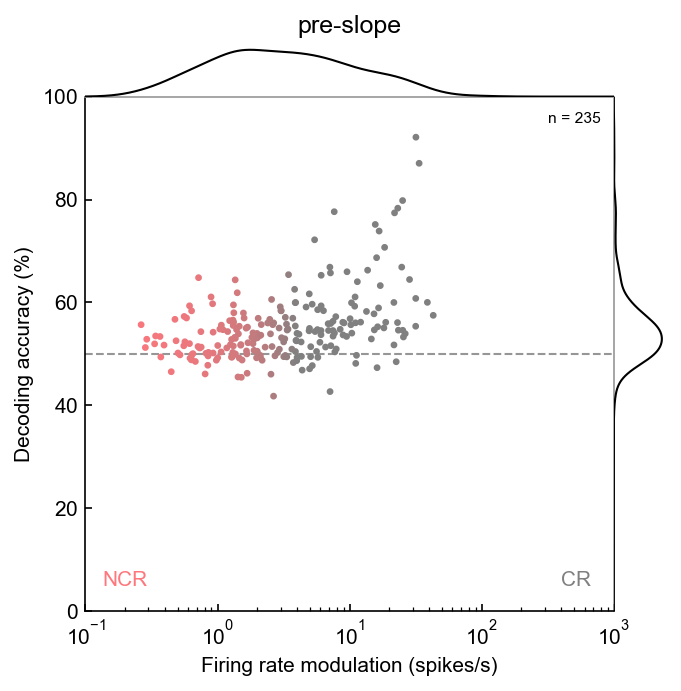

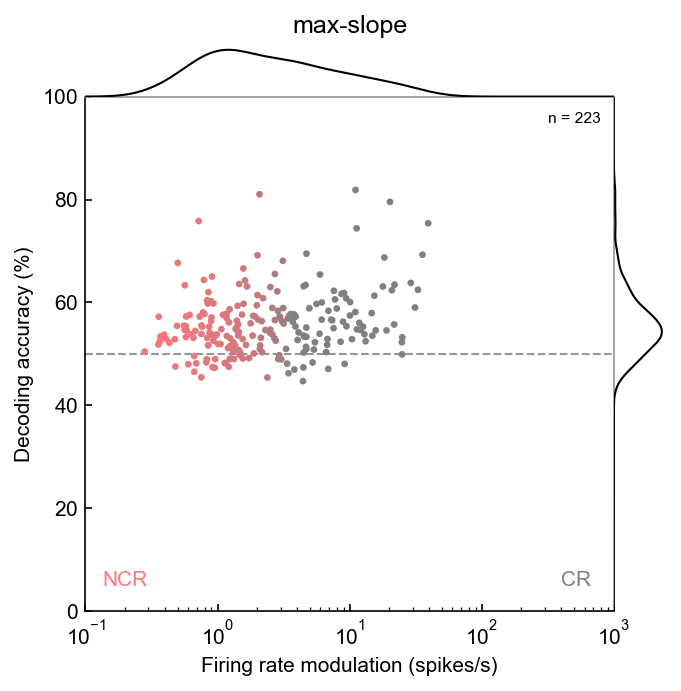

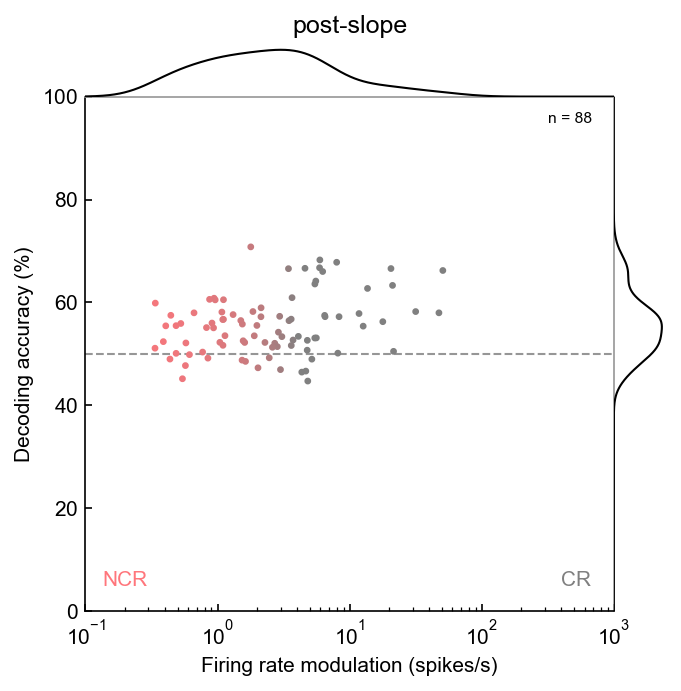

In [496]:
labelstring = 'pre-slope'
data = np.array(Dec_preslope)*100
FRdata = np.array(FRmod_preslope)
plotFRDecodingDist(data,FRdata,labelstring)

labelstring = 'max-slope'
data = np.array(Dec_maxslope)*100
FRdata = np.array(FRmod_maxslope)
plotFRDecodingDist(data,FRdata,labelstring)

labelstring = 'post-slope'
data = np.array(Dec_postslope)*100
FRdata = np.array(FRmod_postslope)
plotFRDecodingDist(data,FRdata,labelstring)

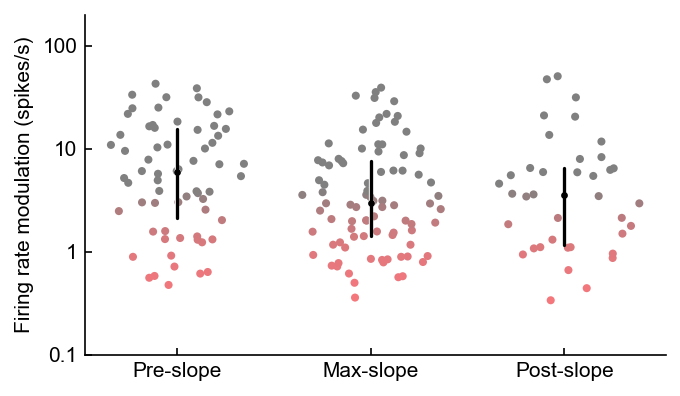

In [504]:
size=15

fig, ax = plt.subplots(figsize=(5,3))
data = [FRmod_preslope,FRmod_maxslope,FRmod_postslope]
labels = ['Pre-slope','Max-slope','Post-slope']
numCon = len(data)
X = [np.ones(len(l))*idx for idx,l in enumerate(data)]

_,Y = ilep.violin(np.concatenate(X),np.concatenate(data))
X,_ = ilep.violin(np.concatenate(X),np.log10(np.concatenate(data)))
colors = NCR_CR_cmap(Y/4)

ax.scatter(X, Y, s=size, c=colors, lw=0)

#Plot summary
for idx,column in enumerate(data):
    summary_color='k'
    summary_size=10
    Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
    ax.scatter([idx], [median], c='w', s=summary_size*1.3*.5, zorder=1)
    ax.scatter([idx], [median], c=summary_color, s=summary_size*.5, zorder=2)
    ax.plot([idx, idx], [Q1, Q3], c='w', lw=np.sqrt(summary_size) * .5 * 1.3, zorder=1, solid_capstyle='round')
    ax.plot([idx, idx], [Q1, Q3], c=summary_color, lw=np.sqrt(summary_size)*.5, zorder=2, solid_capstyle='round')

#ax.scatter([],[], s=50, c=CR_COLOR, zorder=0, lw=0, label='CRs')
#ax.scatter([],[], s=50, c=NCR_COLOR, zorder=0, lw=0, label='NCRs')
#ax.legend(frameon=False)

ax.set_yscale('log',subsy=[])
ax.set_ylim([0.1,200])
ax.set_yticks([0.1,1,10,100])
ax.set_yticklabels(['0.1','1','10','100'])
ax.set_ylabel('Firing rate modulation (spikes/s)')

ax.set_xticks(range(numCon))
ax.set_xticklabels(labels)
pass

plt.savefig(os.path.join('D:\\\\Figures','Decoding Figures','FR modulations','AC Three-day FR modulations '+cellstouse+'.pdf'),transparent=False,facecolor="white")

# FR modulations with shift in resp. V2

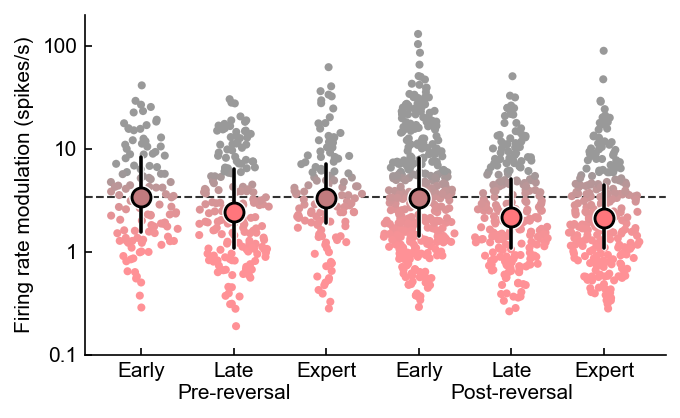

In [890]:
size=15

FRmod_baseline_median = AC_FRmod_baseline_median

fig, ax = plt.subplots(figsize=(5,3))
data = [FRmod_preearly,FRmod_preint,FRmod_prelate,FRmod_postearly,FRmod_postint,FRmod_postlate]
labels = ['Early','Late\nPre-reversal','Expert','Early','Late\nPost-reversal','Expert']
numCon = len(data)
X = [np.ones(len(l))*idx for idx,l in enumerate(data)]

_,Y = ilep.violin(np.concatenate(X),np.concatenate(data))
X,_ = ilep.violin(np.concatenate(X),np.log10(np.concatenate(data)))
colors = NCR_CR_cmap((Y-1)/5)

ax.scatter(X, Y, s=size, c=colors, lw=0,zorder=-5)

#Plot summary
for idx,column in enumerate(data):
    percentCR = np.nanmean(np.greater(column,FRmod_baseline_median))*100
    
    summary_color='k'
    summary_size=12
    median_scale = 7.5
    Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
    shift_in_responsiveness_color = NCR_CR_cmap((percentCR-40)/20)
    ax.scatter([idx], [median], c='w', s=summary_size*1.3*median_scale, zorder=5)
    ax.scatter([idx], [median], c=summary_color, s=summary_size*median_scale, zorder=7)
    ax.scatter([idx], [median], c=shift_in_responsiveness_color, s=summary_size*median_scale*0.5, zorder=8)
    ax.plot([idx, idx], [Q1, Q3], c='w', lw=np.sqrt(summary_size) * .5 * 1.3, zorder=5, solid_capstyle='round')
    ax.plot([idx, idx], [Q1, Q3], c=summary_color, lw=np.sqrt(summary_size)*.5, zorder=6, solid_capstyle='round')

#ax.scatter([],[], s=50, c=CR_COLOR, zorder=0, lw=0, label='CRs')
#ax.scatter([],[], s=50, c=NCR_COLOR, zorder=0, lw=0, label='NCRs')
#ax.legend(frameon=False)

ax.set_yscale('log',subsy=[])
ax.set_ylim([0.1,200])
ax.set_yticks([0.1,1,10,100])
ax.set_yticklabels(['0.1','1','10','100'])
ax.set_ylabel('Firing rate modulation (spikes/s)')

ax.set_xticks(range(numCon))
ax.set_xticklabels(labels)
ax.set_xlim(ax.get_xlim())

ax.fill_between(ax.get_xlim(),[ax.get_ylim()[0]]*2,[ax.get_ylim()[1]]*2,color='white',alpha=0.2,zorder=-4)
ax.axhline(FRmod_baseline_median,color='k',linestyle='--',lw=1,zorder=-11)

pass

plt.savefig(os.path.join('D:\\\\Figures','Decoding Figures','FR modulations','AC FR modulations with shift summary '+cellstouse+'.pdf'),transparent=False,facecolor="white")

# V3

(0.42587136941925297, 0.1957325874788215, 0.2058116582207382)
(0.7313725490196079, 0.0, 0.032030914555603224)
(0.42497644888847286, 0.19616822519737775, 0.20618902331523592)
(0.43128886437047226, 0.19307078940094619, 0.20350369779377214)
(0.7313725490196079, 0.0, 0.032030914555603224)
(0.7313725490196079, 0.0, 0.032030914555603224)
0
0
0
0
0
0

significance at: 0.01 0.002 0.0002 2e-05
0.01963165443338038
0.397934153443129
0.4221291957746146
0.0030554173568034105
0.0003615174091835941
Ttest_indResult(statistic=2.1216128779685057, pvalue=0.03472709328914054)
Ttest_indResult(statistic=-0.09337038119200346, pvalue=0.9256878722646236)
Ttest_indResult(statistic=-0.43619599359241323, pvalue=0.6628890315899947)
Ttest_indResult(statistic=2.736286566672367, pvalue=0.006530562736746968)
Ttest_indResult(statistic=3.440991456794478, pvalue=0.0006461292825646352)


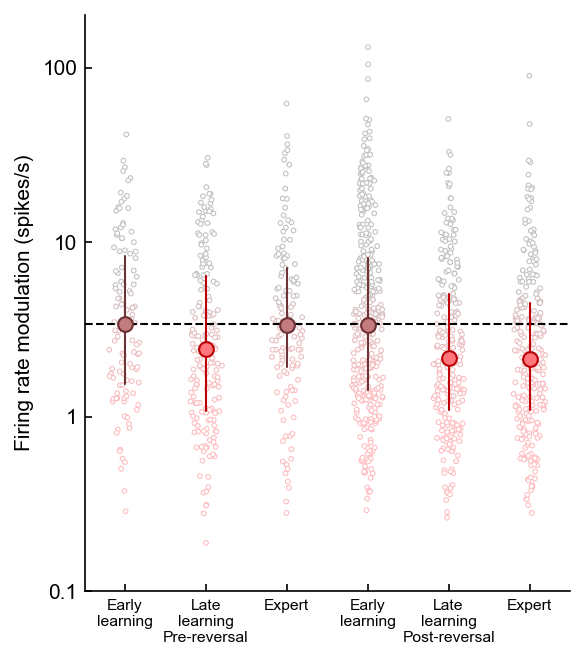

In [1134]:
size=5

FRmod_baseline_median = AC_FRmod_baseline_median

fig, ax = plt.subplots(figsize=(4,4.5))
data = [FRmod_preearly,FRmod_preint,FRmod_prelate,FRmod_postearly,FRmod_postint,FRmod_postlate]
labels = ['Early\nlearning','Late\nlearning\nPre-reversal','Expert','Early\nlearning','Late\nlearning\nPost-reversal','Expert']
numCon = len(data)
X = [np.ones(len(l))*idx for idx,l in enumerate(data)]

_,Y = ilep.violin(np.concatenate(X),np.concatenate(data))
X,_ = ilep.violin(np.concatenate(X),np.log10(np.concatenate(data)),width=0.5)
colors = NCR_CR_cmap((Y-1)/5)

ax.scatter(X, Y, s=size, ec=colors, fc='white', lw=0.5,zorder=-10)

#Plot summary
for idx,column in enumerate(data):
    percentCR = np.nanmean(np.greater(column,FRmod_baseline_median))*100
    
    eye_color=NCR_CR_cmap((percentCR-40)/20)
    
    r,g,b = mpl.colors.to_rgb(eye_color)
    h,l,s = colorsys.rgb_to_hls(r,g,b)
    border_color=colorsys.hls_to_rgb(h,l*0.5,s)
    print(border_color)

    summary_size=50
    summary_width=1
    
    Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
    
    ax.scatter([idx], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
    ax.plot([idx, idx], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')

#ax.scatter([],[], s=50, c=CR_COLOR, zorder=0, lw=0, label='CRs')
#ax.scatter([],[], s=50, c=NCR_COLOR, zorder=0, lw=0, label='NCRs')
#ax.legend(frameon=False)

ax.set_yscale('log',subsy=[])
#ax.set_ylim([0,10])
ax.set_ylim([0.1,200])
ax.set_yticks([0.1,1,10,100])
ax.set_yticklabels(['0.1','1','10','100'])
ax.set_ylabel('Firing rate modulation (spikes/s)')

ax.set_xlim([-0.5,5.5])
ax.set_xticks(range(numCon))
ax.set_xticklabels(labels,fontsize=7.5)
ax.set_xlim(ax.get_xlim())

ax.fill_between(ax.get_xlim(),[ax.get_ylim()[0]]*2,[ax.get_ylim()[1]]*2,color='white',alpha=0.5,zorder=-5)
ax.axhline(FRmod_baseline_median,color='k',linestyle='--',lw=1,zorder=-4)

pass

plt.tight_layout()
#plt.savefig(os.path.join('D:\\\\Figures','Decoding Figures','FR modulations','AC FR modulations with shift summary '+cellstouse+'.pdf'),transparent=False,facecolor="white")

print(np.sum(np.isnan(FRmod_preearly)))
print(np.sum(np.isnan(FRmod_preint)))
print(np.sum(np.isnan(FRmod_prelate)))
print(np.sum(np.isnan(FRmod_postearly)))
print(np.sum(np.isnan(FRmod_postint)))
print(np.sum(np.isnan(FRmod_postlate)))

print('\nsignificance at: ' + str(0.05 / 5)+' '+str(0.01 / 5)+' '+str(0.001 / 5)+' '+str(0.0001 / 5))
print(mannwhitneyu(FRmod_preearly,FRmod_preint).pvalue)
print(mannwhitneyu(FRmod_preearly,FRmod_prelate).pvalue)
print(mannwhitneyu(FRmod_preearly,FRmod_postearly).pvalue)
print(mannwhitneyu(FRmod_preearly,FRmod_postint).pvalue)
print(mannwhitneyu(FRmod_preearly,FRmod_postlate).pvalue)

print(ttest_ind(np.log10(FRmod_preearly),np.log10(FRmod_preint)))
print(ttest_ind(np.log10(FRmod_preearly),np.log10(FRmod_prelate)))
print(ttest_ind(np.log10(FRmod_preearly),np.log10(FRmod_postearly)))
print(ttest_ind(np.log10(FRmod_preearly),np.log10(FRmod_postint)))
print(ttest_ind(np.log10(FRmod_preearly),np.log10(FRmod_postlate)))

In [1135]:
FRmodData = SimpleNamespace()
FRmodData.prereversal_early = FRmod_preearly
FRmodData.prereversal_late = FRmod_preint
FRmodData.prereversal_expert = FRmod_prelate
FRmodData.postreversal_early = FRmod_postearly
FRmodData.postreversal_late = FRmod_postint
FRmodData.postreversal_expert = FRmod_postlate

filename = 'C:\\Users\\insan\\Desktop\\FRmodDataForBadr.pickle'

with open(filename, 'wb') as f:
    pickle.dump(FRmodData, f, protocol=pickle.HIGHEST_PROTOCOL)

In [1136]:
with open(filename, 'rb') as f:
    loadedData = pickle.load(f)

In [1137]:
loadedData

namespace(prereversal_early=array([ 0.86253369,  3.37825696, 23.2884097 ,  1.59928122,  6.88230009,
                                    2.87511231,  0.64690027,  6.34321653, 10.51212938,  1.86761229,
                                    0.57502246,  1.67115903,  0.99688474,  3.55795148,  1.09613657,
                                    1.27583109,  2.04851752,  3.10871518,  1.92273136,  1.00628931,
                                    0.84456424,  3.62982929,  1.22192273,  0.80862534,  4.76190476,
                                    0.55005501,  0.375     ,  8.10422282,  1.40161725,  1.27481714,
                                    2.24618149,  1.22192273,  2.2821204 ,  1.61725067,  1.91528545,
                                    4.43349754, 12.12938005,  2.65947889,  0.28751123,  4.75877193,
                                   10.97933513,  1.36567835,  1.76100629,  0.98831986,  1.26721763,
                                    0.50314465,  1.76100629,  2.58823529,  1.27583109,  0.63492063,


# All task encoders

In [1013]:
pc_task_encoders = np.array([np.nan]*6)
total_phases = ['pre early','pre int','pre late','post early','post int','post late']
labels = ['Early\nlearning','Late\nlearning\nPre-reversal','Expert','Early\nlearning','Late\nlearning\nPost-reversal','Expert']
for phase_idx,phase in enumerate(total_phases):
    
    te_in_phase = 0
    cells_in_phase = 0
    for idx in tqdm(range(len(clusters))):
        if not regions[idx] == 'AC':
            continue

        session = sessionIDs[idx]
        sessionfile = ilep.loadSessionCached(act_directory,session)

        if not sessionfile.meta.animal in animalstouse:
            continue

        if sessionfile.meta.animal == 'BS_67' and sessionfile.meta.day_of_training >= 15:
            continue

        if EILphases[idx] != phase:
            continue
            
        cells_in_phase += 1
        if task_encoders[idx]:
            te_in_phase += 1
    
    pc_task_encoders[phase_idx] = np.sum(te_in_phase) / np.sum(cells_in_phase)

100%|██████████| 5801/5801 [00:12<00:00, 476.06it/s] 


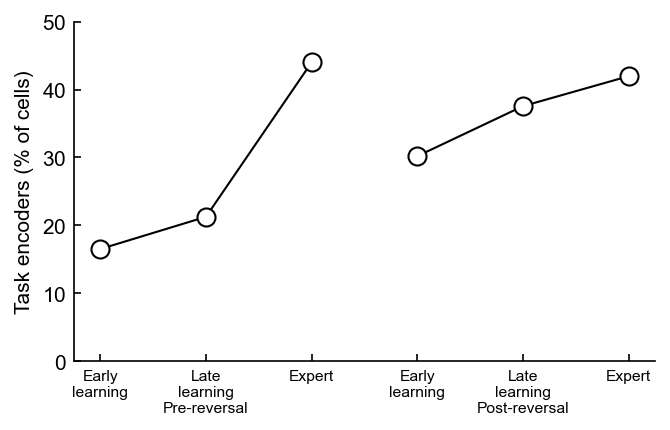

In [1020]:
fig, ax = plt.subplots(figsize=(5,3))
chosen_color='k'
ax.plot([0,1,2],pc_task_encoders[0:3]*100,color=chosen_color,linestyle='-',zorder=-1,lw=1)
ax.plot([3,4,5],pc_task_encoders[3:6]*100,color=chosen_color,linestyle='-',zorder=-1,lw=1)
ax.scatter([0,1,2],pc_task_encoders[0:3]*100,fc='white',ec=chosen_color,s=75)
ax.scatter([3,4,5],pc_task_encoders[3:6]*100,fc='white',ec=chosen_color,s=75)

ax.set_ylim([0,50])
ax.set_ylabel('Task encoders (% of cells)')

ax.set_xticks(range(6))
ax.set_xticklabels(labels,fontsize=7.5)

plt.savefig(os.path.join('D:\\\\Figures','Decoding Figures','Summaries','Task encoders over learning.pdf'),transparent=False,facecolor="white")

# CR/NCR task encoders

In [1010]:
FRmod_baseline_median = AC_FRmod_baseline_median

NCR_pc_task_encoders = np.array([np.nan]*6)
CR_pc_task_encoders = np.array([np.nan]*6)
NCR_allpc_task_encoders = np.array([np.nan]*6)
CR_allpc_task_encoders = np.array([np.nan]*6)
total_phases = ['pre early','pre int','pre late','post early','post int','post late']
labels = ['Early\nlearning','Late\nlearning\nPre-reversal','Expert','Early\nlearning','Late\nlearning\nPost-reversal','Expert']
for phase_idx,phase in enumerate(total_phases):
    
    CR_te_in_phase = 0
    CR_cells_in_phase = 0
    NCR_te_in_phase = 0
    NCR_cells_in_phase = 0
    for idx in tqdm(range(len(clusters))):
        if not regions[idx] == 'AC':
            continue

        session = sessionIDs[idx]
        sessionfile = ilep.loadSessionCached(act_directory,session)

        if not sessionfile.meta.animal in animalstouse:
            continue

        if sessionfile.meta.animal == 'BS_67' and sessionfile.meta.day_of_training >= 15:
            continue

        if EILphases[idx] != phase:
            continue
            
        if FRmods[idx] < FRmod_baseline_median:
            if task_encoders[idx]:
                NCR_te_in_phase += 1
            NCR_cells_in_phase += 1
        elif FRmods[idx] >= FRmod_baseline_median:
            if task_encoders[idx]:
                CR_te_in_phase += 1
            CR_cells_in_phase += 1
            
        cells_in_phase += 1
        if task_encoders[idx]:
            te_in_phase += 1
    
    CR_pc_task_encoders[phase_idx] = np.sum(CR_te_in_phase) / (np.sum(CR_cells_in_phase))
    NCR_pc_task_encoders[phase_idx] = np.sum(NCR_te_in_phase) / (np.sum(NCR_cells_in_phase))
    
    CR_allpc_task_encoders[phase_idx] = np.sum(CR_te_in_phase) / (np.sum(CR_cells_in_phase)+np.sum(NCR_cells_in_phase))
    NCR_allpc_task_encoders[phase_idx] = np.sum(NCR_te_in_phase) / (np.sum(NCR_cells_in_phase)+np.sum(CR_cells_in_phase))

100%|██████████| 5801/5801 [00:11<00:00, 495.11it/s] 


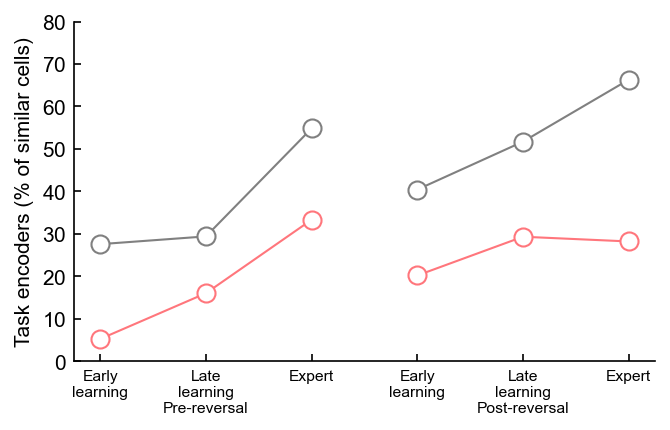

In [1011]:
fig, ax = plt.subplots(figsize=(5,3))
#chosen_color='#25d964'

ax.plot([0,1,2],CR_pc_task_encoders[0:3]*100,color=CR_COLOR,linestyle='-',zorder=-1,lw=1)
ax.plot([3,4,5],CR_pc_task_encoders[3:6]*100,color=CR_COLOR,linestyle='-',zorder=-1,lw=1)
ax.scatter(range(6),CR_pc_task_encoders*100,fc='white',ec=CR_COLOR,s=75)

ax.plot([0,1,2],NCR_pc_task_encoders[0:3]*100,color=NCR_COLOR,linestyle='-',zorder=-1,lw=1)
ax.plot([3,4,5],NCR_pc_task_encoders[3:6]*100,color=NCR_COLOR,linestyle='-',zorder=-1,lw=1)
ax.scatter(range(6),NCR_pc_task_encoders*100,fc='white',ec=NCR_COLOR,s=75)

ax.set_ylim([0,80])
ax.set_ylabel('Task encoders (% of similar cells)')

ax.set_xticks(range(6))
ax.set_xticklabels(labels,fontsize=7.5)

plt.savefig(os.path.join('D:\\\\Figures','Decoding Figures','Summaries','CR-NCR similar cells task encoders over learning.pdf'),transparent=False,facecolor="white")

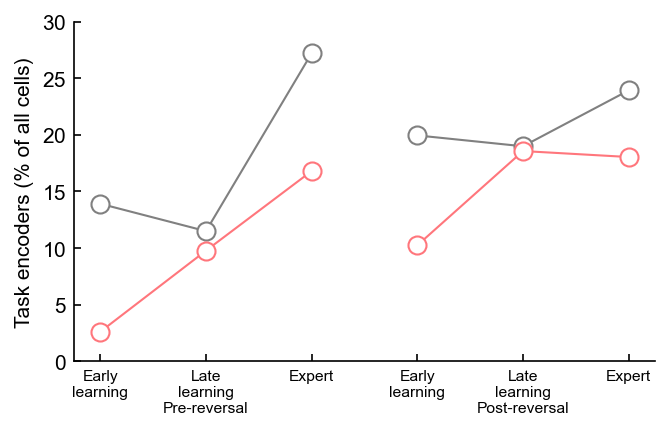

In [1012]:
fig, ax = plt.subplots(figsize=(5,3))
#chosen_color='#25d964'

ax.plot([0,1,2],CR_allpc_task_encoders[0:3]*100,color=CR_COLOR,linestyle='-',zorder=-1,lw=1)
ax.plot([3,4,5],CR_allpc_task_encoders[3:6]*100,color=CR_COLOR,linestyle='-',zorder=-1,lw=1)
ax.scatter(range(6),CR_allpc_task_encoders*100,fc='white',ec=CR_COLOR,s=75)

ax.plot([0,1,2],NCR_allpc_task_encoders[0:3]*100,color=NCR_COLOR,linestyle='-',zorder=-1,lw=1)
ax.plot([3,4,5],NCR_allpc_task_encoders[3:6]*100,color=NCR_COLOR,linestyle='-',zorder=-1,lw=1)
ax.scatter(range(6),NCR_allpc_task_encoders*100,fc='white',ec=NCR_COLOR,s=75)

ax.set_ylim([0,30])
ax.set_ylabel('Task encoders (% of all cells)')

ax.set_xticks(range(6))
ax.set_xticklabels(labels,fontsize=7.5)

plt.savefig(os.path.join('D:\\\\Figures','Decoding Figures','Summaries','CR-NCR all cells task encoders over learning.pdf'),transparent=False,facecolor="white")

In [1111]:
FRb_preearly = []
FRb_preint = []
FRb_prelate = []
FRb_postearly = []
FRb_postint = []
FRb_postlate = []

FRe_preearly = []
FRe_preint = []
FRe_prelate = []
FRe_postearly = []
FRe_postint = []
FRe_postlate = []

FReT_preearly = []
FReT_preint = []
FReT_prelate = []
FReT_postearly = []
FReT_postint = []
FReT_postlate = []

FReNT_preearly = []
FReNT_preint = []
FReNT_prelate = []
FReNT_postearly = []
FReNT_postint = []
FReNT_postlate = []

FRt_preearly = []
FRt_preint = []
FRt_prelate = []
FRt_postearly = []
FRt_postint = []
FRt_postlate = []

Dec_preearly = []
Dec_preint = []
Dec_prelate = []
Dec_postearly = []
Dec_postint = []
Dec_postlate = []

N = 0

animalstouse = ['BS_40','BS_41','BS_42','BS_49','BS_51','BS_56','BS_59','BS_61','BS_67','BS_70','BS_72','BS_87','BS_108','DS_15','DS_19']

cellstouse = 'all cells'
#cellstouse = 'task encoders'

for idx,clust in tqdm(enumerate(clusters)):
    if not regions[idx] == 'AC':
        continue
    
    if cellstouse == 'task encoders':
        if not np.isfinite(accuracies[idx]) or pvals[idx] > 0.05 or accuracies[idx] < task_encoder_threshold:
            continue
        
    session = sessionIDs[idx]
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    if not sessionfile.meta.animal in animalstouse:
        continue
        
    if sessionfile.meta.animal == 'BS_67' and sessionfile.meta.day_of_training >= 15:
        continue
        
    if np.isnan(accuracies[idx]):
        continue
        
    N+=1
        
    if EILphases[idx] == 'pre early':
        FRb_preearly.append(sessionfile.responsiveness[clust]['all_trials'].FRbaseline)
        FRe_preearly.append(sessionfile.responsiveness[clust]['all_trials'].FR)
        FReT_preearly.append(sessionfile.responsiveness[clust]['target_tone'].FR)
        FReNT_preearly.append(sessionfile.responsiveness[clust]['nontarget_tone'].FR)
        FRt_preearly.append( (sessionfile.responsiveness[clust]['target_tone'].FRmodulation-sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation) / max(sessionfile.responsiveness[clust]['target_tone'].FRmodulation,sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation))
        Dec_preearly.append(accuracies[idx])
    elif EILphases[idx] == 'pre int':
        FRb_preint.append(sessionfile.responsiveness[clust]['all_trials'].FRbaseline)
        FRe_preint.append(sessionfile.responsiveness[clust]['all_trials'].FR)
        FReT_preint.append(sessionfile.responsiveness[clust]['target_tone'].FR)
        FReNT_preint.append(sessionfile.responsiveness[clust]['nontarget_tone'].FR)
        FRt_preint.append( (sessionfile.responsiveness[clust]['target_tone'].FRmodulation-sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation) / max(sessionfile.responsiveness[clust]['target_tone'].FRmodulation,sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation))
        Dec_preint.append(accuracies[idx])
    elif EILphases[idx] == 'pre late':
        FRb_prelate.append(sessionfile.responsiveness[clust]['all_trials'].FRbaseline)
        FRe_prelate.append(sessionfile.responsiveness[clust]['all_trials'].FR)
        FReT_prelate.append(sessionfile.responsiveness[clust]['target_tone'].FR)
        FReNT_prelate.append(sessionfile.responsiveness[clust]['nontarget_tone'].FR)
        FRt_prelate.append( (sessionfile.responsiveness[clust]['target_tone'].FRmodulation-sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation) / max(sessionfile.responsiveness[clust]['target_tone'].FRmodulation,sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation))
        Dec_prelate.append(accuracies[idx])
    elif EILphases[idx] == 'post early':
        FRb_postearly.append(sessionfile.responsiveness[clust]['all_trials'].FRbaseline)
        FRe_postearly.append(sessionfile.responsiveness[clust]['all_trials'].FR)
        FReT_postearly.append(sessionfile.responsiveness[clust]['target_tone'].FR)
        FReNT_postearly.append(sessionfile.responsiveness[clust]['nontarget_tone'].FR)
        FRt_postearly.append( (sessionfile.responsiveness[clust]['target_tone'].FRmodulation-sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation) / max(sessionfile.responsiveness[clust]['target_tone'].FRmodulation,sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation))
        Dec_postearly.append(accuracies[idx])
    elif EILphases[idx] == 'post int':
        FRb_postint.append(sessionfile.responsiveness[clust]['all_trials'].FRbaseline)
        FRe_postint.append(sessionfile.responsiveness[clust]['all_trials'].FR)
        FReT_postint.append(sessionfile.responsiveness[clust]['target_tone'].FR)
        FReNT_postint.append(sessionfile.responsiveness[clust]['nontarget_tone'].FR)
        FRt_postint.append( (sessionfile.responsiveness[clust]['target_tone'].FRmodulation-sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation) / max(sessionfile.responsiveness[clust]['target_tone'].FRmodulation,sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation))
        Dec_postint.append(accuracies[idx])
    elif EILphases[idx] == 'post late':
        FRb_postlate.append(sessionfile.responsiveness[clust]['all_trials'].FRbaseline)
        FRe_postlate.append(sessionfile.responsiveness[clust]['all_trials'].FR)
        FReT_postlate.append(sessionfile.responsiveness[clust]['target_tone'].FR)
        FReNT_postlate.append(sessionfile.responsiveness[clust]['nontarget_tone'].FR)
        FRt_postlate.append( (sessionfile.responsiveness[clust]['target_tone'].FRmodulation-sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation) / max(sessionfile.responsiveness[clust]['target_tone'].FRmodulation,sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation))
        Dec_postlate.append(accuracies[idx])
        
FRb_preearly = np.array(FRb_preearly)
FRb_preint = np.array(FRb_preint)
FRb_prelate = np.array(FRb_prelate)
FRb_postearly = np.array(FRb_postearly)
FRb_postint = np.array(FRb_postint)
FRb_postlate = np.array(FRb_postlate)

FRe_preearly = np.array(FRe_preearly)
FRe_preint = np.array(FRe_preint)
FRe_prelate = np.array(FRe_prelate)
FRe_postearly = np.array(FRe_postearly)
FRe_postint = np.array(FRe_postint)
FRe_postlate = np.array(FRe_postlate)

FReT_preearly = np.array(FReT_preearly)
FReT_preint = np.array(FReT_preint)
FReT_prelate = np.array(FReT_prelate)
FReT_postearly = np.array(FReT_postearly)
FReT_postint = np.array(FReT_postint)
FReT_postlate = np.array(FReT_postlate)

FReNT_preearly = np.array(FReNT_preearly)
FReNT_preint = np.array(FReNT_preint)
FReNT_prelate = np.array(FReNT_prelate)
FReNT_postearly = np.array(FReNT_postearly)
FReNT_postint = np.array(FReNT_postint)
FReNT_postlate = np.array(FReNT_postlate)

FRt_preearly = np.array(FRt_preearly)
FRt_preint = np.array(FRt_preint)
FRt_prelate = np.array(FRt_prelate)
FRt_postearly = np.array(FRt_postearly)
FRt_postint = np.array(FRt_postint)
FRt_postlate = np.array(FRt_postlate)

Dec_preearly = np.array(Dec_preearly)
Dec_preint = np.array(Dec_preint)
Dec_prelate = np.array(Dec_prelate)
Dec_postearly = np.array(Dec_postearly)
Dec_postint = np.array(Dec_postint)
Dec_postlate = np.array(Dec_postlate)

print('spontaneous '+str(0.05/4)+' '+str(0.01/4)+' '+str(0.001/4)+' '+str(0.0001/4))
print(mannwhitneyu(FRb_preearly,FRb_preint).pvalue)
print(mannwhitneyu(FRb_preearly,FRb_prelate).pvalue)
print(mannwhitneyu(FRb_postearly,FRb_postint).pvalue)
print(mannwhitneyu(FRb_postearly,FRb_postlate).pvalue)

print()
print('evoked: '+str(0.05/4)+' '+str(0.01/4)+' '+str(0.001/4)+' '+str(0.0001/4))
print(mannwhitneyu(FRe_preearly,FRe_preint).pvalue)
print(mannwhitneyu(FRe_preearly,FRe_prelate).pvalue)
print(mannwhitneyu(FRe_postearly,FRe_postint).pvalue)
print(mannwhitneyu(FRe_postearly,FRe_postlate).pvalue)

print()
print('tuning '+str(0.05/4)+' '+str(0.01/4)+' '+str(0.001/4)+' '+str(0.0001/4))
print(mannwhitneyu(FRt_preearly,FRt_preint).pvalue)
print(mannwhitneyu(FRt_preearly,FRt_prelate).pvalue)
print(mannwhitneyu(FRt_postearly,FRt_postint).pvalue)
print(mannwhitneyu(FRt_postearly,FRt_postlate).pvalue)

5801it [00:11, 491.05it/s] 

evoked: 0.0125 0.0025 0.00025 2.5e-05
0.0022034423487598378
0.21920213597585675
0.009424957840085344
0.016727113103156825

spontaneous 0.0125 0.0025 0.00025 2.5e-05
0.18329689841925711
0.4661935668226064
0.14283021093616466
0.0454671689443205

tuning 0.0125 0.0025 0.00025 2.5e-05
9.036293477388274e-08
0.0005356058470305565
0.000997469033462283
8.773723502778695e-12


# Spontaneous

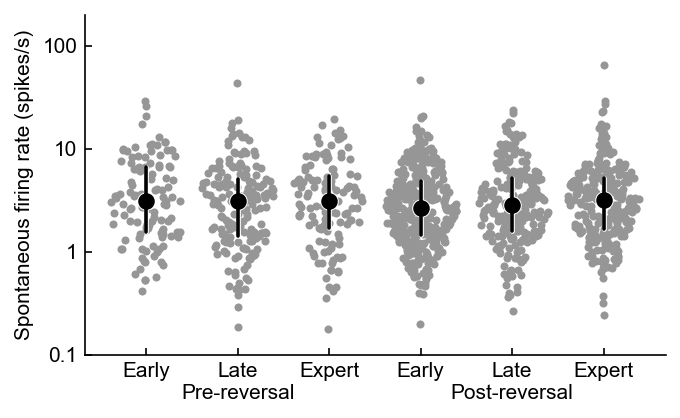

In [687]:
size=15

fig, ax = plt.subplots(figsize=(5,3))
data = [FRb_preearly,FRb_preint,FRb_prelate,FRb_postearly,FRb_postint,FRb_postlate]
labels = ['Early','Late\nPre-reversal','Expert','Early','Late\nPost-reversal','Expert']
numCon = len(data)
X = [np.ones(len(l))*idx for idx,l in enumerate(data)]

_,Y = ilep.violin(np.concatenate(X),np.concatenate(data))
X,_ = ilep.violin(np.concatenate(X),np.log10(np.concatenate(data)))
colors = NCR_CR_cmap((Y-1)/5)

ax.scatter(X, Y, s=size, c=GOOD_GREY, lw=0)

#Plot summary
for idx,column in enumerate(data):
    summary_color='k'
    summary_size=12
    median_scale = 4
    Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
    ax.scatter([idx], [median], c='w', s=summary_size*1.3*median_scale, zorder=5)
    ax.scatter([idx], [median], c=summary_color, s=summary_size*median_scale, zorder=7)
    #ax.scatter([idx], [median], c=GOOD_GREY, s=summary_size*median_scale*0.5, zorder=8)
    ax.plot([idx, idx], [Q1, Q3], c='w', lw=np.sqrt(summary_size) * .5 * 1.3, zorder=5, solid_capstyle='round')
    ax.plot([idx, idx], [Q1, Q3], c=summary_color, lw=np.sqrt(summary_size)*.5, zorder=6, solid_capstyle='round')

#ax.scatter([],[], s=50, c=CR_COLOR, zorder=0, lw=0, label='CRs')
#ax.scatter([],[], s=50, c=NCR_COLOR, zorder=0, lw=0, label='NCRs')
#ax.legend(frameon=False)

ax.set_yscale('log',subsy=[])
ax.set_ylim([0.1,200])
ax.set_yticks([0.1,1,10,100])
ax.set_yticklabels(['0.1','1','10','100'])
ax.set_ylabel('Spontaneous firing rate (spikes/s)')

ax.set_xticks(range(numCon))
ax.set_xticklabels(labels)
pass

plt.savefig(os.path.join('D:\\\\Figures','Decoding Figures','FR modulations','AC Spontaneous FR '+cellstouse+'.pdf'),transparent=False,facecolor="white")

# Evoked

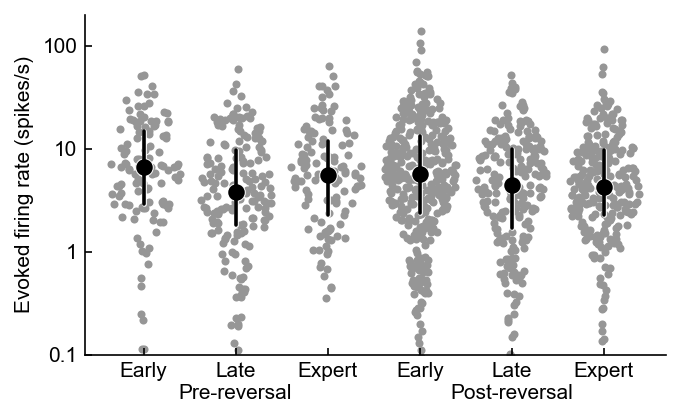

In [688]:
size=15

fig, ax = plt.subplots(figsize=(5,3))
data = [FRe_preearly,FRe_preint,FRe_prelate,FRe_postearly,FRe_postint,FRe_postlate]
labels = ['Early','Late\nPre-reversal','Expert','Early','Late\nPost-reversal','Expert']
numCon = len(data)
X = [np.ones(len(l))*idx for idx,l in enumerate(data)]

_,Y = ilep.violin(np.concatenate(X),np.concatenate(data))
X,_ = ilep.violin(np.concatenate(X),np.log10(np.concatenate(data)))
colors = NCR_CR_cmap((Y-1)/5)

ax.scatter(X, Y, s=size, c=GOOD_GREY, lw=0)

#Plot summary
for idx,column in enumerate(data):
    summary_color='k'
    summary_size=12
    median_scale = 4
    Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
    ax.scatter([idx], [median], c='w', s=summary_size*1.3*median_scale, zorder=5)
    ax.scatter([idx], [median], c=summary_color, s=summary_size*median_scale, zorder=7)
    #ax.scatter([idx], [median], c=GOOD_GREY, s=summary_size*median_scale*0.5, zorder=8)
    ax.plot([idx, idx], [Q1, Q3], c='w', lw=np.sqrt(summary_size) * .5 * 1.3, zorder=5, solid_capstyle='round')
    ax.plot([idx, idx], [Q1, Q3], c=summary_color, lw=np.sqrt(summary_size)*.5, zorder=6, solid_capstyle='round')

#ax.scatter([],[], s=50, c=CR_COLOR, zorder=0, lw=0, label='CRs')
#ax.scatter([],[], s=50, c=NCR_COLOR, zorder=0, lw=0, label='NCRs')
#ax.legend(frameon=False)

ax.set_yscale('log',subsy=[])
ax.set_ylim([0.1,200])
ax.set_yticks([0.1,1,10,100])
ax.set_yticklabels(['0.1','1','10','100'])
ax.set_ylabel('Evoked firing rate (spikes/s)')

ax.set_xticks(range(numCon))
ax.set_xticklabels(labels)
pass

plt.savefig(os.path.join('D:\\\\Figures','Decoding Figures','FR modulations','AC Evoked FR '+cellstouse+'.pdf'),transparent=False,facecolor="white")

# Evoked - Target

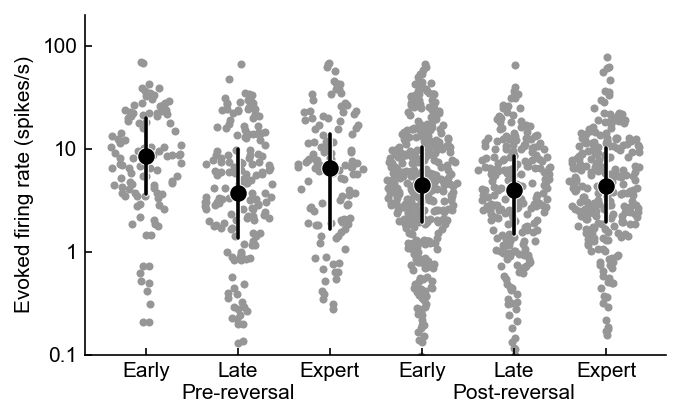

In [807]:
size=15

fig, ax = plt.subplots(figsize=(5,3))
data = [FReT_preearly,FReT_preint,FReT_prelate,FReT_postearly,FReT_postint,FReT_postlate]
labels = ['Early','Late\nPre-reversal','Expert','Early','Late\nPost-reversal','Expert']
numCon = len(data)
X = [np.ones(len(l))*idx for idx,l in enumerate(data)]

_,Y = ilep.violin(np.concatenate(X),np.concatenate(data))
X,_ = ilep.violin(np.concatenate(X),np.log10(np.concatenate(data)))
colors = NCR_CR_cmap((Y-1)/5)

ax.scatter(X, Y, s=size, c=GOOD_GREY, lw=0)

#Plot summary
for idx,column in enumerate(data):
    summary_color='k'
    summary_size=12
    median_scale = 4
    Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
    ax.scatter([idx], [median], c='w', s=summary_size*1.3*median_scale, zorder=5)
    ax.scatter([idx], [median], c=summary_color, s=summary_size*median_scale, zorder=7)
    #ax.scatter([idx], [median], c=GOOD_GREY, s=summary_size*median_scale*0.5, zorder=8)
    ax.plot([idx, idx], [Q1, Q3], c='w', lw=np.sqrt(summary_size) * .5 * 1.3, zorder=5, solid_capstyle='round')
    ax.plot([idx, idx], [Q1, Q3], c=summary_color, lw=np.sqrt(summary_size)*.5, zorder=6, solid_capstyle='round')

#ax.scatter([],[], s=50, c=CR_COLOR, zorder=0, lw=0, label='CRs')
#ax.scatter([],[], s=50, c=NCR_COLOR, zorder=0, lw=0, label='NCRs')
#ax.legend(frameon=False)

ax.set_yscale('log',subsy=[])
ax.set_ylim([0.1,200])
ax.set_yticks([0.1,1,10,100])
ax.set_yticklabels(['0.1','1','10','100'])
ax.set_ylabel('Evoked firing rate (spikes/s)')

ax.set_xticks(range(numCon))
ax.set_xticklabels(labels)
pass

plt.savefig(os.path.join('D:\\\\Figures','Decoding Figures','FR modulations','AC Target Evoked FR '+cellstouse+'.pdf'),transparent=False,facecolor="white")

# Evoked - Nontarget

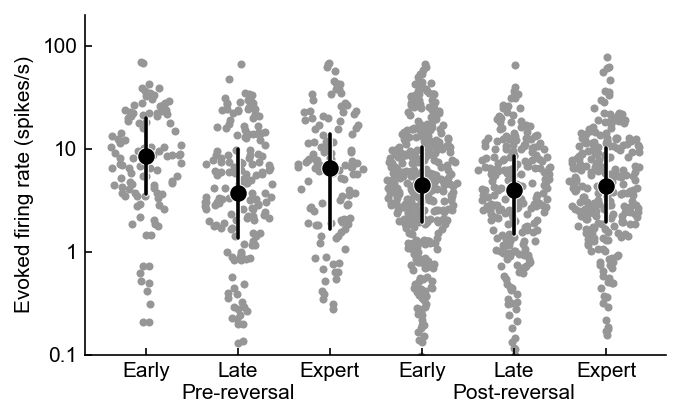

In [807]:
size=15

fig, ax = plt.subplots(figsize=(5,3))
data = [FReNT_preearly,FReNT_preint,FReNT_prelate,FReNT_postearly,FReNT_postint,FReNT_postlate]
labels = ['Early','Late\nPre-reversal','Expert','Early','Late\nPost-reversal','Expert']
numCon = len(data)
X = [np.ones(len(l))*idx for idx,l in enumerate(data)]

_,Y = ilep.violin(np.concatenate(X),np.concatenate(data))
X,_ = ilep.violin(np.concatenate(X),np.log10(np.concatenate(data)))
colors = NCR_CR_cmap((Y-1)/5)

ax.scatter(X, Y, s=size, c=GOOD_GREY, lw=0)

#Plot summary
for idx,column in enumerate(data):
    summary_color='k'
    summary_size=12
    median_scale = 4
    Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
    ax.scatter([idx], [median], c='w', s=summary_size*1.3*median_scale, zorder=5)
    ax.scatter([idx], [median], c=summary_color, s=summary_size*median_scale, zorder=7)
    #ax.scatter([idx], [median], c=GOOD_GREY, s=summary_size*median_scale*0.5, zorder=8)
    ax.plot([idx, idx], [Q1, Q3], c='w', lw=np.sqrt(summary_size) * .5 * 1.3, zorder=5, solid_capstyle='round')
    ax.plot([idx, idx], [Q1, Q3], c=summary_color, lw=np.sqrt(summary_size)*.5, zorder=6, solid_capstyle='round')

#ax.scatter([],[], s=50, c=CR_COLOR, zorder=0, lw=0, label='CRs')
#ax.scatter([],[], s=50, c=NCR_COLOR, zorder=0, lw=0, label='NCRs')
#ax.legend(frameon=False)

ax.set_yscale('log',subsy=[])
ax.set_ylim([0.1,200])
ax.set_yticks([0.1,1,10,100])
ax.set_yticklabels(['0.1','1','10','100'])
ax.set_ylabel('Evoked firing rate (spikes/s)')

ax.set_xticks(range(numCon))
ax.set_xticklabels(labels)
pass

plt.savefig(os.path.join('D:\\\\Figures','Decoding Figures','FR modulations','AC Nontarget Evoked FR '+cellstouse+'.pdf'),transparent=False,facecolor="white")

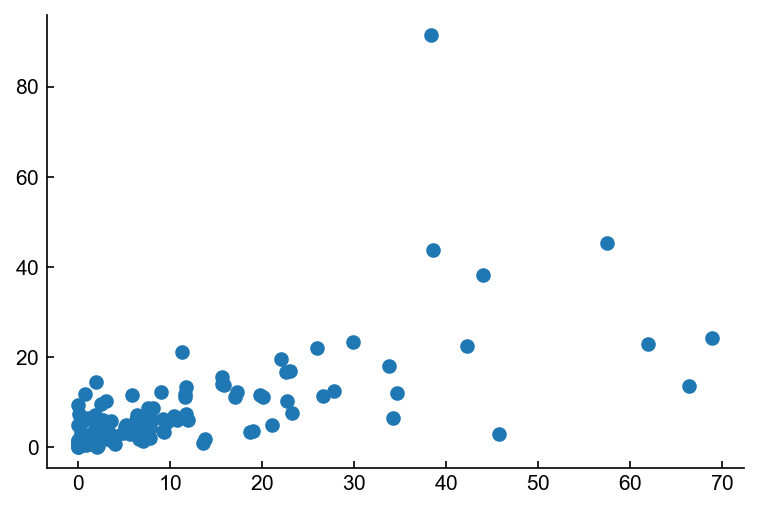

In [813]:
plt.scatter(FReT_prelate,FReNT_prelate)

In [719]:
print('Spontaneous Significances: p < '+str(0.05/7))
print('pre-early,pre-late     :'+str(mannwhitneyu(FRb_preearly,FRb_preint).pvalue))
print('pre-early,pre-expert   :'+str(mannwhitneyu(FRb_preearly,FRb_prelate).pvalue))
print('pre-late,pre-expert    :'+str(mannwhitneyu(FRb_preint,FRb_prelate).pvalue))
print('pre-expert,post-early  :'+str(mannwhitneyu(FRb_prelate,FRb_postearly).pvalue))
print('post-early,post-late   :'+str(mannwhitneyu(FRb_postearly,FRb_postint).pvalue))
print('post-early,post-expert :'+str(mannwhitneyu(FRb_postearly,FRb_postlate).pvalue))
print('post-late,post-expert  :'+str(mannwhitneyu(FRb_postlate,FRb_postlate).pvalue))

print()
print('Evoked Significances: p < '+str(0.05/7))
print('pre-early,pre-late     :'+str(mannwhitneyu(FRe_preearly,FRe_preint).pvalue))
print('pre-early,pre-expert   :'+str(mannwhitneyu(FRe_preearly,FRe_prelate).pvalue))
print('pre-late,pre-expert    :'+str(mannwhitneyu(FRe_preint,FRe_prelate).pvalue))
print('pre-expert,post-early  :'+str(mannwhitneyu(FRe_prelate,FRe_postearly).pvalue))
print('post-early,post-late   :'+str(mannwhitneyu(FRe_postearly,FRe_postint).pvalue))
print('post-early,post-expert :'+str(mannwhitneyu(FRe_postearly,FRe_postlate).pvalue))
print('post-late,post-expert  :'+str(mannwhitneyu(FRe_postlate,FRe_postlate).pvalue))

Spontaneous Significances: p < 0.0071428571428571435
pre-early,pre-late     :0.13769219259584892
pre-early,pre-expert   :0.411636830104011
pre-late,pre-expert    :0.19105257764562494
pre-expert,post-early  :0.08013717494529199
post-early,post-late   :0.1534898960388748
post-early,post-expert :0.056685153844663036
post-late,post-expert  :0.4998801266725263

Evoked Significances: p < 0.0071428571428571435
pre-early,pre-late     :0.002041026459247018
pre-early,pre-expert   :0.19545008064044017
pre-late,pre-expert    :0.02490231331909759
pre-expert,post-early  :0.3908601489632584
post-early,post-late   :0.006545481298723171
post-early,post-expert :0.009333292768164678
post-late,post-expert  :0.4998801265857721


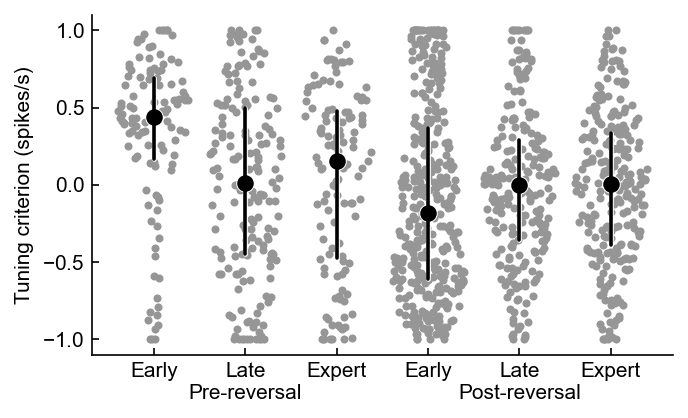

In [804]:
size=15

fig, ax = plt.subplots(figsize=(5,3))
data = [FRt_preearly,FRt_preint,FRt_prelate,FRt_postearly,FRt_postint,FRt_postlate]
labels = ['Early','Late\nPre-reversal','Expert','Early','Late\nPost-reversal','Expert']
numCon = len(data)
X = [np.ones(len(l))*idx for idx,l in enumerate(data)]

X,Y = ilep.violin(np.concatenate(X),np.concatenate(data))
#X,_ = ilep.violin(np.concatenate(X),np.log10(np.concatenate(data)))
colors = NCR_CR_cmap((Y-1)/5)

ax.scatter(X, Y, s=size, c=GOOD_GREY, lw=0)

#Plot summary
for idx,column in enumerate(data):
    summary_color='k'
    summary_size=12
    median_scale = 4
    Q1, median, Q3 = (np.nanpercentile(column, q) for q in [25, 50, 75])
    ax.scatter([idx], [median], c='w', s=summary_size*1.3*median_scale, zorder=5)
    ax.scatter([idx], [median], c=summary_color, s=summary_size*median_scale, zorder=7)
    #ax.scatter([idx], [median], c=GOOD_GREY, s=summary_size*median_scale*0.5, zorder=8)
    ax.plot([idx, idx], [Q1, Q3], c='w', lw=np.sqrt(summary_size) * .5 * 1.3, zorder=5, solid_capstyle='round')
    ax.plot([idx, idx], [Q1, Q3], c=summary_color, lw=np.sqrt(summary_size)*.5, zorder=6, solid_capstyle='round')

#ax.scatter([],[], s=50, c=CR_COLOR, zorder=0, lw=0, label='CRs')
#ax.scatter([],[], s=50, c=NCR_COLOR, zorder=0, lw=0, label='NCRs')
#ax.legend(frameon=False)

#ax.set_yscale('log',subsy=[])
#ax.set_ylim([0.1,200])
#ax.set_yticks([0.1,1,10,100])
#ax.set_yticklabels(['0.1','1','10','100'])
ax.set_ylabel('Tuning criterion (spikes/s)')

ax.set_xticks(range(numCon))
ax.set_xticklabels(labels)
pass

plt.savefig(os.path.join('D:\\\\Figures','Decoding Figures','FR modulations','AC Tuning '+cellstouse+'.pdf'),transparent=False,facecolor="white")

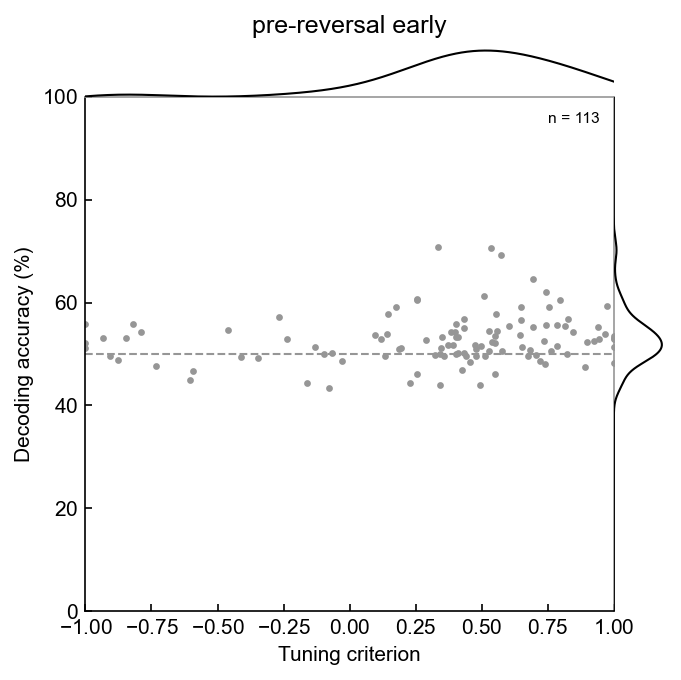

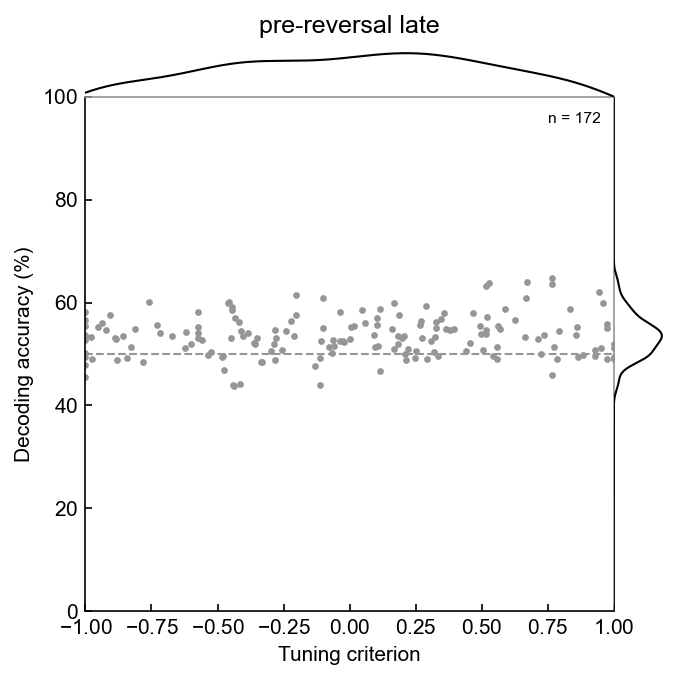

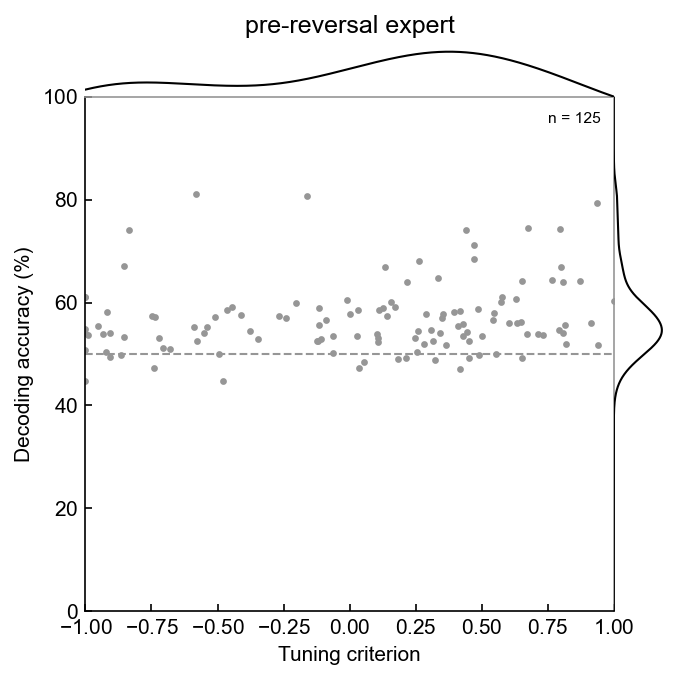

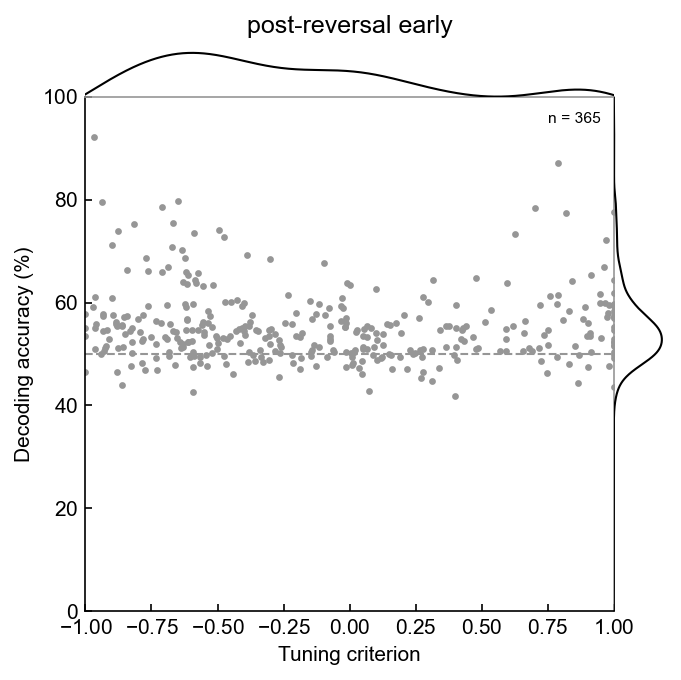

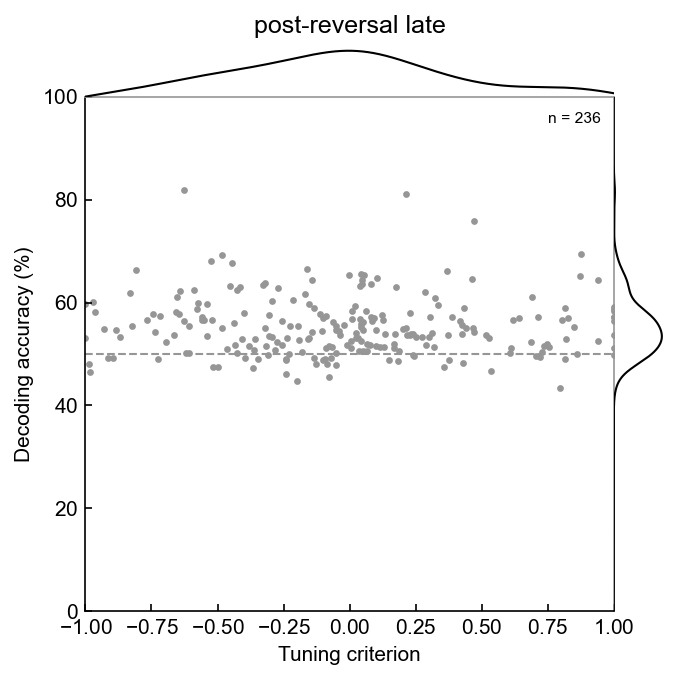

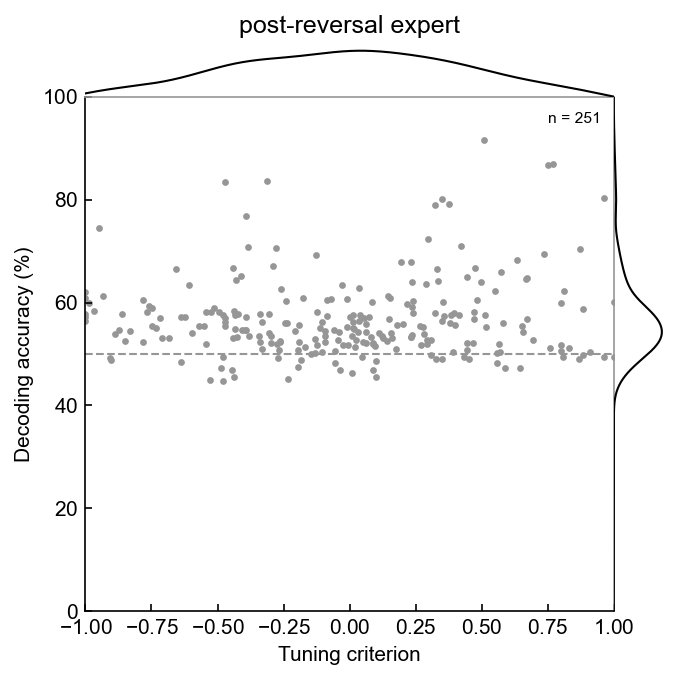

In [805]:
size = 5
#xlims = [-1,3]
xlims = [-1,1]
ylims = [0,100]

def plotTuningDecodingDist(data,Tdata,label):
    #logFRdata = np.log10(FRdata)
    #colors = NCR_CR_cmap(np.array(FRdata)/4)
    
    fig,ax = plt.subplots(figsize=(5,5))
    gs = fig.add_gridspec(2,2,height_ratios=[1,10],width_ratios=[10,1],hspace=0,wspace=0)
    ax = plt.subplot(gs[1,0])#Raster
    axv = plt.subplot(gs[1,1])#PSTH
    axh = plt.subplot(gs[0,0])#PSTH
    
    ax.scatter(Tdata,data,c=GOOD_GREY,s=size)
    
    #Horizontal
    ax.set_xlabel('Tuning criterion')
    ax.set_xlim(xlims)
    ax.plot(xlims,[50,50],color=GOOD_GREY,linestyle='--',lw=1,zorder=-10)
    #ax.text(10**(-0.875),5,'NCR',color=NCR_COLOR)
    #ax.text(10**(2.6),5,'CR',color=CR_COLOR)
    ax.text(0.75,95,'n = '+str(np.sum(np.isfinite(data))),color='k',fontsize=7.5)
    
    #Vertical
    ax.set_ylabel('Decoding accuracy (%)')
    ax.set_ylim(ylims)
    
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)
    ax.spines['top'].set_color(GOOD_GREY)
    ax.spines['right'].set_color(GOOD_GREY)
    
    #FR Modulation
    #NOTE that this is done as a linear KDE over pre-logged
    #data points. This is because the KDE needs to be done on
    #data that is already logged so that the kernel is not stretched
    #when the KDE is evaluated
    noNansT = Tdata[np.isfinite(Tdata)]
    KDEh = gaussian_kde(noNansT, bw_method='scott')
    xrange = np.linspace(xlims[0],xlims[1],1000)
    yvals = KDEh.evaluate(xrange)
    
    axh.plot(xrange,yvals,color='k',lw=1)
    
    #axh.set_xscale('log')
    axh.set_xticks([])
    axh.set_xlim(xlims)
    
    axh.set_yticks([])
    axh.set_ylim([np.min(yvals),np.max(yvals)*1.1])
    
    axh.axis('off')
    
    #Decoding Accuracy
    noNans = data[np.isfinite(data)]
    KDEv = gaussian_kde(noNans, bw_method='scott')
    yrange = np.linspace(ylims[0],ylims[1],1000)
    xvals = KDEv.evaluate(yrange)
    
    axv.plot(xvals,yrange,color='k',lw=1)
    
    axv.set_xticks([])
    axv.set_xlim([np.nanmin(xvals),np.nanmax(xvals)*1.1])
    
    axv.set_yticks([])
    axv.set_ylim(ylims)
    
    axv.axis('off')
    #axv.plot([0,0],ylims,color=GOOD_GREY,lw=2,zorder=-10)
    #
    axh.set_title(label)
    fig.savefig(os.path.join('D:\\\\Figures','Decoding Figures','TuningDecoding Distributions',label+' '+cellstouse+' .png'),transparent=False,facecolor="white")

labelstring = 'pre-reversal early'
data = np.array(Dec_preearly)*100
Tdata = np.array(FRt_preearly)
plotTuningDecodingDist(data,Tdata,labelstring)

labelstring = 'pre-reversal late'
data = np.array(Dec_preint)*100
Tdata = np.array(FRt_preint)
plotTuningDecodingDist(data,Tdata,labelstring)

labelstring = 'pre-reversal expert'
data = np.array(Dec_prelate)*100
Tdata = np.array(FRt_prelate)
plotTuningDecodingDist(data,Tdata,labelstring)
    
labelstring = 'post-reversal early'
data = np.array(Dec_postearly)*100
Tdata = np.array(FRt_postearly)
plotTuningDecodingDist(data,Tdata,labelstring)

labelstring = 'post-reversal late'
data = np.array(Dec_postint)*100
Tdata = np.array(FRt_postint)
plotTuningDecodingDist(data,Tdata,labelstring)

labelstring = 'post-reversal expert'
data = np.array(Dec_postlate)*100
Tdata = np.array(FRt_postlate)
plotTuningDecodingDist(data,Tdata,labelstring)

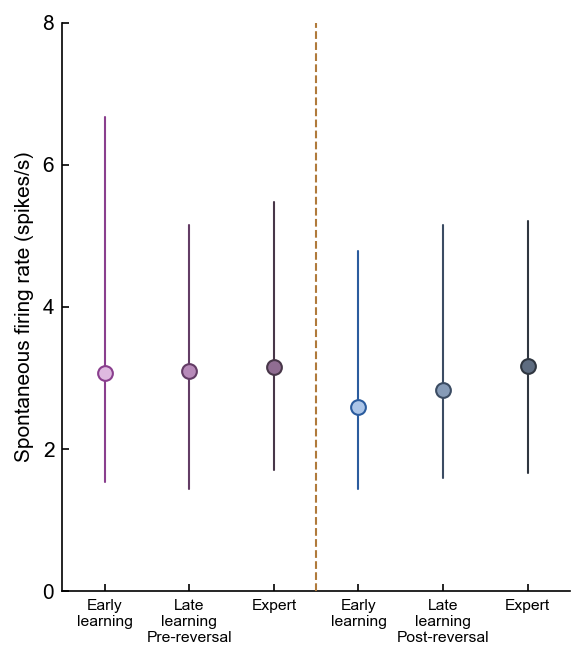

In [1094]:
size=5

FRb_baseline_median = np.nanmedian(FRb_preint)

fig, ax = plt.subplots(figsize=(4,4.5))
data = [FRb_preearly,FRb_preint,FRb_prelate,FRb_postearly,FRb_postint,FRb_postlate]
labels = ['Early\nlearning','Late\nlearning\nPre-reversal','Expert','Early\nlearning','Late\nlearning\nPost-reversal','Expert']
phase_colors = ['#DEB9E0','#B78AB9','#906D92','#ABC5E8','#869BB7','#5E6C80']
numCon = len(data)
X = [np.ones(len(l))*idx for idx,l in enumerate(data)]

_,Y = ilep.violin(np.concatenate(X),np.concatenate(data))
X,_ = ilep.violin(np.concatenate(X),np.log10(np.concatenate(data)),width=0.25)
#colors = NCR_CR_cmap((Y-1)/5)

#ax.scatter(X, Y, s=size, ec=GOOD_GREY, fc='white', lw=0.5,zorder=-10)

#Plot summary
for idx,column in enumerate(data):
    
    eye_color=phase_colors[idx]
    r,g,b = mpl.colors.to_rgb(eye_color)
    h,l,s = colorsys.rgb_to_hls(r,g,b)
    border_color=colorsys.hls_to_rgb(h,l*0.5,s)

    summary_size=50
    summary_width=1
    
    Q1, median, Q3 = (np.nanpercentile(column, q) for q in [25, 50, 75])
    
    ax.scatter([idx], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
    ax.plot([idx, idx], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')

ax.axvline(2.5,color=SWITCH_COLOR,linestyle='--',zorder=10,lw=1)
    
#ax.scatter([],[], s=50, c=CR_COLOR, zorder=0, lw=0, label='CRs')
#ax.scatter([],[], s=50, c=NCR_COLOR, zorder=0, lw=0, label='NCRs')
#ax.legend(frameon=False)

#ax.set_yscale('log',subsy=[])
#ax.set_ylim([0.1,200])
#ax.set_yticks([0.1,1,10,100])
#ax.set_yticklabels(['0.1','1','10','100'])
#ax.set_ylabel('Spontaneous firing rate (spikes/s)')

#ax.set_yscale('log',subsy=[])
ax.set_ylim([0,8])
ax.set_yticks([0,2,4,6,8])
#ax.set_yticklabels(['1','10'])
ax.set_ylabel('Spontaneous firing rate (spikes/s)')

ax.set_xlim([-0.5,5.5])
ax.set_xticks(range(numCon))
ax.set_xticklabels(labels,fontsize=7.5)
ax.set_xlim(ax.get_xlim())

ax.fill_between(ax.get_xlim(),[ax.get_ylim()[0]]*2,[ax.get_ylim()[1]]*2,color='white',alpha=0.5,zorder=-5)
#ax.axhline(FRb_baseline_median,color='k',linestyle='--',lw=1,zorder=-4)

pass

plt.tight_layout()
plt.savefig(os.path.join('D:\\\\Figures','Decoding Figures','FR modulations','AC Spontaneous FR '+cellstouse+'.pdf'),transparent=False,facecolor="white")

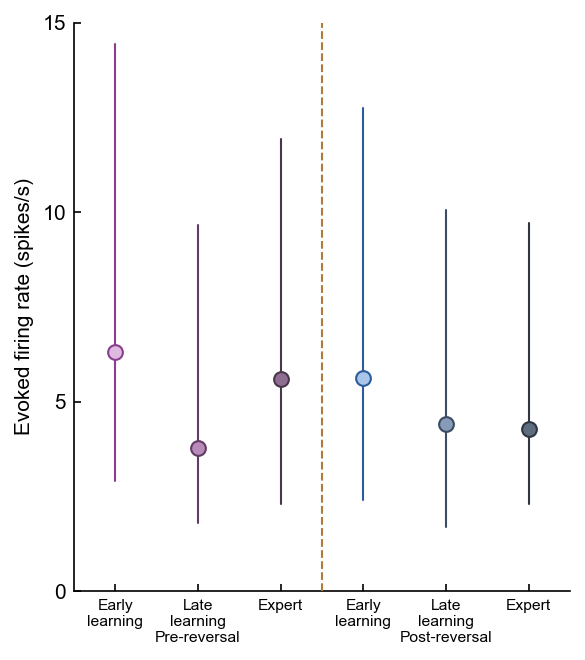

In [1093]:
size=5

FRb_baseline_median = np.nanmedian(FRb_preint)

fig, ax = plt.subplots(figsize=(4,4.5))
data = [FRe_preearly,FRe_preint,FRe_prelate,FRe_postearly,FRe_postint,FRe_postlate]
labels = ['Early\nlearning','Late\nlearning\nPre-reversal','Expert','Early\nlearning','Late\nlearning\nPost-reversal','Expert']
phase_colors = ['#DEB9E0','#B78AB9','#906D92','#ABC5E8','#869BB7','#5E6C80']
numCon = len(data)
X = [np.ones(len(l))*idx for idx,l in enumerate(data)]

_,Y = ilep.violin(np.concatenate(X),np.concatenate(data))
X,_ = ilep.violin(np.concatenate(X),np.log10(np.concatenate(data)),width=0.25)
#colors = NCR_CR_cmap((Y-1)/5)

#ax.scatter(X, Y, s=size, ec=GOOD_GREY, fc='white', lw=0.5,zorder=-10)

#Plot summary
for idx,column in enumerate(data):
    
    eye_color=phase_colors[idx]
    r,g,b = mpl.colors.to_rgb(eye_color)
    h,l,s = colorsys.rgb_to_hls(r,g,b)
    border_color=colorsys.hls_to_rgb(h,l*0.5,s)

    summary_size=50
    summary_width=1
    
    Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
    
    ax.scatter([idx], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
    ax.plot([idx, idx], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')

ax.axvline(2.5,color=SWITCH_COLOR,linestyle='--',zorder=10,lw=1)
    
#ax.scatter([],[], s=50, c=CR_COLOR, zorder=0, lw=0, label='CRs')
#ax.scatter([],[], s=50, c=NCR_COLOR, zorder=0, lw=0, label='NCRs')
#ax.legend(frameon=False)

#ax.set_yscale('log',subsy=[])
#ax.set_ylim([0.1,200])
#ax.set_yticks([0.1,1,10,100])
#ax.set_yticklabels(['0.1','1','10','100'])
#ax.set_ylabel('Spontaneous firing rate (spikes/s)')

#ax.set_yscale('log',subsy=[])
if cellstouse == 'all cells':
    ax.set_ylim([1,15])
    ax.set_yticks([0,5,10,15])
    ax.set_ylabel('Evoked firing rate (spikes/s)')
elif cellstouse == 'task encoders':
    ax.set_ylim([1,30])
    ax.set_yticks([0,5,10,15,20,25,30])
    ax.set_ylabel('Evoked firing rate (spikes/s)')
    
ax.set_xlim([-0.5,5.5])
ax.set_xticks(range(numCon))
ax.set_xticklabels(labels,fontsize=7.5)
ax.set_xlim(ax.get_xlim())

ax.fill_between(ax.get_xlim(),[ax.get_ylim()[0]]*2,[ax.get_ylim()[1]]*2,color='white',alpha=0.5,zorder=-5)
#ax.axhline(FRb_baseline_median,color='k',linestyle='--',lw=1,zorder=-4)

pass

plt.tight_layout()
plt.savefig(os.path.join('D:\\\\Figures','Decoding Figures','FR modulations','AC Evoked FR '+cellstouse+'.pdf'),transparent=False,facecolor="white")

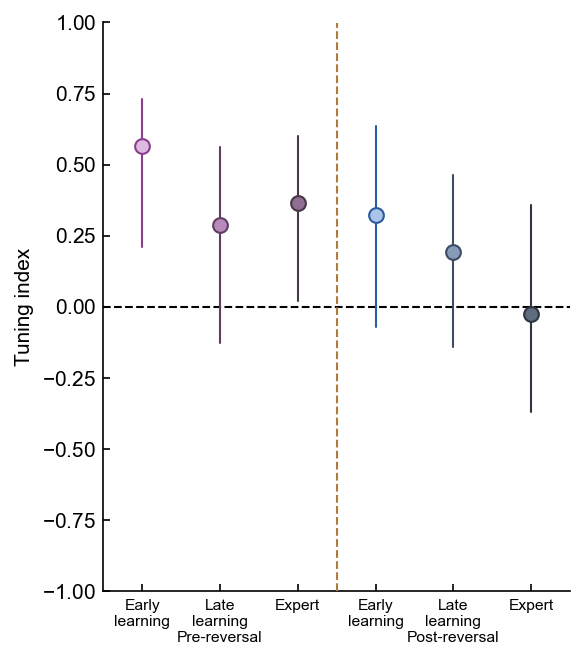

In [1100]:
size=5

#FRb_baseline_median = np.nanmedian(FRb_preint)

fig, ax = plt.subplots(figsize=(4,4.5))
data = [FRt_preearly,FRt_preint,FRt_prelate,-FRt_postearly,-FRt_postint,-FRt_postlate]
labels = ['Early\nlearning','Late\nlearning\nPre-reversal','Expert','Early\nlearning','Late\nlearning\nPost-reversal','Expert']
phase_colors = ['#DEB9E0','#B78AB9','#906D92','#ABC5E8','#869BB7','#5E6C80']
numCon = len(data)
X = [np.ones(len(l))*idx for idx,l in enumerate(data)]

X,Y = ilep.violin(np.concatenate(X),np.concatenate(data),width=0.25)
#colors = NCR_CR_cmap((Y-1)/5)

#ax.scatter(X, Y, s=size, ec=GOOD_GREY, fc='white', lw=0.5,zorder=-10)

#Plot summary
for idx,column in enumerate(data):
    
    eye_color=phase_colors[idx]
    r,g,b = mpl.colors.to_rgb(eye_color)
    h,l,s = colorsys.rgb_to_hls(r,g,b)
    border_color=colorsys.hls_to_rgb(h,l*0.5,s)

    summary_size=50
    summary_width=1
    
    Q1, median, Q3 = (np.nanpercentile(column, q) for q in [25, 50, 75])
    
    ax.scatter([idx], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
    ax.plot([idx, idx], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')
    
ax.axvline(2.5,color=SWITCH_COLOR,linestyle='--',zorder=10,lw=1)

#ax.set_yscale('log',subsy=[])
ax.set_ylim([-1,1])
#ax.set_yticks([-1,-0.5,0,0.5,1])
#ax.set_yticklabels(['0.1','1','10','100'])
#ax.set_yticks([-1,0,1])
#ax.set_yticklabels(['100%\nTone B','0','100%\nTone A'])
ax.set_ylabel('Tuning index')

ax.set_xlim([-0.5,5.5])
ax.set_xticks(range(numCon))
ax.set_xticklabels(labels,fontsize=7.5)
ax.set_xlim(ax.get_xlim())

ax.fill_between(ax.get_xlim(),[ax.get_ylim()[0]]*2,[ax.get_ylim()[1]]*2,color='white',alpha=0.5,zorder=-5)
ax.axhline(0,color='k',linestyle='--',lw=1,zorder=-4)

pass

plt.tight_layout()
plt.savefig(os.path.join('D:\\\\Figures','Decoding Figures','FR modulations','AC Tuning '+cellstouse+'.pdf'),transparent=False,facecolor="white")

In [1054]:
valid_acc = []
is_TE = []

animalstouse = ['BS_40','BS_41','BS_42','BS_49','BS_51','BS_56','BS_59','BS_61','BS_67','BS_70','BS_72','BS_87','BS_108','DS_15','DS_19']

cellstouse = 'all cells'
#cellstouse = 'task encoders'

for idx,clust in tqdm(enumerate(clusters)):
    if not regions[idx] == 'AC':
        continue
    
    if cellstouse == 'task encoders':
        if not np.isfinite(accuracies[idx]) or pvals[idx] > 0.05 or accuracies[idx] < task_encoder_threshold:
            continue
        
    session = sessionIDs[idx]
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    if not sessionfile.meta.animal in animalstouse:
        continue
        
    if sessionfile.meta.animal == 'BS_67' and sessionfile.meta.day_of_training >= 15:
        continue
        
    valid_acc.append(accuracies[idx])
    if task_encoders[idx]:
        is_TE.append(True)
    else:
        is_TE.append(False)

5801it [00:11, 487.11it/s] 


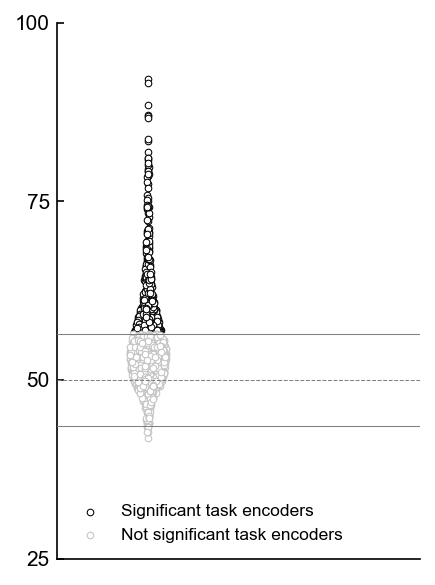

In [1090]:
fig, ax = plt.subplots(figsize=(3,4))



X = np.ones_like(valid_acc)
_,Y = ilep.violin(X,valid_acc)
X,_ = ilep.violin(X,np.log10(valid_acc),width=0.25)

size=10
ax.scatter(X[is_TE], Y[is_TE], s=size, ec='black', fc='white', lw=0.5,zorder=0,label='Significant task encoders')
ax.scatter(X[np.logical_not(is_TE)], Y[np.logical_not(is_TE)], s=size, ec='#C3C3C3', fc='white', lw=0.5,zorder=0,label='Not significant task encoders')

ax.set_xlim([0.5,2.5])
ax.set_xticks([])

ax.set_ylim([0.25,1])
ax.set_yticks([0.25,0.5,0.75,1])
ax.set_yticklabels(['25','50','75','100'])

ax.axhline(task_encoder_threshold,linestyle='-',color='grey',zorder=10,lw=0.5)
ax.axhline(0.5,linestyle='--',color='grey',zorder=10,lw=0.5)
ax.axhline(0.5-(task_encoder_threshold-0.5),linestyle='-',color='grey',zorder=10,lw=0.5)

ax.legend(frameon=False)

plt.tight_layout()
plt.savefig(os.path.join('D:\\\\Figures','Decoding Figures','Summaries','Task encoders schematic.pdf'),transparent=False,facecolor="white")